Fairness Metrics
---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from scipy.stats import entropy

In [2]:
# Upload datasets

#Load original dataset
e_commerce = pd.read_csv(r"C:\Users\MelvanderMeij\Downloads\E-commerce\E-commerce\ecommerce_data.csv")

# Load predictions
svdpp_predictions = pd.read_csv(r"C:\Users\MelvanderMeij\Downloads\E-commerce\E-commerce\svdpp_predictions_all.csv")
itemknn_predictions = pd.read_csv(r"C:\Users\MelvanderMeij\Downloads\E-commerce\E-commerce\itemknn_predictions_all.csv")

In [3]:
(e_commerce.head())

,Customer_ID,Age,Gender,Income_Level,Marital_Status,Education_Level,Occupation,Location,Purchase_Category,Purchase_Amount,...,Device_Used_for_Shopping,Payment_Method,Time_of_Purchase,Discount_Used,Customer_Loyalty_Program_Member,Purchase_Intent,Shipping_Preference,Time_to_Decision,Age_Group,Purchase_Amount_Group
0,37-611-6911,22,Female,Middle,Married,Bachelor's,Middle,Évry,Gardening & Outdoors,333.80,...,Tablet,Credit Card,3/1/2024,True,False,Need-based,No Preference,2,18–25,$251–350
1,29-392-9296,49,Male,High,Married,High School,High,Huocheng,Food & Beverages,222.22,...,Tablet,PayPal,4/16/2024,True,False,Wants-based,Standard,6,46–50,$151–250
2,84-649-5117,24,Female,Middle,Single,Master's,High,Huzhen,Office Supplies,426.22,...,Smartphone,Debit Card,3/15/2024,True,True,Impulsive,No Preference,3,18–25,$351–450
3,48-980-6078,29,Female,Middle,Single,Master's,Middle,Wiwilí,Home Appliances,101.31,...,Smartphone,Other,10/4/2024,True,True,Need-based,Express,10,26–30,$50–150
4,91-170-9072,33,Female,Middle,Widowed,High School,Middle,Nara,Furniture,211.70,...,Smartphone,Debit Card,1/30/2024,False,False,Wants-based,No Preference,4,31–35,$151–250


In [4]:
(svdpp_predictions.head())

,customer_id,purchase_category,predicted_rating
0,37-611-6911,Gardening & Outdoors,5.339520
1,37-611-6911,Baby Products,4.927550
2,37-611-6911,Clothing,4.484600
3,37-611-6911,Travel & Leisure (Flights,4.406662
4,37-611-6911,Hotels,4.312482


In [5]:
customer_summary = svdpp_predictions.groupby("customer_id")["predicted_rating"].agg(
    rating_count="count",
    ratings_list=list
).reset_index()

print(customer_summary)

     customer_id  rating_count  \
0    00-107-4749            10   
1    00-149-4481            10   
2    00-264-3797            10   
3    00-265-0556            10   
4    00-275-9990            10   
..           ...           ...   
995  99-509-4653            10   
996  99-581-5577            10   
997  99-643-9845            10   
998  99-771-9310            10   
999  99-945-7193            10   

                                          ratings_list  
0    [4.226084331234743, 4.050031786584044, 3.99619...  
1    [4.013660936643024, 3.9575326472952512, 3.9226...  
2    [4.080749256324297, 4.010048088095542, 3.98391...  
3    [4.081140398317662, 4.016616865584855, 3.96409...  
4    [4.71806936882477, 4.4355616862699385, 4.36370...  
..                                                 ...  
995  [5.170646496158401, 4.654469152191963, 4.60058...  
996  [4.073596544798597, 4.0287186267468815, 3.8904...  
997  [3.9124343058855215, 3.7711069728933455, 3.730...  
998  [3.9228602012079

In [6]:
(itemknn_predictions.head())

,purchase_category,customer_id,true_rating,predicted_rating
0,Animal Feed,00-107-4749,0.0,NaN
1,Animal Feed,00-149-4481,0.0,NaN
2,Animal Feed,00-264-3797,0.0,NaN
3,Animal Feed,00-265-0556,0.0,NaN
4,Animal Feed,00-275-9990,0.0,NaN


In [7]:
knn_customer_summary = itemknn_predictions.groupby("customer_id")["predicted_rating"].agg(
    rating_count="count",
    ratings_list=list
).reset_index()

print(knn_customer_summary)

     customer_id  rating_count  \
0    00-107-4749             1   
1    00-149-4481             1   
2    00-264-3797             1   
3    00-265-0556             1   
4    00-275-9990             1   
..           ...           ...   
995  99-509-4653             1   
996  99-581-5577             3   
997  99-643-9845             1   
998  99-771-9310             4   
999  99-945-7193             1   

                                          ratings_list  
0    [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...  
1    [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...  
2    [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...  
3    [nan, nan, nan, nan, nan, nan, nan, nan, 4.059...  
4    [nan, nan, nan, nan, nan, nan, nan, 3.95999312...  
..                                                 ...  
995  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...  
996  [nan, nan, 3.6, nan, nan, nan, nan, nan, nan, ...  
997  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...  
998  [nan, nan, nan, 

Creating a dictionary to store customer demographics:

In [8]:
customer_demographics = {}

"""
    Constructs a dictionary mapping each Customer ID to their demographic attributes.

    Parameters:
    df (DataFrame): E-commerce dataset with customer demographic columns.

    Returns:
    dict: Dictionary with Customer IDs as keys and demographic attributes as values.
"""

# Fill the customer demographics dictionary
for _, row in e_commerce.iterrows():
    customer_demographics[row['Customer_ID']] = {
        'gender': row['Gender'],
        'age_group': row['Age_Group'],
        'income_level': row['Income_Level'],
        'education_level': row['Education_Level'],
        'occupation': row['Occupation'],
        'marital_status': row['Marital_Status']
    }

Converting dataframes into dictionary formats for some fairness functions:

In [9]:
"""-------------------------- SVD++ -----------------------------------------"""
# For SVD++ predictions:
svdpp_recommendations_dict = (
    svdpp_predictions
    .groupby('customer_id')
    .apply(lambda df: list(zip(df['purchase_category'], df['predicted_rating'])))
    .to_dict()
)

"""-------------------------- Item KNN -----------------------------------------"""
# Filter out rows with NaN predicted ratings for itemKNN:
itemknn_clean = itemknn_predictions.dropna(subset=['predicted_rating'])

# Build the recommendations dictionary without NaN values:
itemknn_recommendations_dict = (
    itemknn_clean
    .groupby('customer_id')
    .apply(lambda df: list(zip(df['purchase_category'], df['predicted_rating'])))
    .to_dict()
)

---
---
**Individual User Fairness**
---
In this analysis, the individual user fairness of the two recommendation system models (SVD++ and Item-KNN) are evaluated using two metrics: Variance and Mean Average Envy (MAE). Both metrics capture distinct aspects of fairness by assessing the consistency and perceived equity of recommendations across individual customers.

1) **Variance** measures how consistent the predicted ratings are for each individual user across the product categories recommended to them (top-5). A high variance indicates the user is being treated inconsistently — getting some highly rated and some poorly rated items — which could reflect unfairness or instability in their recommendations. A fair recommender should provide consistently high-quality or stable recommendations. This is computed as follows:
    - Loop over each customer in the top-5 recommendations dictionary (either from SVD++ or KNN).
    - Compute the variance of the top 5 predicted ratings for each individual.

2) **Mean Average Envy** evaluates how much each individual user might envy others’ recommendations — if they see others being recommended the same items but with higher predicted ratings. A fair system should not make users feel disadvantaged compared to others. High envy means many others received better recommendations for the same items → potentially unfair model. This is computed as follows:
    - For each customer i, it loops over all other customers j.
    - For each pair of users, it compares only the categories they have in common.
    - For each shared category: Envy 𝑖 → 𝑗 = max(Rating 𝑗 − Rating 𝑖, 0)
    - Sum envy values across all comparisons, then average over the total number of comparisons made to get the mean average envy for each individual.

---
**1) Variance for Individual Fairness:**
--

In [10]:

def compute_customer_variance(df, customer_id_col='customer_id', rating_col='predicted_rating'):
    """
    Compute the variance of predicted ratings for each customer.

    Parameters:
        df (pd.DataFrame): DataFrame containing the predictions.
        customer_id_col (str): Name of the column with the customer IDs.
        rating_col (str): Name of the column with the predicted ratings.

    Returns:
        pd.DataFrame: A DataFrame with each customer and their corresponding variance.
    """
    variance_df = (
        df.groupby(customer_id_col)[rating_col]
          .var()
          .reset_index()
          .rename(columns={rating_col: 'variance'})
    )
    return variance_df

Computing individual variance for the models:

In [11]:
svdpp_variance_df = compute_customer_variance(svdpp_predictions, customer_id_col='customer_id', rating_col='predicted_rating')
itemknn_variance_df = compute_customer_variance(itemknn_predictions, customer_id_col='customer_id', rating_col='predicted_rating')

Comparing model results:

In [12]:
# Compare the variances side-by-side
# ----------------------------------------
variance_comparison_df = pd.merge(
    svdpp_variance_df.rename(columns={'variance': 'svdpp_variance'}),
    itemknn_variance_df.rename(columns={'variance': 'itemknn_variance'}),
    on='customer_id',
    how='outer'
)

svdpp_mean_variance = variance_comparison_df['svdpp_variance'].mean()
itemknn_mean_variance = variance_comparison_df['itemknn_variance'].mean()

print("\nAverage SVD++ variance across customers:", svdpp_mean_variance)
print("Average itemKNN variance across customers:", itemknn_mean_variance)

if svdpp_mean_variance < itemknn_mean_variance:
    print("\nSVD++ seems more fair on average (lower variance).")
else:
    print("\nItemKNN seems more fair on average (lower variance).")


Average SVD++ variance across customers: 0.02952664580361186
Average itemKNN variance across customers: 0.7075118931764025

SVD++ seems more fair on average (lower variance).


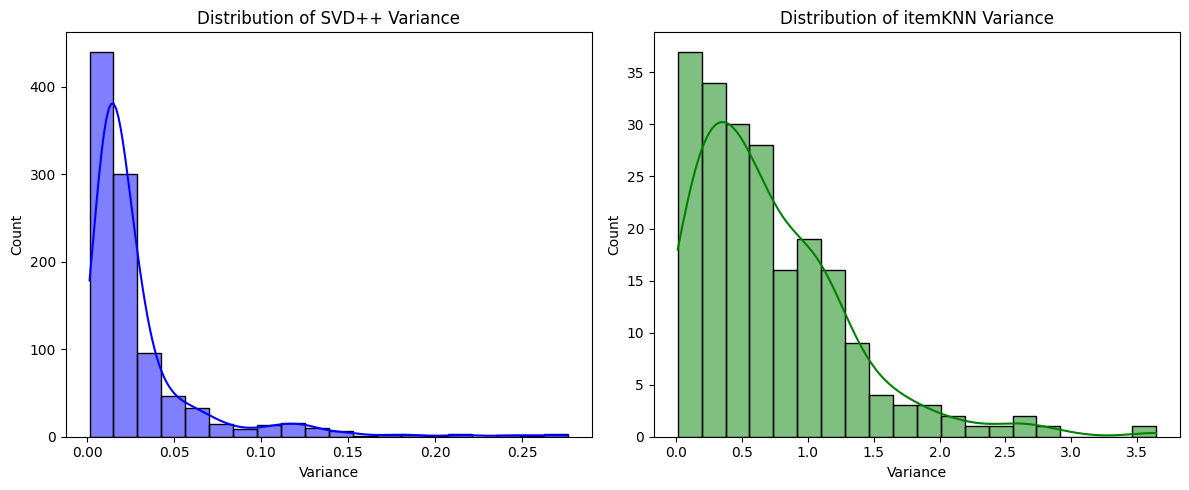

In [13]:
# Extract non-null variances for each model
svdpp_variances = variance_comparison_df['svdpp_variance'].dropna()
itemknn_variances = variance_comparison_df['itemknn_variance'].dropna()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

sns.histplot(svdpp_variances, ax=axes[0], bins=20, kde=True, color='blue')
axes[0].set_title("Distribution of SVD++ Variance")
axes[0].set_xlabel("Variance")
axes[0].set_ylabel("Count")

sns.histplot(itemknn_variances, ax=axes[1], bins=20, kde=True, color='green')
axes[1].set_title("Distribution of itemKNN Variance")
axes[1].set_xlabel("Variance")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()

SVD++ Plot:
- Most customers have a very small variance (well under 0.02). This suggests that for each of those customers, the model predicted that the customer will rate them quite similarly

itemKNN Plot:
- A broader distribution, extending up to 3.5. This indicates that for some customers, the predicted ratings are quite spread out (some items are predicted high, others low), which leads to a higher variance.

---
**2) Mean Average Envy for Individual Fairness:**
--

In [14]:
def calculate_individual_mean_average_envy(top_5_recommendations):
    """
    Calculates Mean Average Envy (MAE) for each customer based on their predicted ratings.
    Envy is defined as the average positive difference between the ratings of other customers
    and the focal customer's own rating for the same category.

    Parameters:
        top_5_recommendations (dict):
            Dictionary mapping customer IDs to a list of tuples (product_category, predicted_rating).

    Returns:
        dict: Dictionary mapping customer IDs to their MAE values.
              Format: {customer_id: mean_average_envy (float)}
    """
    individual_envy = {}
    customers = list(top_5_recommendations.keys())

    for customer_i in customers:
        recs_i = top_5_recommendations.get(customer_i, [])
        total_envy = 0
        comparisons = 0

        for category_i, rating_i in recs_i:
            # Compare against all other customers
            for customer_j in customers:
                if customer_i == customer_j:
                    continue
                recs_j = top_5_recommendations.get(customer_j, [])
                # Check ratings for the same category
                for category_j, rating_j in recs_j:
                    if category_j == category_i:
                        envy = max(rating_j - rating_i, 0)
                        total_envy += envy
                        comparisons += 1

        individual_envy[customer_i] = total_envy / comparisons if comparisons > 0 else 0.0

    return individual_envy

Calculating the individual MAE for models:

In [15]:
svdpp_envy = calculate_individual_mean_average_envy(svdpp_recommendations_dict)

itemknn_envy = calculate_individual_mean_average_envy(itemknn_recommendations_dict)

Comparing model results:

In [16]:
print("SVD++ Envy Dictionary Sample:")
for i, (cust, envy) in enumerate(svdpp_envy.items()):
    print(cust, envy)
    if i > 5:
        break

print("\nitemKNN Envy Dictionary Sample:")
for i, (cust, envy) in enumerate(itemknn_envy.items()):
    print(cust, envy)
    if i > 5:
        break

SVD++ Envy Dictionary Sample:
00-107-4749 0.10944716704765031
00-149-4481 0.16653410402457622
00-264-3797 0.22932113189236072
00-265-0556 0.1735520018847659
00-275-9990 0.04108379313278032
00-285-9607 0.20507287863138257
00-335-5034 0.04542758983341897

itemKNN Envy Dictionary Sample:
00-107-4749 0.21995454687500848
00-149-4481 0.0893350929228771
00-264-3797 0.8665838650016742
00-265-0556 0.3128186983069461
00-275-9990 0.13500185933046868
00-285-9607 0.25458424412058384
00-335-5034 0.38633648123670455


In [17]:
# Convert the model envy dictionaries to DataFrames:
svdpp_envy_df = pd.DataFrame(list(svdpp_envy.items()), columns=['customer_id', 'svdpp_envy'])
itemknn_envy_df = pd.DataFrame(list(itemknn_envy.items()), columns=['customer_id', 'itemknn_envy'])

# Merge DataFrames for side-by-side comparison:
envy_comparison_df = pd.merge(
    svdpp_envy_df,
    itemknn_envy_df,
    on='customer_id',
    how='outer'
)

# Compute means; NaNs are ignored by default
svdpp_mean_envy = envy_comparison_df['svdpp_envy'].mean()
itemknn_mean_envy = envy_comparison_df['itemknn_envy'].mean()

print("\nAverage SVD++ mean average envy across customers:", svdpp_mean_envy)
print("Average itemKNN mean average envy across customers:", itemknn_mean_envy)

if svdpp_mean_envy < itemknn_mean_envy:
    print("\nSVD++ seems more fair on average (lower mean average envy).")
else:
    print("\nItemKNN seems more fair on average (lower mean average envy).")


Average SVD++ mean average envy across customers: 0.12447657357210838
Average itemKNN mean average envy across customers: 0.40548623507822174

SVD++ seems more fair on average (lower mean average envy).


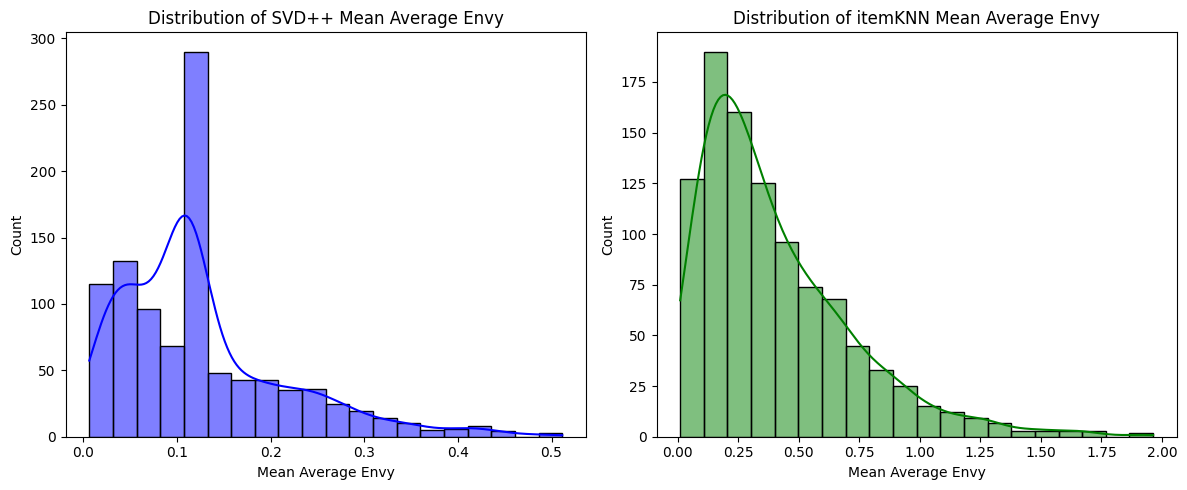

In [18]:
# Extract non-null envy values for each model
svdpp_envies = envy_comparison_df['svdpp_envy'].dropna()
itemknn_envies = envy_comparison_df['itemknn_envy'].dropna()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

sns.histplot(svdpp_envies, ax=axes[0], bins=20, kde=True, color='blue')
axes[0].set_title("Distribution of SVD++ Mean Average Envy")
axes[0].set_xlabel("Mean Average Envy")
axes[0].set_ylabel("Count")

sns.histplot(itemknn_envies, ax=axes[1], bins=20, kde=True, color='green')
axes[1].set_title("Distribution of itemKNN Mean Average Envy")
axes[1].set_xlabel("Mean Average Envy")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()


The plots suggest SVD++ generally yields lower envy values for the majority of customers, while itemKNN has more spread, meaning some customers experience higher envy levels. 

---
---
**Group User Fairness**
---
To evaluate group fairness in the recommender systems, four complementary fairness metrics are applied across various demographic attributes (gender, age, income and education level and sarital status). Each metric captures a different dimension of fairness in predicted satisfaction.

1) **Variance** captures how consistent the predicted ratings are for users within a demographic group across product categories. A fair recommender should treat users in the same group similarly (e.g., same gender or age group). Lower vairance refers to a fairer system (more consistency for that group).It is computed as follows:
    - Group customers by demographic attribute (e.g. gender_female)
    - For each product category, collect all predicted ratings from users in that group.
    - Compute the variance of those ratings.
    - Average variances across all categories → gives one fairness score per group.

2) **Mean Average Envy (MAE)** quantifies how much users in a demographic group might envy recommendations given to others in the same group. A fair model should make all users feel their recommendations are not worse than others in their dempgraphical attribute group. Lower envy → users aren’t disadvantaged compared to their peers → fairer system. Within each demographic group (e.g., gender_female), it:
    - Compares all pairs of users who received recommendations for the same category within each demographic group (e.g. gender_female)
    - For each pair (comparison): calculatete envy:
        - Envy 𝑖 → 𝑗 = max(Rating 𝑗 − Rating 𝑖, 0)
            - If user j got a better rating than i, user i envies that.
    - All envy values are summed and averaged over the number of comparisons.
    - The final output is the mean average envy per group.

3) **Absolute Difference (AD)** captures the difference in average predicted satisfaction between a rotected group (females) and an unprotected group (males). These groups were selected to showcase for the metric works, but tehy could also be e.g. active users and inactive users. A fair model should not favor one group over another in terms of average predicted rating. Lower AD indicates smaller disparity (gap) between protected and unprotected groups → more equal (fair) treatment across groups. This is computes as:
    - For each product category, seperate predicted ratings by gender
    - Compute: AD category = ∣average rating of the unprotected group − average rating of the protected group∣
    - Average across all categories for an overall fairness score.

4) **Fraction of Satisfied Users (FSU)** reflects how many users in a group are at least as satisfied as the group's average, based on predicted ratings. If most users in a group feel they are at or above the group norm, that suggests equitable treatment. Higher satisfaction means that more users in that group receive recommendations they are likely to appriciate → more equitable satisfaction. It is computes as follows:
    - Compute each user's average predicted rating (i.e. their "utility").
    - Calculate the average utility for their group.
    - Mark user as "satisfied" if their average utility is ≥ group average.
    - Count the fraction of satisfied users in each group by summing satisfied customers and dividing by the group total.




---
**1) Variance for Group Fairness:**
---

Measuring the consistency within a group.

Function for calculating the variance within each demographic group for each product category:

In [19]:
def calculate_group_variances(
    recommendations_dict, 
    customer_demographics, 
    demographic_columns, 
    product_categories
):
    """
    Calculates variance in predicted ratings for each demographic group across product categories.

    Parameters:
        recommendations_dict (dict):
            Dictionary mapping customer IDs -> list of (category, predicted_rating) tuples.
        customer_demographics (dict):
            Dictionary mapping customer IDs -> demographic attributes (e.g., gender, age_group, etc.).
        demographic_columns (list[str]):
            List of demographic attributes (e.g., ['gender', 'age_group']).
        product_categories (list[str]):
            List of product categories to evaluate.

    Returns:
        dict: Nested dictionary structured as follows:
            {
                'gender_Male': {
                    'Category1': {'variance': float, 'count': int},
                    'Category2': {'variance': float, 'count': int},
                    ...
                },
                'gender_Female': { ... },
                ...
            }
    """
    group_stats = defaultdict(lambda: defaultdict(dict))

    # 1. Build groups of customers for each demographic column
    #    Example: 'gender' -> {'Male': [cust1, cust2], 'Female': [cust3, cust4], ...}
    demographic_groups = {col: defaultdict(list) for col in demographic_columns}

    for customer_id, attributes in customer_demographics.items():
        for col in demographic_columns:
            group_value = attributes.get(col, "Unknown")
            demographic_groups[col][group_value].append(customer_id)

    # 2. For each column & group, compute variance for each category
    #    Example group key: "gender_Male"
    for col, groups in demographic_groups.items():
        for group_value, customers_in_group in groups.items():
            group_key = f"{col}_{group_value}"
            for category in product_categories:
                # Collect predicted ratings for this group & category
                ratings = []
                for cust in customers_in_group:
                    for cat, rating in recommendations_dict.get(cust, []):
                        if cat == category:
                            ratings.append(rating)

                variance = np.var(ratings) if ratings else 0.0
                count = len(ratings)

                group_stats[group_key][category] = {
                    "variance": variance,
                    "count": count
                }

    return group_stats


Defining a list of product categories:

In [20]:
all_svdpp_cats = svdpp_predictions['purchase_category'].unique().tolist()
all_itemknn_cats = itemknn_clean['purchase_category'].unique().tolist()
product_categories = list(set(all_svdpp_cats + all_itemknn_cats))

Defining the demographic columns:

In [21]:
demographic_columns = ['gender', 'age_group', 'income_level', 'education_level', 'occupation', 'marital_status']

Calculating the variance:

In [22]:
svdpp_group_variances = calculate_group_variances(
    recommendations_dict=svdpp_recommendations_dict,
    customer_demographics=customer_demographics,
    demographic_columns=demographic_columns,
    product_categories=product_categories
)

itemknn_group_variances = calculate_group_variances(
    recommendations_dict=itemknn_recommendations_dict,
    customer_demographics=customer_demographics,
    demographic_columns=demographic_columns,
    product_categories=product_categories
)


Comparing the results:

In [23]:
# Conversting the results into dataframes for easier comparison:

def group_variances_to_df(group_variances):
    """
    Converts the nested dictionary {group_key: {category: {'variance': v, 'count': c}}}
    into a flat DataFrame.
    """
    rows = []
    for group_key, cat_dict in group_variances.items():
        for category, stats in cat_dict.items():
            rows.append({
                'group_key': group_key,
                'category': category,
                'variance': stats['variance'],
                'count': stats['count']
            })
    return pd.DataFrame(rows)

svdpp_group_variances_df = group_variances_to_df(svdpp_group_variances)
itemknn_group_variances_df = group_variances_to_df(itemknn_group_variances)

print("SVD++ Group Variances:")
print(svdpp_group_variances_df.head())

print("\nItemKNN Group Variances:")
print(itemknn_group_variances_df.head())

SVD++ Group Variances:
       group_key                category  variance  count
0  gender_Female               Groceries  0.052131     45
1  gender_Female            Toys & Games  0.072399    421
2  gender_Female  Beauty & Personal Care  0.070602    173
3  gender_Female         Office Supplies  0.088822    106
4  gender_Female    Gardening & Outdoors  0.326212     27

ItemKNN Group Variances:
       group_key                category  variance  count
0  gender_Female               Groceries  0.526494     33
1  gender_Female            Toys & Games  0.926427     35
2  gender_Female  Beauty & Personal Care  0.737463     20
3  gender_Female         Office Supplies  0.399079     23
4  gender_Female    Gardening & Outdoors  0.697394     29


In [24]:
comparison_df = pd.merge(
    svdpp_group_variances_df.rename(columns={'variance': 'svdpp_variance', 'count': 'svdpp_count'}),
    itemknn_group_variances_df.rename(columns={'variance': 'itemknn_variance', 'count': 'itemknn_count'}),
    on=['group_key', 'category'],
    how='outer'
)

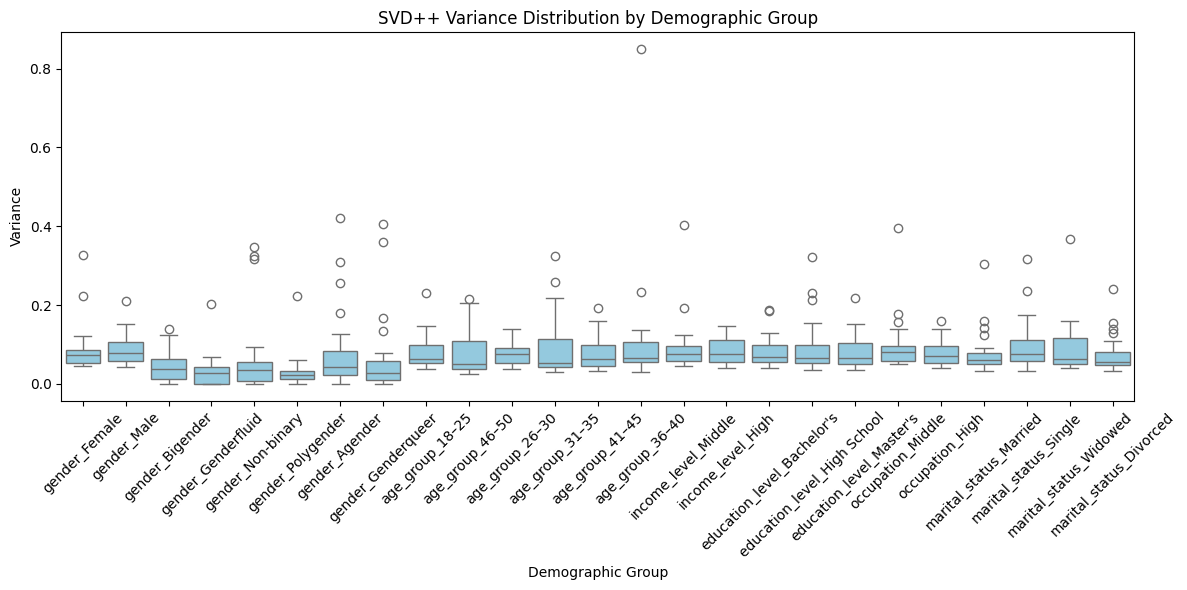

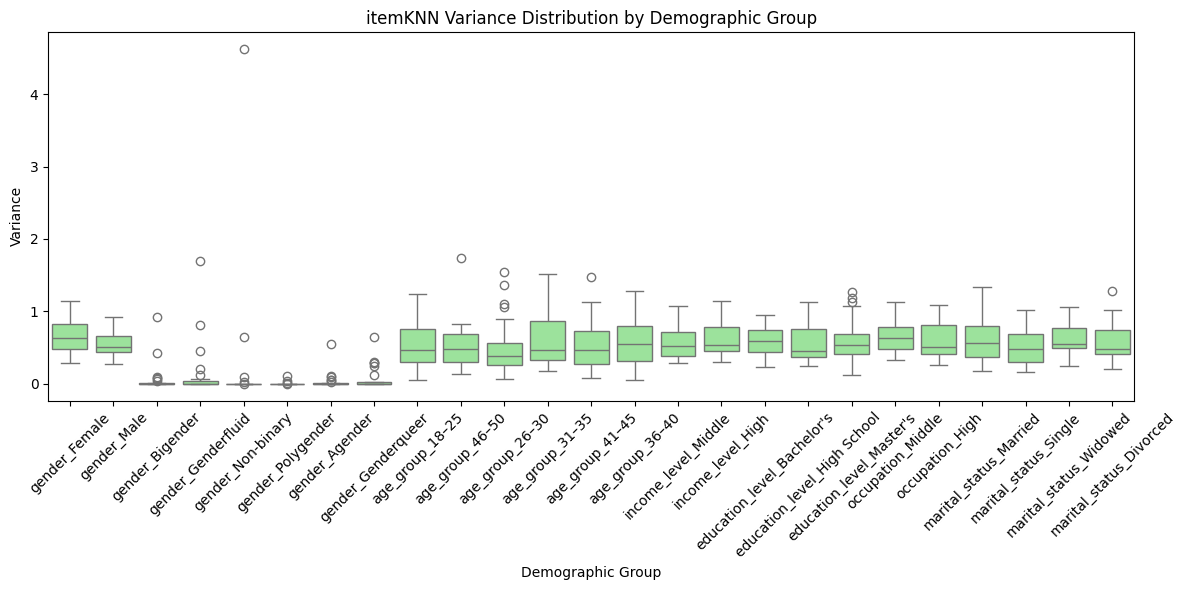

In [25]:
# Boxplot for SVD++
plt.figure(figsize=(12, 6))
sns.boxplot(x='group_key', y='svdpp_variance', data=comparison_df, color='skyblue')
plt.title('SVD++ Variance Distribution by Demographic Group')
plt.xlabel('Demographic Group')
plt.ylabel('Variance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Boxplot for itemKNN
plt.figure(figsize=(12, 6))
sns.boxplot(x='group_key', y='itemknn_variance', data=comparison_df, color='lightgreen')
plt.title('itemKNN Variance Distribution by Demographic Group')
plt.xlabel('Demographic Group')
plt.ylabel('Variance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


The analysis shows that the SVD++ model consistently produces lower variance across demographic groups, indicating more uniform and stable recommendations. In contrast, the itemKNN model exhibits higher variance and greater dispersion, suggesting less consistency in its recommendations across user segments.

---
**2) Mean Average Envy (MAE) for Group Fairness:**
---
Measuring fairness relative to peers in the same group.

In [26]:
def calculate_group_envy(top_5_recommendations, customer_demographics, demographic_columns, product_categories):
    """
    Calculates average envy scores for each demographic group and each product category.
    Envy is computed by summing positive rating differences within customer pairs in the same demographic group,
    then dividing by the number of comparisons, so that the result is normalized.
    
    Parameters:
        top_5_recommendations (dict):
            Dictionary mapping customer IDs -> list of (category, predicted_rating) tuples.
        customer_demographics (dict):
            Dictionary mapping customer IDs -> demographic attributes (e.g., gender, age_group, etc.).
        demographic_columns (list[str]):
            List of demographic attributes to group by (e.g., ['gender', 'age_group']).
        product_categories (list[str]):
            List of product categories to evaluate.
    
    Returns:
        dict: Nested dictionary of average envy values structured as:
            { 'demographic_group': { 'category': average_envy_value, ... }, ... }
    """
    # We'll maintain totals and counts so that we can compute an average
    group_total_envy = defaultdict(lambda: defaultdict(float))
    group_comparison_count = defaultdict(lambda: defaultdict(int))
    
    # Group customers by each demographic attribute.
    demographic_groups = {col: defaultdict(list) for col in demographic_columns}
    for customer_id, attributes in customer_demographics.items():
        for col in demographic_columns:
            group_value = attributes.get(col, "Unknown")
            demographic_groups[col][group_value].append(customer_id)
    
    # For each demographic group, perform pairwise comparisons among customers.
    for col, groups in demographic_groups.items():
        for group_value, customers in groups.items():
            group_key = f"{col}_{group_value}"
            # Compare each pair of customers in this group.
            for idx_i, customer_i in enumerate(customers):
                recs_i = top_5_recommendations.get(customer_i, [])
                for customer_j in customers[idx_i + 1:]:
                    recs_j = top_5_recommendations.get(customer_j, [])
                    # For each product category, compare ratings if both have a rating for that category.
                    for cat_i, rating_i in recs_i:
                        for cat_j, rating_j in recs_j:
                            if cat_i == cat_j:
                                # Count this as one comparison.
                                group_comparison_count[group_key][cat_i] += 1
                                # Calculate the envy difference (absolute difference in this case)
                                envy_val = abs(rating_j - rating_i)
                                group_total_envy[group_key][cat_i] += envy_val
    
    # Compute average envy (i.e., total envy divided by number of comparisons) per group and category.
    group_avg_envy = defaultdict(dict)
    for group_key, cat_dict in group_total_envy.items():
        for category, total_envy in cat_dict.items():
            count = group_comparison_count[group_key][category]
            avg_envy = total_envy / count if count > 0 else 0.0
            group_avg_envy[group_key][category] = avg_envy
    
    return group_avg_envy


In [27]:
svdpp_group_envy = calculate_group_envy(
    top_5_recommendations=svdpp_recommendations_dict,
    customer_demographics=customer_demographics,
    demographic_columns=demographic_columns,
    product_categories=product_categories
)

itemknn_group_envy = calculate_group_envy(
    top_5_recommendations=itemknn_recommendations_dict,
    customer_demographics=customer_demographics,
    demographic_columns=demographic_columns,
    product_categories=product_categories
)

Compering the results:

In [28]:
def group_envy_to_df(group_envy, model_name):
    """
    Converts a nested dictionary of group envy into a DataFrame.
    
    Parameters:
        group_envy (dict): Nested dictionary structured as:
            { 'demographic_group': { 'category': average_envy_value, ... }, ... }
        model_name (str): Name of the model (used to label the envy column).
    
    Returns:
        pd.DataFrame: DataFrame with columns: group_key, category, envy_<model_name>
    """
    rows = []
    for group_key, cat_dict in group_envy.items():
        for category, envy_val in cat_dict.items():
            rows.append({
                'group_key': group_key,
                'category': category,
                f'envy_{model_name}': envy_val
            })
    return pd.DataFrame(rows)

In [29]:
# svdpp_group_envy and itemknn_group_envy are dictionaries from calculate_group_envy

svdpp_envy_df = group_envy_to_df(svdpp_group_envy, "SVDpp")
itemknn_envy_df = group_envy_to_df(itemknn_group_envy, "itemknn")


In [30]:
envy_comparison_df = pd.merge(
    svdpp_envy_df,
    itemknn_envy_df,
    on=['group_key', 'category'],
    how='outer'
)

# Optionally fill missing values (if a certain group-category exists in one model but not the other)
envy_comparison_df.fillna(0, inplace=True)

print("Comparison of Group Envy:")
print(envy_comparison_df.head())

Comparison of Group Envy:
       group_key                   category  envy_SVDpp  envy_itemknn
0  gender_Female              Baby Products    0.245564      0.758245
1  gender_Female  Travel & Leisure (Flights    0.245638      1.133244
2  gender_Female                  Packages)    0.295232      0.854422
3  gender_Female     Beauty & Personal Care    0.294660      1.027927
4  gender_Female               Luxury Goods    0.232130      0.623972


In [31]:
# Compute average envy across categories for each demographic group:
avg_envy_by_group = (
    envy_comparison_df.groupby('group_key')[[f'envy_SVDpp', f'envy_itemknn']]
    .mean()
    .reset_index()
)

# Melt the DataFrame for easier plotting with seaborn:
avg_envy_melted = avg_envy_by_group.melt(
    id_vars='group_key',
    value_vars=[f'envy_SVDpp', f'envy_itemknn'],
    var_name='Model',
    value_name='Average_Envy'
)

# Optional: Clean up the model names for plotting:
avg_envy_melted['Model'] = avg_envy_melted['Model'].replace({
    'envy_SVDpp': 'SVD++',
    'envy_itemknn': 'itemKNN'
})

print(avg_envy_melted.head())

         group_key  Model  Average_Envy
0  age_group_18–25  SVD++      0.293773
1  age_group_26–30  SVD++      0.291768
2  age_group_31–35  SVD++      0.309645
3  age_group_36–40  SVD++      0.326578
4  age_group_41–45  SVD++      0.289605


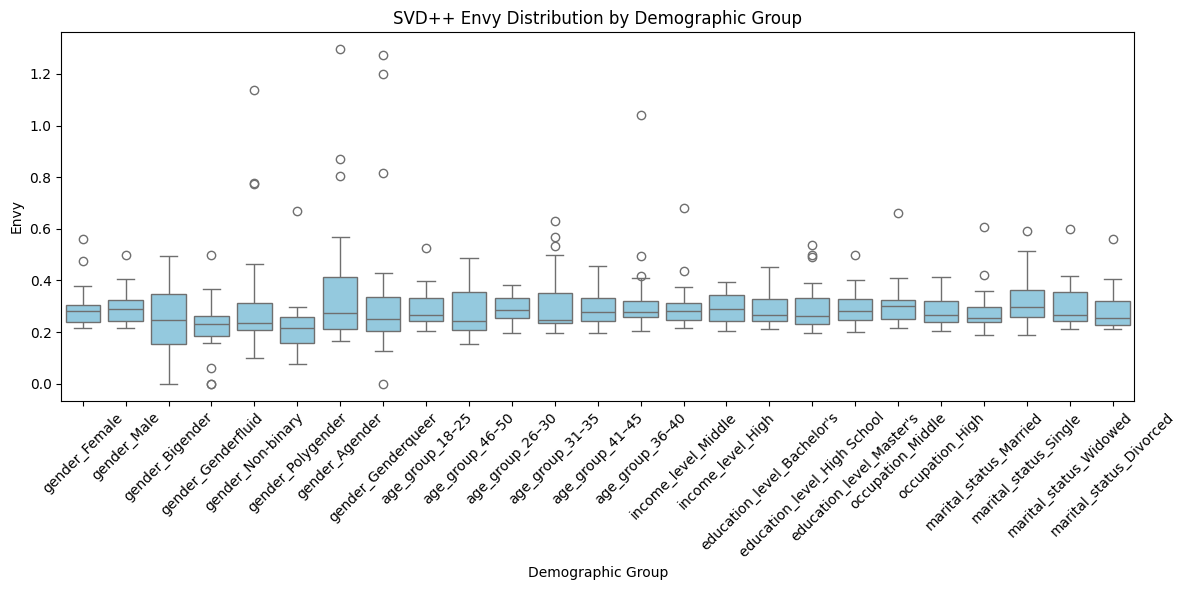

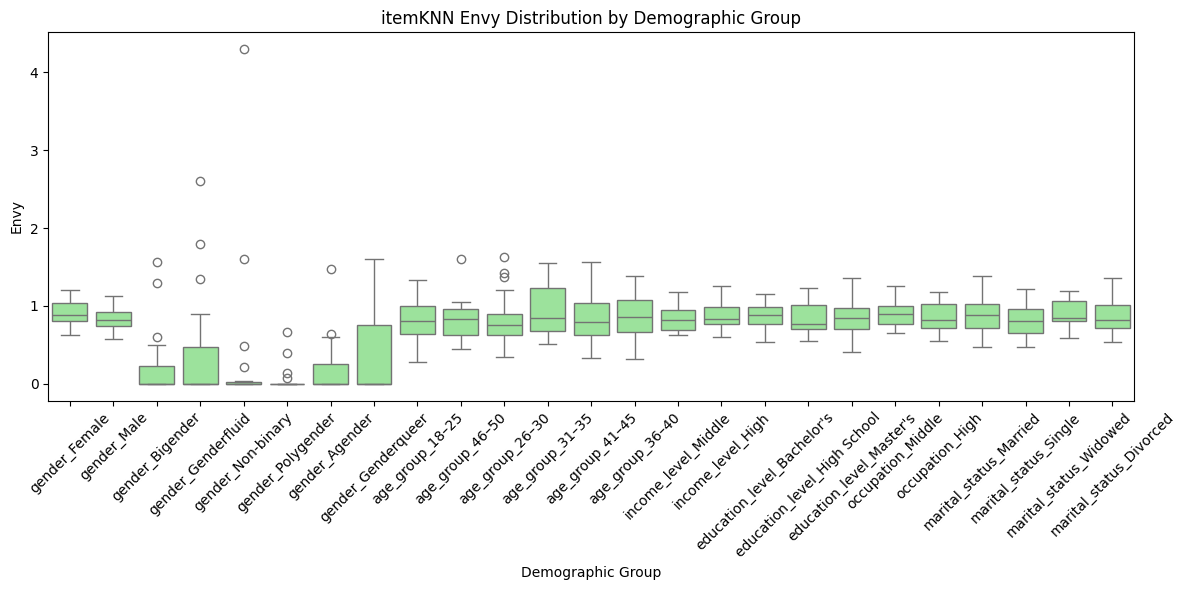

In [32]:
# Boxplot for SVD++ envy
plt.figure(figsize=(12, 6))
sns.boxplot(x='group_key', y='envy_SVDpp', data=envy_comparison_df, color='skyblue')
plt.title('SVD++ Envy Distribution by Demographic Group')
plt.xlabel('Demographic Group')
plt.ylabel('Envy')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Boxplot for itemKNN envy
plt.figure(figsize=(12, 6))
sns.boxplot(x='group_key', y='envy_itemknn', data=envy_comparison_df, color='lightgreen')
plt.title('itemKNN Envy Distribution by Demographic Group')
plt.xlabel('Demographic Group')
plt.ylabel('Envy')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


From these boxplots, SVD++ tends to have slightly higher median envy in many groups but with a narrower overall range, suggesting more uniform treatment across those groups. ItemKNN shows lower median envy for some groups but has greater variability (including outliers), indicating more uneven treatment within certain demographics.

---
**3) Absolute Difference (AD) for Group Fairness:**
---
Measuring the disparity between two groups (female and male)

In [33]:
def calculate_absolute_difference(predictions, customer_demographics, product_categories, gender_key="gender"):
    """
    Calculates Absolute Difference (AD) in predicted ratings between protected (female) 
    and unprotected (male) groups for each product category.

    Parameters:
        predictions (dict):
            Dictionary mapping customer IDs to a list of (category, predicted_rating) tuples.
        customer_demographics (dict):
            Dictionary mapping customer IDs to demographic attributes, including gender.
        product_categories (list):
            List of product categories to evaluate.
        gender_key (str):
            Key in demographic dict for gender. Default is "gender".

    Returns:
        dict: Mapping from product category to AD value (float), or None if one group is missing.
              Format: {category: abs_diff_value or None}
    """
    ad_by_category = {}

    for category in product_categories:
        ratings_male = []
        ratings_female = []

        for customer, recs in predictions.items():
            gender = customer_demographics.get(customer, {}).get(gender_key, "unknown").lower()
            if gender not in {"male", "female"}:
                continue

            for cat, rating in recs:
                if cat == category:
                    if gender == "male":
                        ratings_male.append(rating)
                    elif gender == "female":
                        ratings_female.append(rating)

        if ratings_male and ratings_female:
            avg_male = np.mean(ratings_male)
            avg_female = np.mean(ratings_female)
            ad_by_category[category] = abs(avg_male - avg_female)
        else:
            ad_by_category[category] = None  # Not enough data for comparison

    return ad_by_category

Calculating AD for models:

In [34]:
# Calculate absolute difference for each model
svdpp_ad = calculate_absolute_difference(
    predictions=svdpp_recommendations_dict,
    customer_demographics=customer_demographics,
    product_categories=product_categories,
    gender_key="gender"  # or the appropriate key if different
)

itemknn_ad = calculate_absolute_difference(
    predictions=itemknn_recommendations_dict,
    customer_demographics=customer_demographics,
    product_categories=product_categories,
    gender_key="gender"
)

Comparing the results:

In [35]:
# Convert the results into DataFrames for easier comparison
svdpp_ad_df = pd.DataFrame(list(svdpp_ad.items()), columns=['product_category', 'svdpp_absolute_difference'])
itemknn_ad_df = pd.DataFrame(list(itemknn_ad.items()), columns=['product_category', 'itemknn_absolute_difference'])

# Merge the two DataFrames on product_category
ad_comparison_df = pd.merge(svdpp_ad_df, itemknn_ad_df, on='product_category', how='outer')

print("Absolute Difference in Predicted Ratings by Gender (Fairness Metric):")
print(ad_comparison_df.head())

Absolute Difference in Predicted Ratings by Gender (Fairness Metric):
         product_category  svdpp_absolute_difference  \
0               Groceries                   0.103686   
1            Toys & Games                   0.009626   
2  Beauty & Personal Care                   0.000140   
3         Office Supplies                   0.028551   
4    Gardening & Outdoors                   0.122573   

   itemknn_absolute_difference  
0                     0.039025  
1                     0.182683  
2                     0.591547  
3                     0.296840  
4                     0.110990  


C:\Users\MelvanderMeij\AppData\Local\Temp\ipykernel_23524\3517471330.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Overall_Absolute_Difference', data=overall_df, palette='Set2')


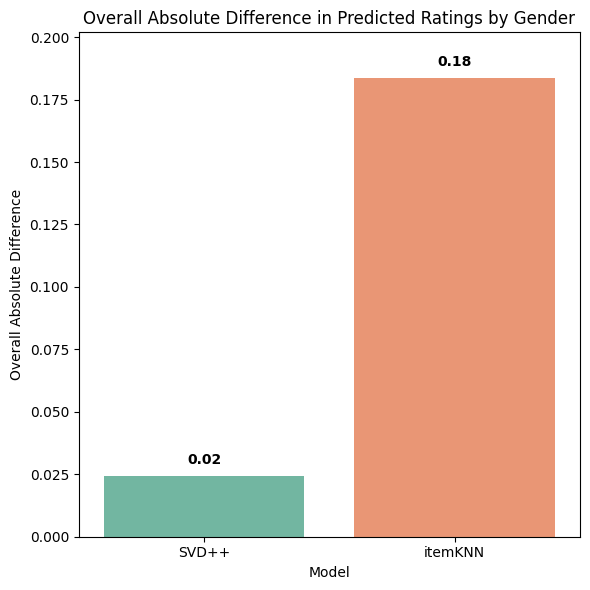

In [36]:
# Compute overall average AD for each model, ignoring None values
overall_svdpp_ad = np.mean([val for val in svdpp_ad.values() if val is not None])
overall_itemknn_ad = np.mean([val for val in itemknn_ad.values() if val is not None])

# Create a DataFrame for easy plotting
overall_df = pd.DataFrame({
    'Model': ['SVD++', 'itemKNN'],
    'Overall_Absolute_Difference': [overall_svdpp_ad, overall_itemknn_ad]
})

# Plot overall AD using a bar chart
plt.figure(figsize=(6, 6))
sns.barplot(x='Model', y='Overall_Absolute_Difference', data=overall_df, palette='Set2')
plt.title("Overall Absolute Difference in Predicted Ratings by Gender")
plt.ylabel("Overall Absolute Difference")
plt.xlabel("Model")

# Add value labels on top of each bar
for index, row in overall_df.iterrows():
    plt.text(index, row.Overall_Absolute_Difference + 0.005, f'{row.Overall_Absolute_Difference:.2f}', 
             horizontalalignment='center', size='medium', color='black', weight='semibold')

plt.ylim(0, overall_df['Overall_Absolute_Difference'].max() * 1.1)
plt.tight_layout()
plt.show()


The bar chart shows the overall average absolute difference in predicted ratings between male and female customers for each model. SVD++ has a much lower difference (0.02), indicating that its predictions for the two gender groups are more similar on average—suggesting higher fairness under this metric. Meanwhile, itemKNN has a higher difference (0.18), implying less consistent treatment between male and female customers in its recommendations.

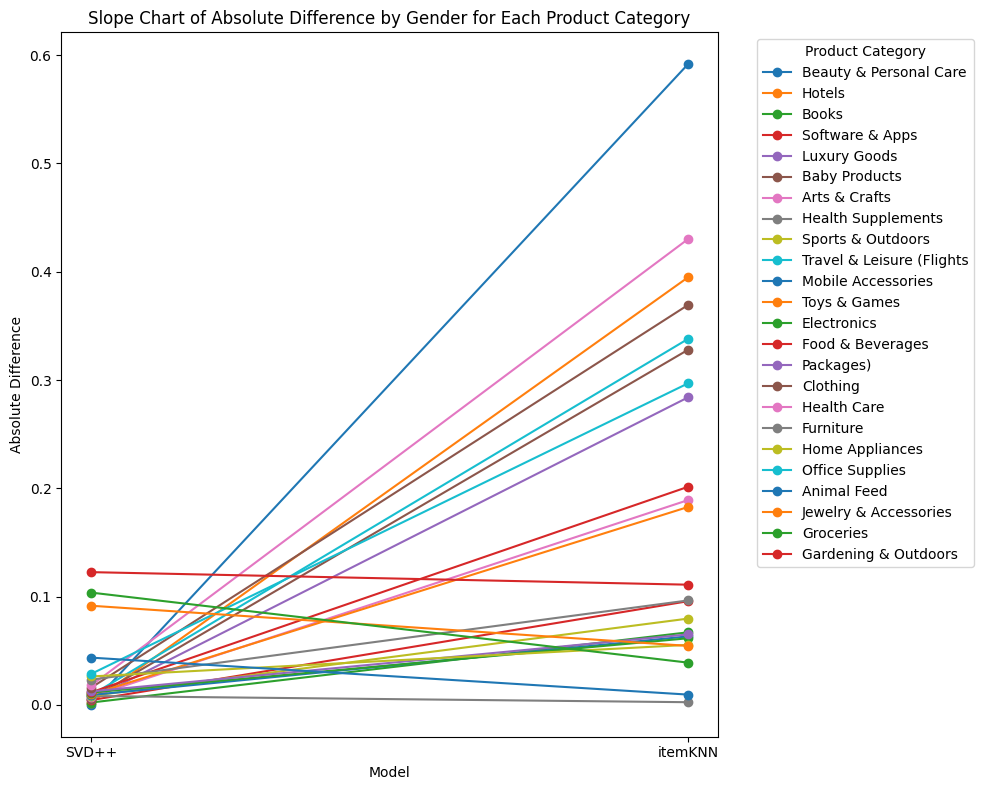

In [37]:
ad_comparison_df = ad_comparison_df.rename(columns={
    'svdpp_absolute_difference': 'SVD++', 
    'itemknn_absolute_difference': 'itemKNN'
})

# Melt the DataFrame so that 'Model' is a column and 'Absolute_Difference' is its value
melted_df = ad_comparison_df.melt(
    id_vars='product_category',
    value_vars=['SVD++', 'itemKNN'],
    var_name='Model',
    value_name='Absolute_Difference'
)

# Pivot the melted DataFrame to have product_category as the index and one column per model
slope_df = melted_df.pivot(index='product_category', columns='Model', values='Absolute_Difference').reset_index()

# Optionally, sort the DataFrame by one model's values
slope_df = slope_df.sort_values(by='SVD++')

# Now create the slope chart:
plt.figure(figsize=(10, 8))
for _, row in slope_df.iterrows():
    plt.plot(['SVD++', 'itemKNN'], [row['SVD++'], row['itemKNN']], marker='o', label=row['product_category'])
plt.xlabel('Model')
plt.ylabel('Absolute Difference')
plt.title('Slope Chart of Absolute Difference by Gender for Each Product Category')
plt.legend(title='Product Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


---
**4) Fraction of Satisfied Users (FSU) for Group Fairness:**
---
Measruing the percentage of users receiving fair treatment.

In [38]:
def compute_customer_utility(predictions, product_categories):
    """
    Computes the average predicted rating (utility) for each customer 
    based on their top-5 recommendations.

    Parameters:
        predictions (dict):
            Dictionary mapping customer IDs to a list of (category, predicted_rating) tuples.
        product_categories (list[str]):
            List of valid product categories to include.

    Returns:
        dict: Mapping of customer ID to average utility (float).
              Customers with no valid predictions are assigned np.nan.
    """
    utilities = {}

    for customer_id, recs in predictions.items():
        ratings = [rating for category, rating in recs if category in product_categories]
        utilities[customer_id] = np.mean(ratings) if ratings else np.nan

    return utilities

In [39]:
def compute_fraction_satisfied_by_group(utilities, customer_demographics, group_key):
    """
    Calculates the fraction of satisfied users within each demographic group.
    A user is considered satisfied if their utility is >= their group's average utility.

    Parameters:
        utilities (dict):
            Mapping from customer ID to their average predicted utility.
        customer_demographics (dict):
            Mapping from customer ID to demographic attributes.
        group_key (str):
            The demographic column to group by (e.g., 'gender').

    Returns:
        DataFrame: Group-level statistics including:
            - Number of customers
            - Group average utility
            - Number of satisfied users
            - Fraction satisfied
    """
    records = [
        {
            "CustomerID": customer,
            "Utility": util,
            "Group": customer_demographics.get(customer, {}).get(group_key, "Unknown")
        }
        for customer, util in utilities.items()
        if not np.isnan(util)
    ]

    df = pd.DataFrame(records)

    # Calculate group average utility
    group_avg = df.groupby("Group")["Utility"].mean().reset_index().rename(columns={"Utility": "Group_Avg"})
    df = df.merge(group_avg, on="Group", how="left")

    # Determine satisfaction
    df["Satisfied"] = df["Utility"] >= df["Group_Avg"]

    # Aggregate results per group
    summary = df.groupby("Group").agg(
        Num_Customers=("CustomerID", "count"),
        Group_Avg=("Group_Avg", "first"),
        Num_Satisfied=("Satisfied", "sum")
    ).reset_index()

    summary["Fraction_Satisfied"] = summary["Num_Satisfied"] / summary["Num_Customers"]

    return summary

Calculating FSU for the models based on gendder:

In [40]:
# For SVD++ predictions:
svdpp_utilities = compute_customer_utility(svdpp_recommendations_dict, product_categories)
svdpp_satisfaction = compute_fraction_satisfied_by_group(svdpp_utilities, customer_demographics, group_key='gender')

print("SVD++ Group Satisfaction (by Gender):")
print(svdpp_satisfaction.head())

# For itemKNN predictions:
itemknn_utilities = compute_customer_utility(itemknn_recommendations_dict, product_categories)
itemknn_satisfaction = compute_fraction_satisfied_by_group(itemknn_utilities, customer_demographics, group_key='gender')

print("itemKNN Group Satisfaction (by Gender):")
print(itemknn_satisfaction.head())

SVD++ Group Satisfaction (by Gender):
         Group  Num_Customers  Group_Avg  Num_Satisfied  Fraction_Satisfied
0      Agender             19   3.996716              8            0.421053
1     Bigender             20   3.897363              8            0.400000
2       Female            452   3.968538            175            0.387168
3  Genderfluid             17   3.936859              7            0.411765
4  Genderqueer             12   4.029646              5            0.416667
itemKNN Group Satisfaction (by Gender):
         Group  Num_Customers  Group_Avg  Num_Satisfied  Fraction_Satisfied
0      Agender             19   3.741936             11            0.578947
1     Bigender             20   3.668484              9            0.450000
2       Female            452   3.754337            224            0.495575
3  Genderfluid             17   3.648856              8            0.470588
4  Genderqueer             12   3.913359              5            0.416667


Comparing the results:

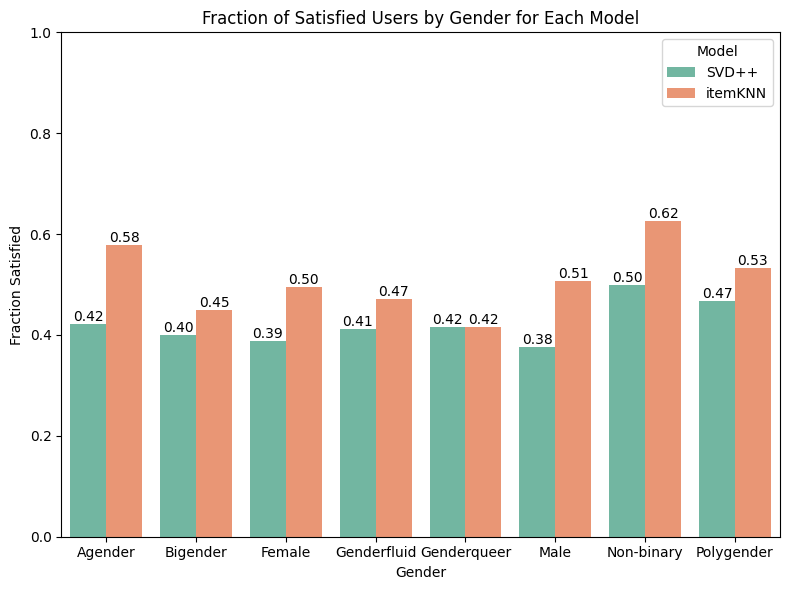

In [41]:
# First, add a column to indicate the model:
svdpp_satisfaction['Model'] = 'SVD++'
itemknn_satisfaction['Model'] = 'itemKNN'

# Concatenate the two DataFrames into one
combined_satisfaction = pd.concat([svdpp_satisfaction, itemknn_satisfaction])

# Create a grouped bar plot. For example, if your group key is gender:
plt.figure(figsize=(8,6))
sns.barplot(data=combined_satisfaction, 
            x='Group', 
            y='Fraction_Satisfied', 
            hue='Model', 
            palette='Set2')
plt.title('Fraction of Satisfied Users by Gender for Each Model')
plt.xlabel('Gender')
plt.ylabel('Fraction Satisfied')
plt.ylim(0, 1)  # Since fraction is between 0 and 1

# Add value labels on each bar
ax = plt.gca()
for container in ax.containers:
    ax.bar_label(container, fmt="%.2f", label_type='edge')

plt.tight_layout()
plt.show()


---

# Fairness metrics Mel

## Gini coefficient

In [42]:
def evaluate_gini_fairness_svdpp(svdpp_predictions, e_commerce_data, threshold=3.5, n=5, plot=True):
    """
    Evaluate fairness metrics for SVD++ recommendations.
    
    Parameters:
    -----------
    svdpp_predictions : DataFrame
        DataFrame containing predictions with columns: customer_id, purchase_category, predicted_rating
    e_commerce_data : DataFrame
        Original e-commerce data with gender information
    threshold : float
        Rating threshold to consider an item as recommended
    n : int
        Number of top recommendations to consider
    plot : bool
        Whether to generate visualization
        
    Returns:
    --------
    gini_coefficient : float
        Gini coefficient measuring recommendation distribution fairness
    precision_metrics : dict
        Precision metrics for different groups
    gender_metrics : dict
        Gender-specific metrics
    """
    # Create a mapping of customer_id to gender
    customer_gender_map = dict(zip(e_commerce_data['Customer_ID'], e_commerce_data['Gender']))
    
    # Get top-N recommendations for each user
    user_top_n_recommendations = {}
    
    for customer_id, group in svdpp_predictions.groupby('customer_id'):
        # Sort by predicted rating and get top N
        top_n = group.sort_values('predicted_rating', ascending=False).head(n)
        # Filter by threshold
        recommended = top_n[top_n['predicted_rating'] >= threshold]
        user_top_n_recommendations[customer_id] = list(recommended['purchase_category'])
    
    # Calculate recommendation frequency for each item
    item_frequencies = defaultdict(int)
    for recs in user_top_n_recommendations.values():
        for item in recs:
            item_frequencies[item] += 1
    
    # Sort items by frequency for Gini calculation
    sorted_freqs = sorted(item_frequencies.values())
    
    # Calculate Gini coefficient
    n_items = len(sorted_freqs)
    if n_items == 0:
        return 0, {}, {}
        
    cumulative_freqs = np.cumsum(sorted_freqs)
    total_freqs = cumulative_freqs[-1]
    
    # Avoid division by zero
    if total_freqs == 0:
        return 0, {}, {}
        
    gini_coefficient = 1 - (2 / n_items) * np.sum(cumulative_freqs / total_freqs)
    
    # Gender-specific metrics
    male_recs = {}
    female_recs = {}
    
    # Separate recommendations by gender
    for customer_id, recs in user_top_n_recommendations.items():
        if customer_id in customer_gender_map:
            gender = customer_gender_map[customer_id]
            if gender == 'Male':
                male_recs[customer_id] = recs
            elif gender == 'Female':
                female_recs[customer_id] = recs
    
    # Calculate gender-specific metrics
    male_item_frequencies = defaultdict(int)
    for recs in male_recs.values():
        for item in recs:
            male_item_frequencies[item] += 1
            
    female_item_frequencies = defaultdict(int)
    for recs in female_recs.values():
        for item in recs:
            female_item_frequencies[item] += 1
    
    # Calculate precision
    precision_metrics = {
        'all': len([r for recs in user_top_n_recommendations.values() for r in recs]) / 
                (len(user_top_n_recommendations) * n) if user_top_n_recommendations else 0,
        'male': len([r for recs in male_recs.values() for r in recs]) / 
                (len(male_recs) * n) if male_recs else 0,
        'female': len([r for recs in female_recs.values() for r in recs]) / 
                (len(female_recs) * n) if female_recs else 0
    }
    
    # Overall gender metrics
    gender_metrics = {
        'male_users': len(male_recs),
        'female_users': len(female_recs),
        'male_avg_recs_per_user': sum(len(recs) for recs in male_recs.values()) / len(male_recs) if male_recs else 0,
        'female_avg_recs_per_user': sum(len(recs) for recs in female_recs.values()) / len(female_recs) if female_recs else 0,
        'unique_items_male': len(male_item_frequencies),
        'unique_items_female': len(female_item_frequencies)
    }
    
    # Visualization
    if plot:
        plt.figure(figsize=(12, 6))
        
        # Lorenz curve
        plt.subplot(1, 2, 1)
        lorenz_x = np.arange(0, n_items + 1) / n_items
        lorenz_y = np.append([0], cumulative_freqs / total_freqs)
        plt.plot(lorenz_x, lorenz_y, label='Lorenz Curve')
        plt.plot([0, 1], [0, 1], 'k--', label='Perfect Equality')
        plt.xlabel('Cumulative Share of Items')
        plt.ylabel('Cumulative Share of Recommendations')
        plt.title(f'SVD++ Recommendation Distribution (Gini = {gini_coefficient:.4f})')
        plt.legend()
        
        # Gender comparison
        plt.subplot(1, 2, 2)
        gender_data = [gender_metrics['male_avg_recs_per_user'], gender_metrics['female_avg_recs_per_user']]
        plt.bar(['Male', 'Female'], gender_data)
        plt.ylabel('Average Recommendations per User')
        plt.title('Gender Comparison in Recommendations')
        
        plt.tight_layout()
        plt.show()
    
    return gini_coefficient, precision_metrics, gender_metrics

In [43]:
def evaluate_gini_fairness_itemknn(itemknn_predictions, e_commerce_data, threshold=3.5, n=5, plot=True):
    """
    Evaluate fairness metrics for ItemKNN recommendations.
    
    Parameters:
    -----------
    itemknn_predictions : DataFrame
        DataFrame containing predictions with columns: customer_id, purchase_category, true_rating, predicted_rating
    e_commerce_data : DataFrame
        Original e-commerce data with gender information
    threshold : float
        Rating threshold to consider an item as recommended
    n : int
        Number of top recommendations to consider
    plot : bool
        Whether to generate visualization
        
    Returns:
    --------
    gini_coefficient : float
        Gini coefficient measuring recommendation distribution fairness
    precision_metrics : dict
        Precision metrics for different groups
    gender_metrics : dict
        Gender-specific metrics
    """
    # Filter out NaN predictions and ensure proper column names
    valid_predictions = itemknn_predictions.dropna(subset=['predicted_rating']).copy()
    
    # Create a mapping of customer_id to gender
    customer_gender_map = dict(zip(e_commerce_data['Customer_ID'], e_commerce_data['Gender']))
    
    # Get top-N recommendations for each user
    user_top_n_recommendations = {}
    
    for customer_id, group in valid_predictions.groupby('customer_id'):
        # Sort by predicted rating and get top N
        top_n = group.sort_values('predicted_rating', ascending=False).head(n)
        # Filter by threshold
        recommended = top_n[top_n['predicted_rating'] >= threshold]
        user_top_n_recommendations[customer_id] = list(recommended['purchase_category'])
    
    # Calculate recommendation frequency for each item
    item_frequencies = defaultdict(int)
    for recs in user_top_n_recommendations.values():
        for item in recs:
            item_frequencies[item] += 1
    
    # Sort items by frequency for Gini calculation
    sorted_freqs = sorted(item_frequencies.values())
    
    # Calculate Gini coefficient
    n_items = len(sorted_freqs)
    if n_items == 0:
        return 0, {}, {}
        
    cumulative_freqs = np.cumsum(sorted_freqs)
    total_freqs = cumulative_freqs[-1]
    
    # Avoid division by zero
    if total_freqs == 0:
        return 0, {}, {}
        
    gini_coefficient = 1 - (2 / n_items) * np.sum(cumulative_freqs / total_freqs)
    
    # Gender-specific metrics
    male_recs = {}
    female_recs = {}
    
    # Separate recommendations by gender
    for customer_id, recs in user_top_n_recommendations.items():
        if customer_id in customer_gender_map:
            gender = customer_gender_map[customer_id]
            if gender == 'Male':
                male_recs[customer_id] = recs
            elif gender == 'Female':
                female_recs[customer_id] = recs
    
    # Calculate gender-specific metrics
    male_item_frequencies = defaultdict(int)
    for recs in male_recs.values():
        for item in recs:
            male_item_frequencies[item] += 1
            
    female_item_frequencies = defaultdict(int)
    for recs in female_recs.values():
        for item in recs:
            female_item_frequencies[item] += 1
    
    # Calculate precision
    precision_metrics = {
        'all': len([r for recs in user_top_n_recommendations.values() for r in recs]) / 
                (len(user_top_n_recommendations) * n) if user_top_n_recommendations else 0,
        'male': len([r for recs in male_recs.values() for r in recs]) / 
                (len(male_recs) * n) if male_recs else 0,
        'female': len([r for recs in female_recs.values() for r in recs]) / 
                (len(female_recs) * n) if female_recs else 0
    }
    
    # Overall gender metrics
    gender_metrics = {
        'male_users': len(male_recs),
        'female_users': len(female_recs),
        'male_avg_recs_per_user': sum(len(recs) for recs in male_recs.values()) / len(male_recs) if male_recs else 0,
        'female_avg_recs_per_user': sum(len(recs) for recs in female_recs.values()) / len(female_recs) if female_recs else 0,
        'unique_items_male': len(male_item_frequencies),
        'unique_items_female': len(female_item_frequencies)
    }
    
    # Visualization
    if plot:
        plt.figure(figsize=(12, 6))
        
        # Lorenz curve
        plt.subplot(1, 2, 1)
        lorenz_x = np.arange(0, n_items + 1) / n_items
        lorenz_y = np.append([0], cumulative_freqs / total_freqs)
        plt.plot(lorenz_x, lorenz_y, label='Lorenz Curve')
        plt.plot([0, 1], [0, 1], 'k--', label='Perfect Equality')
        plt.xlabel('Cumulative Share of Items')
        plt.ylabel('Cumulative Share of Recommendations')
        plt.title(f'ItemKNN Recommendation Distribution (Gini = {gini_coefficient:.4f})')
        plt.legend()
        
        # Gender comparison
        plt.subplot(1, 2, 2)
        gender_data = [gender_metrics['male_avg_recs_per_user'], gender_metrics['female_avg_recs_per_user']]
        plt.bar(['Male', 'Female'], gender_data)
        plt.ylabel('Average Recommendations per User')
        plt.title('Gender Comparison in Recommendations')
        
        plt.tight_layout()
        plt.show()
    
    return gini_coefficient, precision_metrics, gender_metrics

In [44]:
def compare_fairness_metrics(metrics_dict):
    """
    Compare fairness metrics between different algorithms.
    
    Parameters:
    -----------
    metrics_dict : dict
        Dictionary with algorithm names as keys and tuples of 
        (gini_coefficient, precision_metrics, gender_metrics) as values
    """
    # Extract algorithm names
    algo_names = list(metrics_dict.keys())
    
    # Create subplots for comparison
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot Gini coefficients
    gini_values = [metrics_dict[algo][0] for algo in algo_names]
    axes[0, 0].bar(algo_names, gini_values)
    axes[0, 0].set_title('Gini Coefficient Comparison')
    axes[0, 0].set_ylabel('Gini Coefficient')
    
    # Plot precision metrics
    all_precision = [metrics_dict[algo][1]['all'] for algo in algo_names]
    male_precision = [metrics_dict[algo][1]['male'] for algo in algo_names]
    female_precision = [metrics_dict[algo][1]['female'] for algo in algo_names]
    
    bar_width = 0.25
    r1 = np.arange(len(algo_names))
    r2 = [x + bar_width for x in r1]
    r3 = [x + bar_width for x in r2]
    
    axes[0, 1].bar(r1, all_precision, width=bar_width, label='All')
    axes[0, 1].bar(r2, male_precision, width=bar_width, label='Male')
    axes[0, 1].bar(r3, female_precision, width=bar_width, label='Female')
    axes[0, 1].set_xticks([r + bar_width for r in range(len(algo_names))])
    axes[0, 1].set_xticklabels(algo_names)
    axes[0, 1].set_title('Precision Comparison')
    axes[0, 1].set_ylabel('Precision')
    axes[0, 1].legend()
    
    # Plot gender distribution
    male_users = [metrics_dict[algo][2]['male_users'] for algo in algo_names]
    female_users = [metrics_dict[algo][2]['female_users'] for algo in algo_names]
    
    axes[1, 0].bar(r1, male_users, width=bar_width, label='Male Users')
    axes[1, 0].bar(r2, female_users, width=bar_width, label='Female Users')
    axes[1, 0].set_xticks([r + bar_width/2 for r in range(len(algo_names))])
    axes[1, 0].set_xticklabels(algo_names)
    axes[1, 0].set_title('User Gender Distribution')
    axes[1, 0].set_ylabel('Number of Users')
    axes[1, 0].legend()
    
    # Plot average recommendations per gender
    male_avg_recs = [metrics_dict[algo][2]['male_avg_recs_per_user'] for algo in algo_names]
    female_avg_recs = [metrics_dict[algo][2]['female_avg_recs_per_user'] for algo in algo_names]
    
    axes[1, 1].bar(r1, male_avg_recs, width=bar_width, label='Male Avg. Recs')
    axes[1, 1].bar(r2, female_avg_recs, width=bar_width, label='Female Avg. Recs')
    axes[1, 1].set_xticks([r + bar_width/2 for r in range(len(algo_names))])
    axes[1, 1].set_xticklabels(algo_names)
    axes[1, 1].set_title('Average Recommendations per User')
    axes[1, 1].set_ylabel('Avg. Recommendations')
    axes[1, 1].legend()
    
    plt.tight_layout()
    plt.show()
    
    # Print additional metrics
    print("\n==== Detailed Fairness Metrics ====")
    for algo in algo_names:
        gini, precision, gender = metrics_dict[algo]
        print(f"\n{algo}:")
        print(f"  Gini Coefficient: {gini:.4f}")
        print(f"  Precision (All): {precision['all']:.4f}")
        print(f"  Precision (Male): {precision['male']:.4f}")
        print(f"  Precision (Female): {precision['female']:.4f}")
        print(f"  Gender Distribution: {gender['male_users']} male, {gender['female_users']} female users")
        print(f"  Avg. Recs per User: {gender['male_avg_recs_per_user']:.2f} (male), {gender['female_avg_recs_per_user']:.2f} (female)")
        print(f"  Unique Items Recommended: {gender['unique_items_male']} (male), {gender['unique_items_female']} (female)")

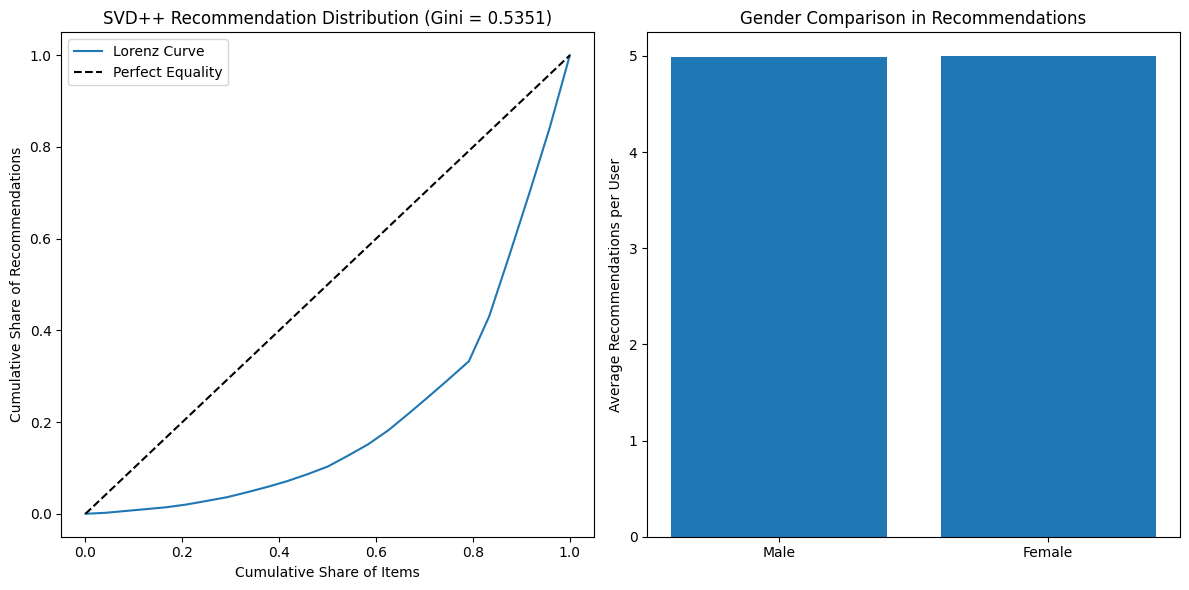

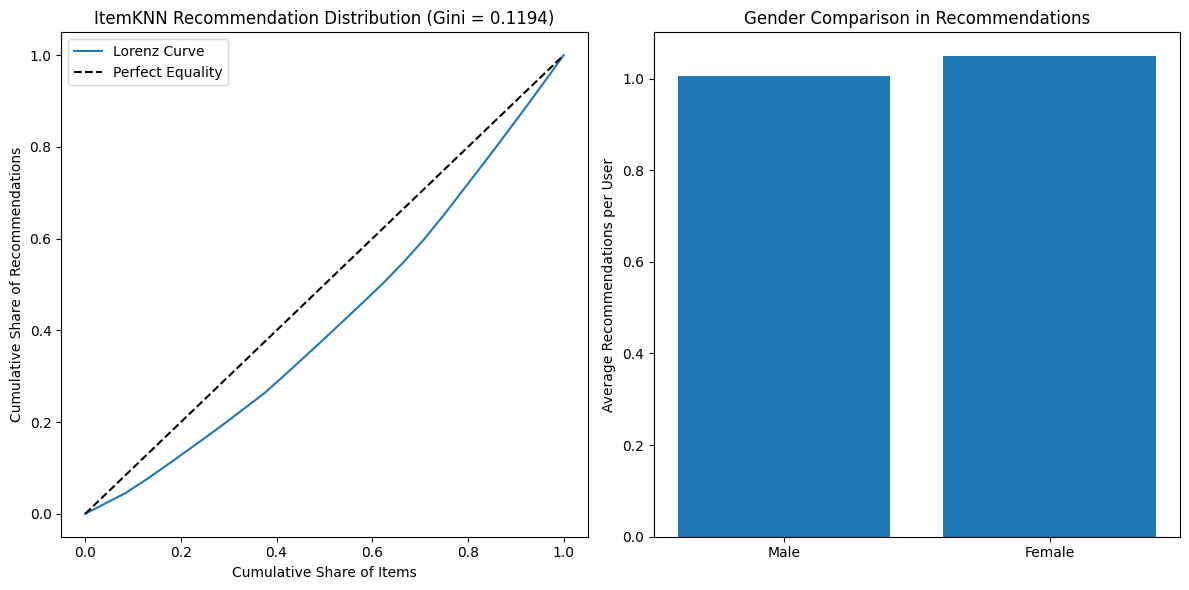

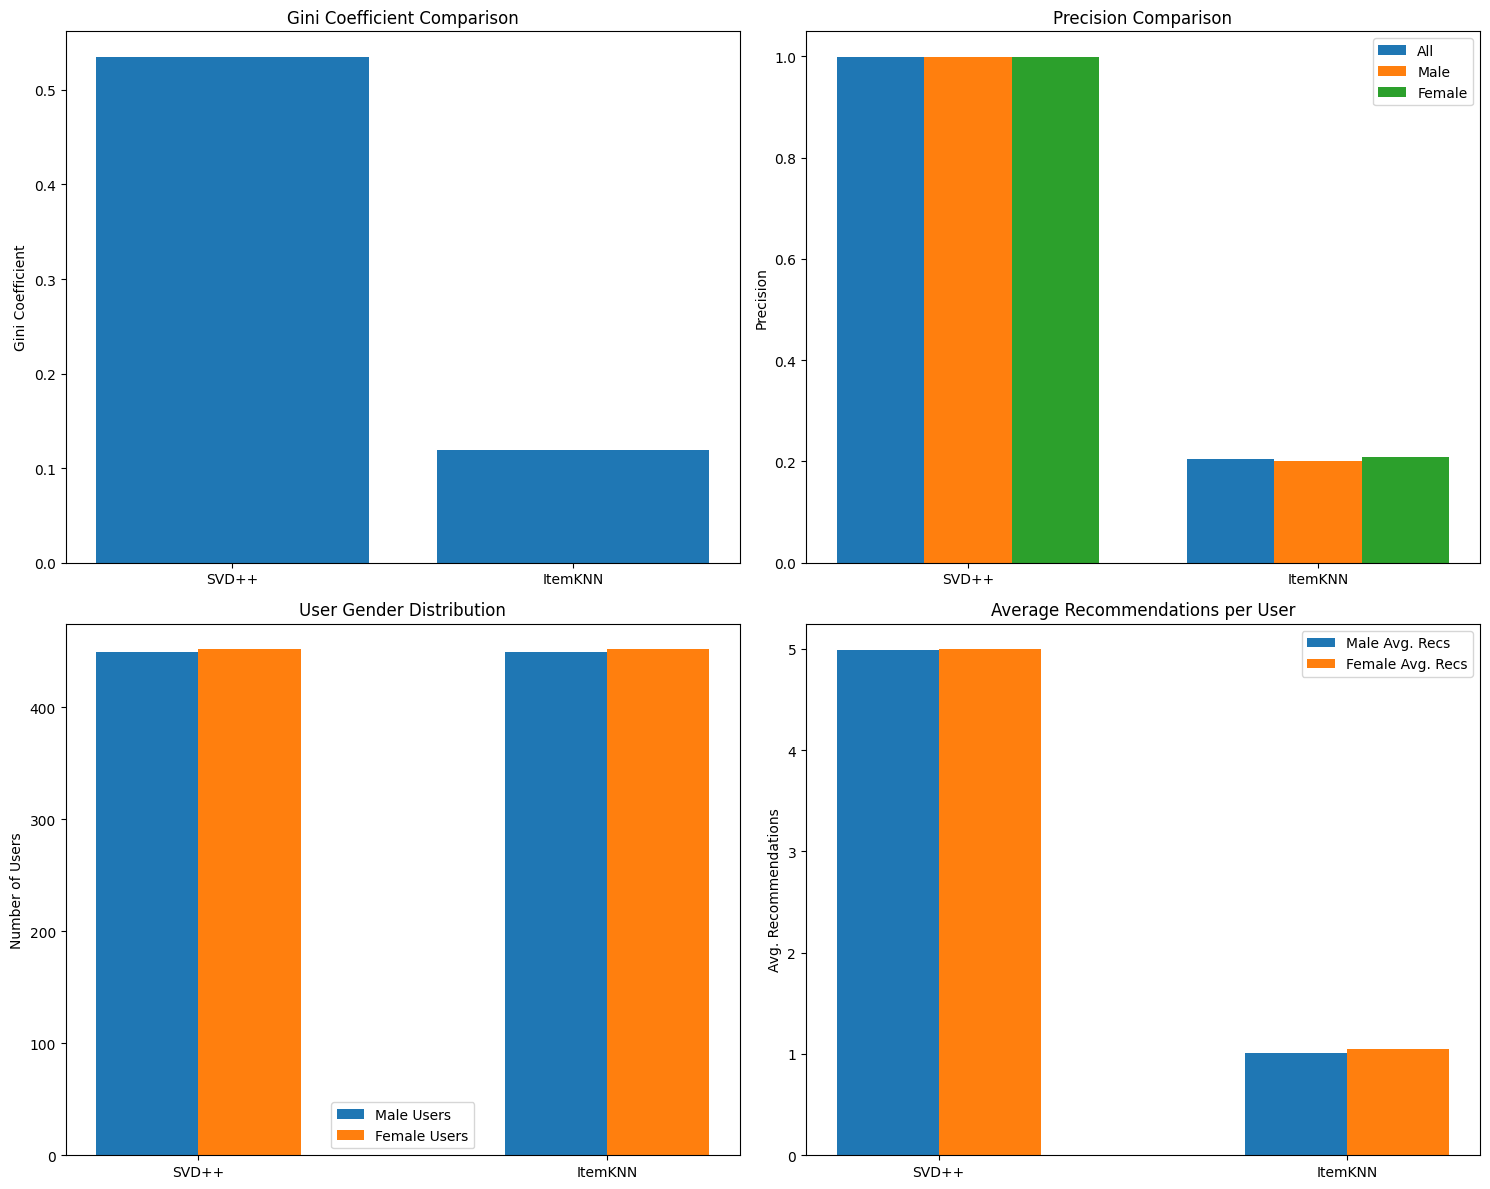


==== Detailed Fairness Metrics ====

SVD++:
  Gini Coefficient: 0.5351
  Precision (All): 0.9984
  Precision (Male): 0.9982
  Precision (Female): 0.9991
  Gender Distribution: 449 male, 452 female users
  Avg. Recs per User: 4.99 (male), 5.00 (female)
  Unique Items Recommended: 24 (male), 24 (female)

ItemKNN:
  Gini Coefficient: 0.1194
  Precision (All): 0.2058
  Precision (Male): 0.2013
  Precision (Female): 0.2097
  Gender Distribution: 449 male, 452 female users
  Avg. Recs per User: 1.01 (male), 1.05 (female)
  Unique Items Recommended: 24 (male), 24 (female)


In [45]:
# For SVD++ model
gini_svdpp, precisions_svdpp, gender_metrics_svdpp = evaluate_gini_fairness_svdpp(
    svdpp_predictions=svdpp_predictions,
    e_commerce_data=e_commerce,
    threshold=3.5,
    n=5,
    plot=True
)

# For ItemKNN model
gini_itemknn, precisions_itemknn, gender_metrics_itemknn = evaluate_gini_fairness_itemknn(
    itemknn_predictions=itemknn_predictions,
    e_commerce_data=e_commerce,
    threshold=3.5,
    n=5,
    plot=True
)

# Compare the fairness metrics
compare_fairness_metrics({
    'SVD++': (gini_svdpp, precisions_svdpp, gender_metrics_svdpp),
    'ItemKNN': (gini_itemknn, precisions_itemknn, gender_metrics_itemknn)
})

## Bottom N-average

In [46]:
def calculate_bottom_n_average(data, n=10, column=None):
    """
    Calculate the average of the bottom N values in a dataset.
    
    Parameters:
    -----------
    data : array-like, Series, or DataFrame
        The dataset to analyze
    n : int, default 10
        Number of bottom values to include in the average
    column : str, optional
        If data is a DataFrame, the column to use for calculation
        
    Returns:
    --------
    float
        The average of the bottom N values
    list
        The bottom N values used in the calculation
    """
    # Handle different input types
    if isinstance(data, pd.DataFrame):
        if column is None:
            raise ValueError("Column name must be specified when input is a DataFrame")
        values = data[column].values
    elif isinstance(data, pd.Series):
        values = data.values
    else:
        values = np.array(data)
    
    # Make sure n is not larger than the dataset
    n = min(n, len(values))
    
    # Sort the values and get the bottom n
    sorted_values = np.sort(values)
    bottom_n = sorted_values[:n]
    
    # Calculate the average
    bottom_n_avg = np.mean(bottom_n)
    
    return bottom_n_avg, bottom_n.tolist()

In [47]:
def calculate_customer_average_ratings(predictions_df, customer_id_col='customer_id', rating_col='predicted_rating'):
    """
    Calculate the average predicted rating for each customer.
    
    Parameters:
    -----------
    predictions_df : pd.DataFrame
        DataFrame containing predictions
    customer_id_col : str, default='customer_id'
        Column containing customer identifiers
    rating_col : str, default='predicted_rating'
        Column containing the predicted values
        
    Returns:
    --------
    pd.Series
        Series containing average value for each customer
    """
    return predictions_df.groupby(customer_id_col)[rating_col].mean()

In [48]:
def plot_bottom_n_comparison(data, ns=[5, 10, 20, 50], column=None, title="Bottom N Average Comparison"):
    """
    Plot a comparison of different bottom N averages.
    
    Parameters:
    -----------
    data : array-like, Series, or DataFrame
        The dataset to analyze
    ns : list of int, default [5, 10, 20, 50]
        List of N values to compare
    column : str, optional
        If data is a DataFrame, the column to use for calculation
    title : str, default "Bottom N Average Comparison"
        Title for the plot
    """
    averages = []
    labels = []
    
    # Calculate averages for different values of n
    for n in ns:
        avg, _ = calculate_bottom_n_average(data, n, column)
        averages.append(avg)
        labels.append(f"Bottom {n}")
    
    # Add overall average for comparison
    if isinstance(data, pd.DataFrame) and column is not None:
        overall_avg = data[column].mean()
    elif isinstance(data, pd.Series):
        overall_avg = data.mean()
    else:
        overall_avg = np.mean(data)
    
    averages.append(overall_avg)
    labels.append("Overall")
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    bars = plt.bar(labels, averages, color=['#ff9999', '#66b3ff', '#99ff99', '#c2c2f0', '#ffcc99'])
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.2f}',
                 ha='center', va='bottom')
    
    plt.title(title)
    plt.ylabel("Average Predicted Rating")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    return plt.gcf()

In [49]:
def plot_customer_rating_distribution(customer_avg_ratings, bins=20):
    """
    Plot the distribution of average ratings across customers.
    
    Parameters:
    -----------
    customer_avg_ratings : pd.Series
        Series containing average rating for each customer
    bins : int, default=20
        Number of bins for the histogram
        
    Returns:
    --------
    matplotlib.figure.Figure
        The created figure
    """
    plt.figure(figsize=(10, 6))
    
    # Plot histogram of customer average ratings
    plt.hist(customer_avg_ratings, bins=bins, alpha=0.7, color='skyblue', edgecolor='black')
    
    # Add lines for overall average and bottom-N averages
    overall_avg = customer_avg_ratings.mean()
    plt.axvline(overall_avg, color='red', linestyle='--', linewidth=2, label=f'Overall Average: {overall_avg:.2f}')
    
    # Add bottom-10% average
    bottom_10_percent = len(customer_avg_ratings) // 10
    bottom_n_avg, _ = calculate_bottom_n_average(customer_avg_ratings, bottom_10_percent)
    plt.axvline(bottom_n_avg, color='green', linestyle='--', linewidth=2, 
                label=f'Bottom 10% Average: {bottom_n_avg:.2f}')
    
    plt.title('Distribution of Average Predicted Ratings Across Customers')
    plt.xlabel('Average Predicted Rating')
    plt.ylabel('Number of Customers')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    
    return plt.gcf()

In [50]:
def analyze_bottom_n_by_gender(customer_avg_ratings, e_commerce_data, percent_ns=[1, 5, 10, 20]):
    """
    Analyze bottom-N fairness metric by gender.
    
    Parameters:
    -----------
    customer_avg_ratings : pd.Series
        Series containing average predicted ratings for each customer
    e_commerce_data : pd.DataFrame
        E-commerce dataset with customer demographic information
    percent_ns : list, default=[1, 5, 10, 20]
        List of percentage values to analyze
        
    Returns:
    --------
    dict
        Dictionary containing gender-based analysis results
    """
    # Create customer ID to gender mapping
    customer_gender = dict(zip(e_commerce_data['Customer_ID'], e_commerce_data['Gender']))
    
    # Group customer ratings by gender
    gender_ratings = defaultdict(list)
    for customer_id, avg_rating in customer_avg_ratings.items():
        if customer_id in customer_gender:
            gender = customer_gender[customer_id]
            gender_ratings[gender].append(avg_rating)
    
    # Convert lists to Series for easier analysis
    gender_series = {gender: pd.Series(ratings) for gender, ratings in gender_ratings.items()}
    
    # Calculate gender-specific bottom-N averages
    gender_results = {}
    
    print("\n=== Gender-Based Bottom-N Analysis ===")
    
    for gender, ratings in gender_series.items():
        gender_results[gender] = {}
        
        # Number of customers in this gender
        num_customers = len(ratings)
        
        if num_customers < 5:  # Skip if too few customers
            print(f"{gender}: Only {num_customers} customers - not enough for reliable analysis")
            continue
            
        print(f"\n{gender} (n={num_customers} customers):")
        
        # Overall average
        overall_avg = ratings.mean()
        gender_results[gender]['overall_avg'] = overall_avg
        print(f"Overall average: {overall_avg:.4f}")
        
        # Calculate bottom-N for each percentage
        for p in percent_ns:
            n = max(1, int(num_customers * p / 100))
            bottom_n_avg, _ = calculate_bottom_n_average(ratings, n)
            gender_results[gender][f'bottom_{p}percent_avg'] = bottom_n_avg
            
            # Calculate disparity
            disparity = overall_avg - bottom_n_avg
            disparity_percent = (disparity / overall_avg) * 100
            gender_results[gender][f'disparity_{p}percent'] = disparity
            gender_results[gender][f'disparity_{p}percent_ratio'] = disparity_percent
            
            print(f"Bottom {p}% ({n} customers) average: {bottom_n_avg:.4f}")
            print(f"  Disparity: {disparity:.4f} ({disparity_percent:.1f}%)")
    
    # Create comparison plot for the largest gender groups
    main_genders = sorted([(gender, len(ratings)) for gender, ratings in gender_series.items()], 
                          key=lambda x: x[1], reverse=True)[:3]
    
    if len(main_genders) >= 2:
        compare_bottom_n_across_genders(gender_series, [g[0] for g in main_genders], percent_ns)
    
    return gender_results

In [51]:
def compare_bottom_n_across_genders(gender_series, genders_to_compare, percent_ns=[1, 5, 10, 20]):
    """
    Compare bottom-N averages across different gender groups.
    
    Parameters:
    -----------
    gender_series : dict
        Dictionary mapping gender to Series of customer ratings
    genders_to_compare : list
        List of genders to include in the comparison
    percent_ns : list, default=[1, 5, 10, 20]
        List of percentage values to analyze
    """
    plt.figure(figsize=(12, 6))
    bar_width = 0.2
    index = np.arange(len(percent_ns) + 1)  # +1 for overall average
    
    # Colors for different genders
    colors = ['#ff9999', '#66b3ff', '#99ff99', '#c2c2f0', '#ffcc99']
    
    for i, gender in enumerate(genders_to_compare):
        ratings = gender_series[gender]
        overall_avg = ratings.mean()
        
        # Calculate averages for each percentage
        averages = []
        for p in percent_ns:
            n = max(1, int(len(ratings) * p / 100))
            avg, _ = calculate_bottom_n_average(ratings, n)
            averages.append(avg)
        
        # Add overall average
        averages.append(overall_avg)
        
        # Create labels for x-axis
        labels = [f"Bottom {p}%" for p in percent_ns] + ["Overall"]
        
        # Plot bars
        plt.bar(index + i*bar_width, averages, bar_width,
                 label=f'{gender} (n={len(ratings)})',
                 color=colors[i % len(colors)])
    
    plt.xlabel('Customer Group')
    plt.ylabel('Average Predicted Rating')
    plt.title('Bottom-N Averages by Gender')
    plt.xticks(index + bar_width*(len(genders_to_compare)-1)/2, labels)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

In [52]:
def compare_bottom_n_across_algorithms(metrics_dict, percent_ns=[1, 5, 10, 20], figsize=(12, 6)):
    """
    Compare bottom-N fairness metrics across different recommendation algorithms.
    
    Parameters:
    -----------
    metrics_dict : dict
        Dictionary mapping algorithm names to their bottom-N results
    percent_ns : list, default=[1, 5, 10, 20]
        List of percentage values to compare
    figsize : tuple, default=(12, 6)
        Figure size (width, height) in inches
    """
    # Extract algorithm names
    algorithms = list(metrics_dict.keys())
    
    # Create DataFrame for plotting
    data = []
    
    # Add overall averages
    for algo, results in metrics_dict.items():
        data.append({
            'Algorithm': algo,
            'Metric': 'Overall',
            'Value': results['overall_avg']
        })
    
    # Add bottom-N averages
    for algo, results in metrics_dict.items():
        for p in percent_ns:
            data.append({
                'Algorithm': algo,
                'Metric': f'Bottom {p}%',
                'Value': results[f'bottom_{p}percent_avg']
            })
    
    df = pd.DataFrame(data)
    
    # Plot
    plt.figure(figsize=figsize)
    
    # Create grouped bar chart
    metrics = ['Overall'] + [f'Bottom {p}%' for p in percent_ns]
    x = np.arange(len(algorithms))
    width = 0.8 / len(metrics)
    
    for i, metric in enumerate(metrics):
        metric_data = df[df['Metric'] == metric]
        offsets = [-0.4 + (i+0.5)*width for _ in range(len(algorithms))]
        
        bars = plt.bar(x + np.array(offsets), metric_data['Value'], width, label=metric)
        
        # Add value labels
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                     f'{height:.2f}', ha='center', va='bottom', fontsize=8)
    
    plt.xlabel('Algorithm')
    plt.ylabel('Average Predicted Rating')
    plt.title('Bottom-N Fairness Comparison Across Algorithms')
    plt.xticks(x, algorithms)
    plt.legend(title='Metric')
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [53]:
def evaluate_bottom_n_fairness_svdpp(svdpp_predictions, ns=[5, 10, 20, 50], e_commerce_data=None):
    """
    Evaluate bottom-N average as an individual fairness metric for SVD++ model.
    
    Parameters:
    -----------
    svdpp_predictions : pd.DataFrame
        DataFrame with customer_id, purchase_category, and predicted_rating columns
    ns : list, default=[5, 10, 20, 50]
        List of N values to analyze
    e_commerce_data : pd.DataFrame, optional
        E-commerce dataset with gender information
    
    Returns:
    --------
    dict
        Dictionary containing bottom-N analysis results
    """
    results = {}
    
    # Calculate average rating per customer
    customer_avg_ratings = calculate_customer_average_ratings(svdpp_predictions)
    
    # Number of customers
    num_customers = len(customer_avg_ratings)
    
    # Calculate percentage-based N values
    percent_ns = [1, 5, 10, 20]
    count_ns = [max(1, int(num_customers * p / 100)) for p in percent_ns]
    
    print("=== Bottom-N Average Individual Fairness Metric (SVD++) ===")
    print(f"Total number of customers: {num_customers}")
    
    # Fixed-count bottom N
    for n in ns:
        if n < num_customers:
            bottom_n_avg, bottom_n_values = calculate_bottom_n_average(customer_avg_ratings, n)
            print(f"Bottom {n} customers average: {bottom_n_avg:.4f}")
            results[f'bottom_{n}_avg'] = bottom_n_avg
    
    # Percentage-based bottom N
    for p, n in zip(percent_ns, count_ns):
        bottom_n_avg, bottom_n_values = calculate_bottom_n_average(customer_avg_ratings, n)
        print(f"Bottom {p}% of customers ({n} customers) average: {bottom_n_avg:.4f}")
        results[f'bottom_{p}percent_avg'] = bottom_n_avg
    
    # Overall average for comparison
    overall_avg = customer_avg_ratings.mean()
    print(f"Overall average across all customers: {overall_avg:.4f}")
    results['overall_avg'] = overall_avg
    
    # Calculate disparities
    for p in percent_ns:
        disparity = overall_avg - results[f'bottom_{p}percent_avg']
        disparity_percent = (disparity / overall_avg) * 100
        print(f"Disparity between overall and bottom {p}%: {disparity:.4f} ({disparity_percent:.1f}%)")
        results[f'disparity_{p}percent'] = disparity
        results[f'disparity_{p}percent_ratio'] = disparity_percent
    
    # Plot bottom-N comparison
    plot_bottom_n_comparison(customer_avg_ratings, count_ns, 
                            title=f"Bottom N% Customers Average Rating Comparison (SVD++)")
    plt.show()
    
    # Plot distribution of customer average ratings
    plot_customer_rating_distribution(customer_avg_ratings)
    plt.show()
    
    # Gender-based bottom-N analysis if e-commerce data is provided
    if e_commerce_data is not None:
        gender_results = analyze_bottom_n_by_gender(customer_avg_ratings, e_commerce_data, percent_ns)
        results['gender_analysis'] = gender_results
    
    # Store the full customer average ratings for further analysis
    results['customer_avg_ratings'] = customer_avg_ratings
    
    return results

In [54]:
def evaluate_bottom_n_fairness_itemknn(itemknn_predictions, ns=[5, 10, 20, 50], e_commerce_data=None):
    """
    Evaluate bottom-N average as an individual fairness metric for ItemKNN model.
    
    Parameters:
    -----------
    itemknn_predictions : pd.DataFrame
        DataFrame with purchase_category, customer_id, true_rating, and predicted_rating columns
    ns : list, default=[5, 10, 20, 50]
        List of N values to analyze
    e_commerce_data : pd.DataFrame, optional
        E-commerce dataset with gender information
    
    Returns:
    --------
    dict
        Dictionary containing bottom-N analysis results
    """
    results = {}
    
    # Drop rows with NaN predicted ratings
    valid_predictions = itemknn_predictions.dropna(subset=['predicted_rating']).copy()
    
    # Calculate average rating per customer
    customer_avg_ratings = calculate_customer_average_ratings(
        valid_predictions, 
        customer_id_col='customer_id', 
        rating_col='predicted_rating'
    )
    
    # Number of customers
    num_customers = len(customer_avg_ratings)
    
    # Calculate percentage-based N values
    percent_ns = [1, 5, 10, 20]
    count_ns = [max(1, int(num_customers * p / 100)) for p in percent_ns]
    
    print("=== Bottom-N Average Individual Fairness Metric (ItemKNN) ===")
    print(f"Total number of customers: {num_customers}")
    
    # Fixed-count bottom N
    for n in ns:
        if n < num_customers:
            bottom_n_avg, bottom_n_values = calculate_bottom_n_average(customer_avg_ratings, n)
            print(f"Bottom {n} customers average: {bottom_n_avg:.4f}")
            results[f'bottom_{n}_avg'] = bottom_n_avg
    
    # Percentage-based bottom N
    for p, n in zip(percent_ns, count_ns):
        bottom_n_avg, bottom_n_values = calculate_bottom_n_average(customer_avg_ratings, n)
        print(f"Bottom {p}% of customers ({n} customers) average: {bottom_n_avg:.4f}")
        results[f'bottom_{p}percent_avg'] = bottom_n_avg
    
    # Overall average for comparison
    overall_avg = customer_avg_ratings.mean()
    print(f"Overall average across all customers: {overall_avg:.4f}")
    results['overall_avg'] = overall_avg
    
    # Calculate disparities
    for p in percent_ns:
        disparity = overall_avg - results[f'bottom_{p}percent_avg']
        disparity_percent = (disparity / overall_avg) * 100
        print(f"Disparity between overall and bottom {p}%: {disparity:.4f} ({disparity_percent:.1f}%)")
        results[f'disparity_{p}percent'] = disparity
        results[f'disparity_{p}percent_ratio'] = disparity_percent
    
    # Plot bottom-N comparison
    plot_bottom_n_comparison(customer_avg_ratings, count_ns, 
                            title=f"Bottom N% Customers Average Rating Comparison (ItemKNN)")
    plt.show()
    
    # Plot distribution of customer average ratings
    plot_customer_rating_distribution(customer_avg_ratings)
    plt.show()
    
    # Gender-based bottom-N analysis if e-commerce data is provided
    if e_commerce_data is not None:
        gender_results = analyze_bottom_n_by_gender(customer_avg_ratings, e_commerce_data, percent_ns)
        results['gender_analysis'] = gender_results
    
    # Store the full customer average ratings for further analysis
    results['customer_avg_ratings'] = customer_avg_ratings
    
    return results

=== Bottom-N Average Individual Fairness Metric (SVD++) ===
Total number of customers: 1000
Bottom 5 customers average: 3.4842
Bottom 10 customers average: 3.5081
Bottom 20 customers average: 3.5336
Bottom 50 customers average: 3.5900
Bottom 1% of customers (10 customers) average: 3.5081
Bottom 5% of customers (50 customers) average: 3.5900
Bottom 10% of customers (100 customers) average: 3.6445
Bottom 20% of customers (200 customers) average: 3.7065
Overall average across all customers: 3.9654
Disparity between overall and bottom 1%: 0.4573 (11.5%)
Disparity between overall and bottom 5%: 0.3754 (9.5%)
Disparity between overall and bottom 10%: 0.3210 (8.1%)
Disparity between overall and bottom 20%: 0.2589 (6.5%)


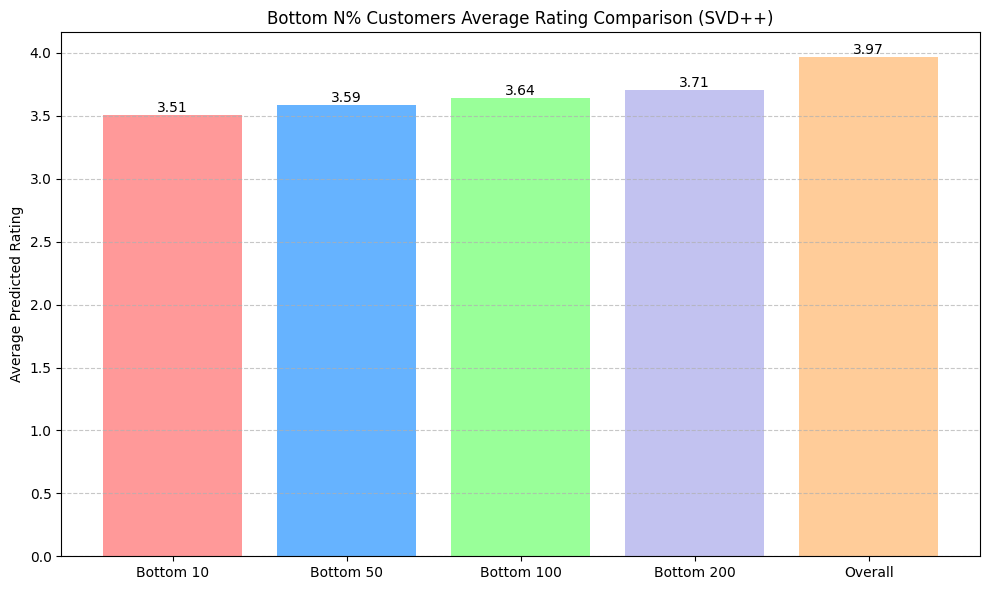

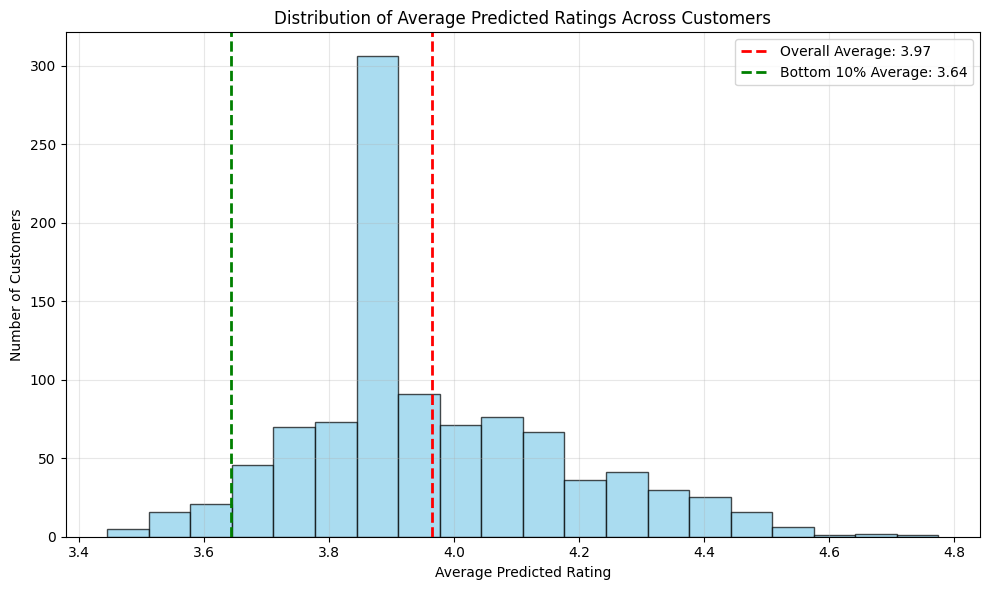


=== Gender-Based Bottom-N Analysis ===

Female (n=452 customers):
Overall average: 3.9685
Bottom 1% (4 customers) average: 3.5154
  Disparity: 0.4532 (11.4%)
Bottom 5% (22 customers) average: 3.5890
  Disparity: 0.3796 (9.6%)
Bottom 10% (45 customers) average: 3.6458
  Disparity: 0.3227 (8.1%)
Bottom 20% (90 customers) average: 3.7100
  Disparity: 0.2585 (6.5%)

Male (n=449 customers):
Overall average: 3.9612
Bottom 1% (4 customers) average: 3.4971
  Disparity: 0.4641 (11.7%)
Bottom 5% (22 customers) average: 3.5911
  Disparity: 0.3701 (9.3%)
Bottom 10% (44 customers) average: 3.6413
  Disparity: 0.3198 (8.1%)
Bottom 20% (89 customers) average: 3.7009
  Disparity: 0.2602 (6.6%)

Genderfluid (n=17 customers):
Overall average: 3.9369
Bottom 1% (1 customers) average: 3.6320
  Disparity: 0.3048 (7.7%)
Bottom 5% (1 customers) average: 3.6320
  Disparity: 0.3048 (7.7%)
Bottom 10% (1 customers) average: 3.6320
  Disparity: 0.3048 (7.7%)
Bottom 20% (3 customers) average: 3.7213
  Disparity: 0

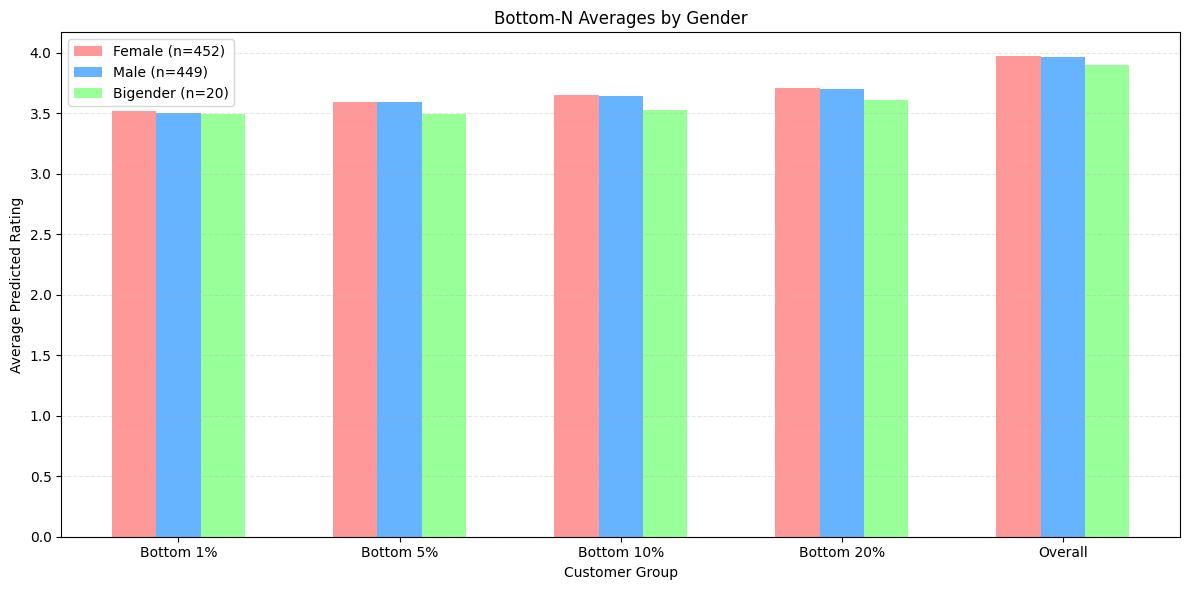

=== Bottom-N Average Individual Fairness Metric (ItemKNN) ===
Total number of customers: 1000
Bottom 5 customers average: 1.9627
Bottom 10 customers average: 2.0977
Bottom 20 customers average: 2.2225
Bottom 50 customers average: 2.4789
Bottom 1% of customers (10 customers) average: 2.0977
Bottom 5% of customers (50 customers) average: 2.4789
Bottom 10% of customers (100 customers) average: 2.6983
Bottom 20% of customers (200 customers) average: 2.9071
Overall average across all customers: 3.7608
Disparity between overall and bottom 1%: 1.6631 (44.2%)
Disparity between overall and bottom 5%: 1.2819 (34.1%)
Disparity between overall and bottom 10%: 1.0625 (28.3%)
Disparity between overall and bottom 20%: 0.8537 (22.7%)


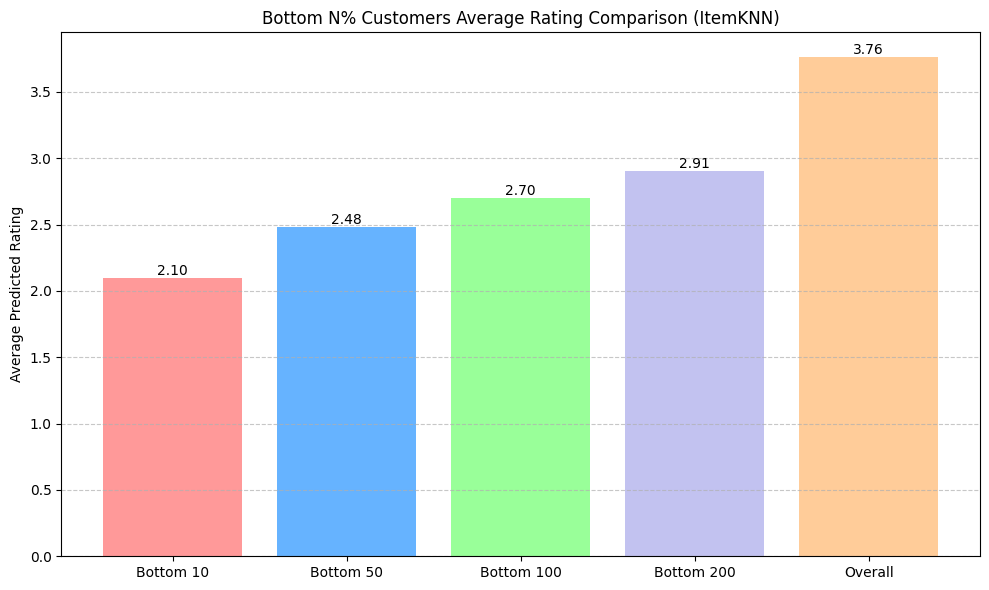

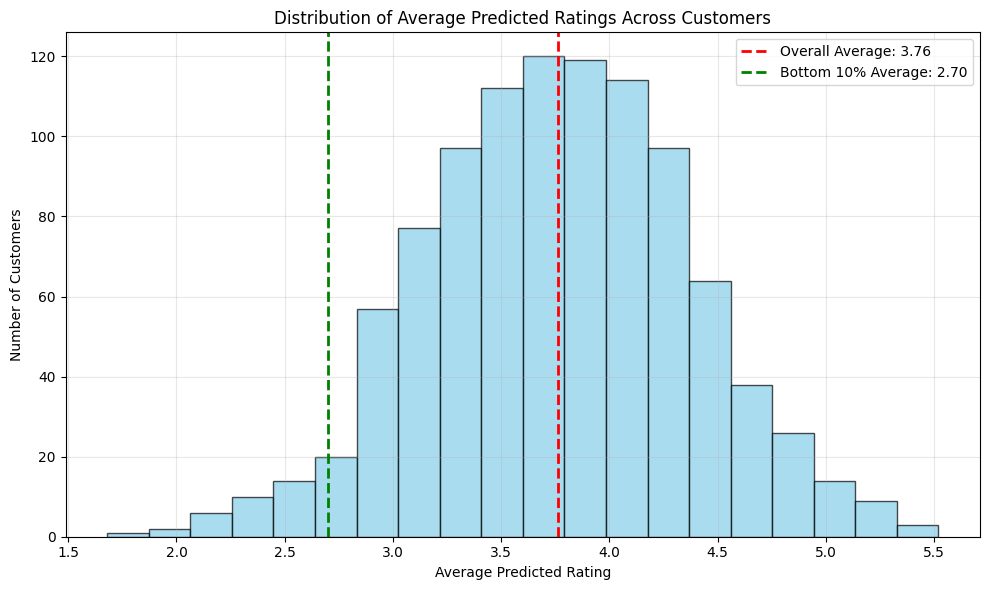


=== Gender-Based Bottom-N Analysis ===

Female (n=452 customers):
Overall average: 3.7543
Bottom 1% (4 customers) average: 1.9483
  Disparity: 1.8060 (48.1%)
Bottom 5% (22 customers) average: 2.4560
  Disparity: 1.2984 (34.6%)
Bottom 10% (45 customers) average: 2.6870
  Disparity: 1.0674 (28.4%)
Bottom 20% (90 customers) average: 2.8874
  Disparity: 0.8670 (23.1%)

Male (n=449 customers):
Overall average: 3.7682
Bottom 1% (4 customers) average: 2.1933
  Disparity: 1.5749 (41.8%)
Bottom 5% (22 customers) average: 2.4931
  Disparity: 1.2752 (33.8%)
Bottom 10% (44 customers) average: 2.6981
  Disparity: 1.0702 (28.4%)
Bottom 20% (89 customers) average: 2.9100
  Disparity: 0.8582 (22.8%)

Genderfluid (n=17 customers):
Overall average: 3.6489
Bottom 1% (1 customers) average: 2.3250
  Disparity: 1.3239 (36.3%)
Bottom 5% (1 customers) average: 2.3250
  Disparity: 1.3239 (36.3%)
Bottom 10% (1 customers) average: 2.3250
  Disparity: 1.3239 (36.3%)
Bottom 20% (3 customers) average: 2.5683
  Dis

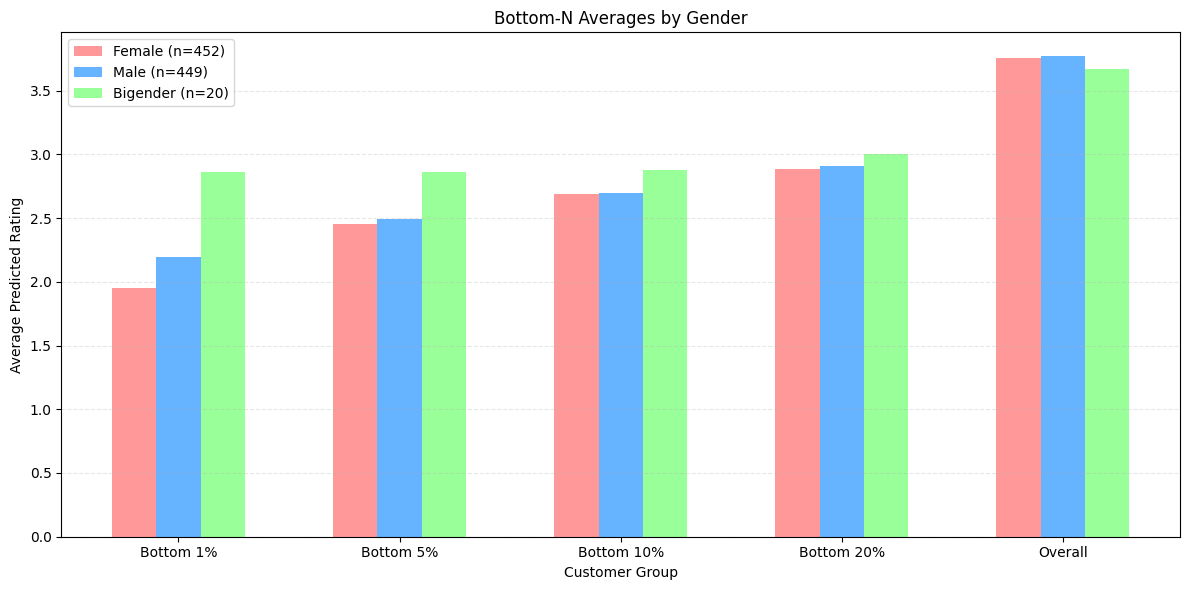

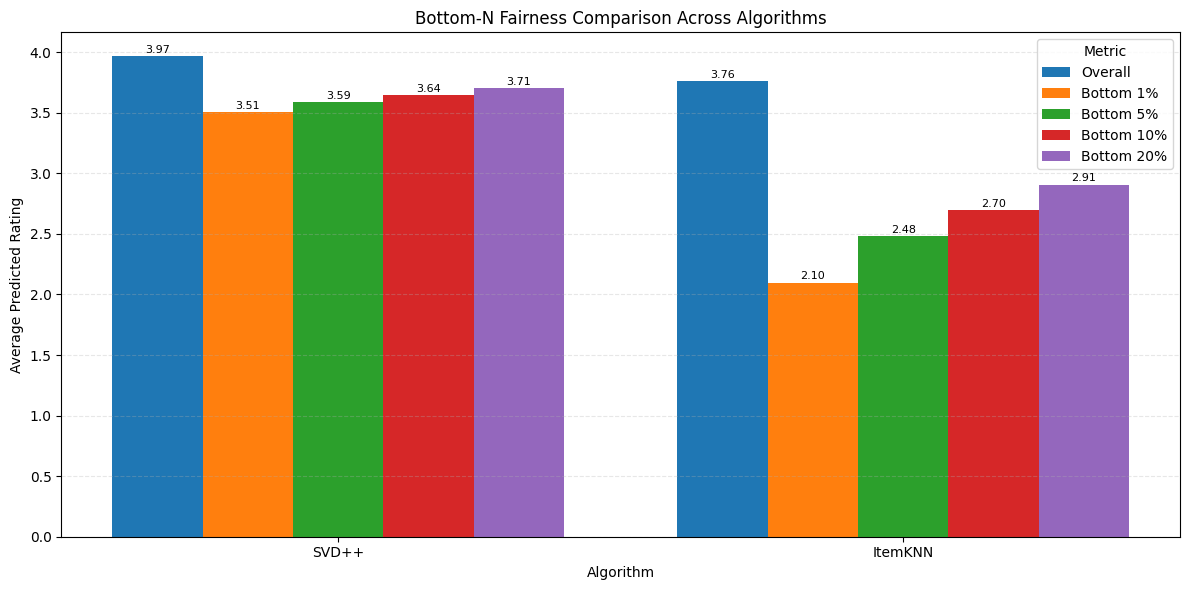

In [55]:
# For SVD++ model
bottom_n_svdpp = evaluate_bottom_n_fairness_svdpp(
    svdpp_predictions=svdpp_predictions,
    ns=[5, 10, 20, 50],
    e_commerce_data=e_commerce
)

# For ItemKNN model
bottom_n_itemknn = evaluate_bottom_n_fairness_itemknn(
    itemknn_predictions=itemknn_predictions,
    ns=[5, 10, 20, 50],
    e_commerce_data=e_commerce
)

# Compare the algorithms
compare_bottom_n_across_algorithms({
    'SVD++': bottom_n_svdpp,
    'ItemKNN': bottom_n_itemknn
})

## L1-Norm

In [56]:
def compute_distribution(df, column, group_col='Gender', bins=20):
    """
    Compute the distribution of a metric across demographic groups.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Dataframe with metrics and demographic information
    column : str
        Column to analyze (e.g., 'RMSE', 'avg_pred')
    group_col : str, default='Gender'
        Column name that contains group information
    bins : int, default=20
        Number of bins to use for the distribution
    
    Returns:
    --------
    dict, numpy.ndarray, dict
        Distributions, bin centers, and group statistics
    """
    # Define bins
    col_min = df[column].min()
    col_max = df[column].max()
    bin_edges = np.linspace(col_min, col_max, bins + 1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    # Calculate overall distribution and statistics
    overall_hist, _ = np.histogram(df[column], bins=bin_edges, density=True)
    overall_mean = df[column].mean()
    overall_median = df[column].median()
    
    # Initialize results
    distributions = {'overall': overall_hist}
    group_stats = {'overall': {'mean': overall_mean, 'median': overall_median, 'count': len(df)}}
    
    # Calculate distribution and statistics for each group
    for group in df[group_col].unique():
        if pd.isna(group):
            continue
        
        group_data = df[df[group_col] == group]
        if len(group_data) < 2:  # Skip if not enough data
            continue
            
        group_hist, _ = np.histogram(group_data[column], bins=bin_edges, density=True)
        group_mean = group_data[column].mean()
        group_median = group_data[column].median()
        
        distributions[group] = group_hist
        group_stats[group] = {
            'mean': group_mean, 
            'median': group_median,
            'count': len(group_data)
        }
    
    return distributions, bin_centers, group_stats

In [57]:
def compute_l1_norm_from_distributions(distributions):
    """
    Compute L1-Norm (L1 distance) between distributions.
    
    Parameters:
    -----------
    distributions : dict
        Dictionary mapping group names to their distributions (numpy arrays)
    
    Returns:
    --------
    dict
        Dictionary mapping each group to its L1-Norm distance from the overall distribution
    """
    # Get overall distribution as reference
    overall_dist = distributions['overall']
    
    # Initialize results
    l1_results = {}
    
    # Compute L1-Norm for each group
    for group, dist in distributions.items():
        if group == 'overall':
            continue
            
        # Calculate absolute differences and sum them
        abs_diff = np.abs(dist - overall_dist)
        l1_norm = np.sum(abs_diff) / 2  # Divide by 2 to normalize between 0 and 1
        
        l1_results[group] = l1_norm
    
    return l1_results

In [58]:
def plot_combined_l1_norm_results(l1_results_dict, group_col, metrics):
    """
    Create a combined bar chart showing L1-Norm results for multiple metrics.
    
    Parameters:
    -----------
    l1_results_dict : dict
        Dictionary with L1-Norm results for each metric
    group_col : str
        Name of the demographic column
    metrics : list
        List of metrics being analyzed
    """
    # Prepare data for plotting
    plot_data = []
    for metric in metrics:
        for group, value in l1_results_dict[metric].items():
            plot_data.append({
                'Group': group,
                'Metric': metric,
                'L1-Norm': value
            })
    
    plot_df = pd.DataFrame(plot_data)
    
    # Create grouped bar chart
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x='Group', y='L1-Norm', hue='Metric', data=plot_df)
    
    # Add value labels on top of bars
    for c in ax.containers:
        ax.bar_label(c, fmt='%.3f', padding=3)
    
    plt.xlabel(f'{group_col}')
    plt.ylabel('L1-Norm (Distribution Difference)')
    plt.title(f'Category-Focused Fairness: L1-Norm by {group_col}')
    
    # Add reference lines
    plt.axhline(y=0.1, color='r', linestyle='--', alpha=0.3, label='Moderate Difference (0.1)')
    plt.axhline(y=0.2, color='r', linestyle='--', alpha=0.6, label='Large Difference (0.2)')
    
    # Add legend with better placement
    plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.tight_layout()
    
    return plt.gcf()

In [59]:
def plot_distribution_comparison(distributions, bin_centers, stats, group_col, metric):
    """
    Plot distribution comparison between demographic groups for a specific metric.
    
    Parameters:
    -----------
    distributions : dict
        Dictionary of distributions by group
    bin_centers : numpy.ndarray
        Bin centers for plotting
    stats : dict
        Dictionary of group statistics
    group_col : str
        Name of the demographic column
    metric : str
        Name of the metric being analyzed
    """
    plt.figure(figsize=(10, 6))
    
    # Plot overall distribution as a line
    plt.plot(bin_centers, distributions['overall'], 'k-', 
             linewidth=2, label=f'Overall (mean={stats["overall"]["mean"]:.2f})')
    
    # Plot each group distribution
    colors = sns.color_palette("tab10", len(distributions) - 1)
    i = 0
    for group, dist in distributions.items():
        if group == 'overall':
            continue
        plt.plot(bin_centers, dist, '-', color=colors[i], 
                 linewidth=2, label=f'{group} (mean={stats[group]["mean"]:.2f})')
        i += 1
    
    # Add vertical lines for means
    plt.axvline(x=stats['overall']['mean'], color='k', linestyle='--', alpha=0.5)
    i = 0
    for group in distributions.keys():
        if group == 'overall':
            continue
        plt.axvline(x=stats[group]['mean'], color=colors[i], linestyle='--', alpha=0.5)
        i += 1
    
    plt.xlabel(f'Category {metric}')
    plt.ylabel('Density')
    plt.title(f'Distribution of Category {metric} by {group_col}')
    plt.legend(title=group_col)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    return plt.gcf()

In [60]:
def compute_item_metrics_from_svdpp(svdpp_predictions, e_commerce_data):
    """
    Compute item-level metrics from SVD++ predictions DataFrame.
    
    Parameters:
    -----------
    svdpp_predictions : pd.DataFrame
        DataFrame containing predictions with customer_id, purchase_category, and predicted_rating
    e_commerce_data : pd.DataFrame
        E-commerce data with customer demographics
    
    Returns:
    --------
    pd.DataFrame
        DataFrame with item-level metrics and demographic information
    """
    # Create mapping from customer_id to demographics
    customer_gender = dict(zip(e_commerce_data['Customer_ID'], e_commerce_data['Gender']))
    customer_age_group = {}
    if 'Age_Group' in e_commerce_data.columns:
        customer_age_group = dict(zip(e_commerce_data['Customer_ID'], e_commerce_data['Age_Group']))
    
    # Get metrics by purchase category (the item)
    item_metrics = []
    
    for item, group in svdpp_predictions.groupby('purchase_category'):
        # Add demographic information to each prediction
        item_demographics = []
        for _, row in group.iterrows():
            customer_id = row['customer_id']
            gender = customer_gender.get(customer_id)
            age_group = customer_age_group.get(customer_id) if customer_age_group else None
            
            item_demographics.append({
                'customer_id': customer_id,
                'gender': gender,
                'age_group': age_group if age_group else None,
                'predicted_rating': row['predicted_rating']
            })
        
        item_demo_df = pd.DataFrame(item_demographics)
        
        # Calculate average predicted rating overall
        avg_pred_overall = item_demo_df['predicted_rating'].mean()
        
        # Calculate average predicted ratings by gender
        gender_metrics = {}
        for gender, gender_group in item_demo_df.groupby('gender'):
            if pd.isna(gender) or len(gender_group) < 2:
                continue
            gender_metrics[gender] = gender_group['predicted_rating'].mean()
        
        # Calculate average predicted ratings by age group if available
        age_group_metrics = {}
        if 'age_group' in item_demo_df.columns:
            for age_group_val, age_group_df in item_demo_df.groupby('age_group'):
                if pd.isna(age_group_val) or len(age_group_df) < 2:
                    continue
                age_group_metrics[age_group_val] = age_group_df['predicted_rating'].mean()
        
        # Store item metrics
        item_metric = {
            'item': item,
            'avg_pred': avg_pred_overall,
            'num_predictions': len(item_demo_df)
        }
        
        # Add gender-specific metrics
        for gender, avg in gender_metrics.items():
            item_metric[f'avg_pred_{gender}'] = avg
        
        # Add age-group-specific metrics
        for age_group, avg in age_group_metrics.items():
            # Remove special characters from column name
            col_name = f'avg_pred_{str(age_group).replace("-", "_").replace("–", "_")}'
            item_metric[col_name] = avg
        
        item_metrics.append(item_metric)
    
    # Create item metrics DataFrame
    item_metrics_df = pd.DataFrame(item_metrics)
    
    # Calculate disparity metrics
    if 'avg_pred_Male' in item_metrics_df.columns and 'avg_pred_Female' in item_metrics_df.columns:
        # Gender disparity
        item_metrics_df['gender_disparity'] = item_metrics_df['avg_pred_Male'] - item_metrics_df['avg_pred_Female']
        item_metrics_df['abs_gender_disparity'] = item_metrics_df['gender_disparity'].abs()
    
    return item_metrics_df

In [61]:
def compute_item_metrics_from_itemknn(itemknn_predictions, e_commerce_data):
    """
    Compute item-level metrics from ItemKNN predictions DataFrame.
    
    Parameters:
    -----------
    itemknn_predictions : pd.DataFrame
        DataFrame containing predictions with purchase_category, customer_id, true_rating, and predicted_rating
    e_commerce_data : pd.DataFrame
        E-commerce data with customer demographics
    
    Returns:
    --------
    pd.DataFrame
        DataFrame with item-level metrics and demographic information
    """
    # Drop NaN predicted ratings
    valid_predictions = itemknn_predictions.dropna(subset=['predicted_rating']).copy()
    
    # Create mapping from customer_id to demographics
    customer_gender = dict(zip(e_commerce_data['Customer_ID'], e_commerce_data['Gender']))
    customer_age_group = {}
    if 'Age_Group' in e_commerce_data.columns:
        customer_age_group = dict(zip(e_commerce_data['Customer_ID'], e_commerce_data['Age_Group']))
    
    # Get metrics by purchase category (the item)
    item_metrics = []
    
    for item, group in valid_predictions.groupby('purchase_category'):
        # Add demographic information to each prediction
        item_demographics = []
        for _, row in group.iterrows():
            customer_id = row['customer_id']
            gender = customer_gender.get(customer_id)
            age_group = customer_age_group.get(customer_id) if customer_age_group else None
            
            # Add error calculation if true_rating is available
            pred_rating = row['predicted_rating']
            true_rating = row['true_rating'] if 'true_rating' in row else None
            error = true_rating - pred_rating if true_rating is not None else None
            
            item_demographics.append({
                'customer_id': customer_id,
                'gender': gender,
                'age_group': age_group if age_group else None,
                'predicted_rating': pred_rating,
                'true_rating': true_rating,
                'error': error
            })
        
        item_demo_df = pd.DataFrame(item_demographics)
        
        # Calculate overall metrics
        avg_pred_overall = item_demo_df['predicted_rating'].mean()
        
        # Calculate metrics by gender
        gender_metrics = {}
        for gender, gender_group in item_demo_df.groupby('gender'):
            if pd.isna(gender) or len(gender_group) < 2:
                continue
            gender_metrics[gender] = gender_group['predicted_rating'].mean()
        
        # Calculate metrics by age group if available
        age_group_metrics = {}
        if 'age_group' in item_demo_df.columns:
            for age_group_val, age_group_df in item_demo_df.groupby('age_group'):
                if pd.isna(age_group_val) or len(age_group_df) < 2:
                    continue
                age_group_metrics[age_group_val] = age_group_df['predicted_rating'].mean()
        
        # Store item metrics
        item_metric = {
            'item': item,
            'avg_pred': avg_pred_overall,
            'num_predictions': len(item_demo_df)
        }
        
        # Calculate RMSE and MAE if true ratings are available
        if 'error' in item_demo_df.columns and not item_demo_df['error'].isna().all():
            item_metric['RMSE'] = np.sqrt(np.mean(item_demo_df['error'].dropna() ** 2))
            item_metric['MAE'] = np.mean(np.abs(item_demo_df['error'].dropna()))
        
        # Add gender-specific metrics
        for gender, avg in gender_metrics.items():
            item_metric[f'avg_pred_{gender}'] = avg
        
        # Add age-group-specific metrics
        for age_group, avg in age_group_metrics.items():
            # Remove special characters from column name
            col_name = f'avg_pred_{str(age_group).replace("-", "_").replace("–", "_")}'
            item_metric[col_name] = avg
        
        item_metrics.append(item_metric)
    
    # Create item metrics DataFrame
    item_metrics_df = pd.DataFrame(item_metrics)
    
    # Calculate disparity metrics
    if 'avg_pred_Male' in item_metrics_df.columns and 'avg_pred_Female' in item_metrics_df.columns:
        # Gender disparity
        item_metrics_df['gender_disparity'] = item_metrics_df['avg_pred_Male'] - item_metrics_df['avg_pred_Female']
        item_metrics_df['abs_gender_disparity'] = item_metrics_df['gender_disparity'].abs()
    
    return item_metrics_df

In [62]:
def evaluate_l1_norm_fairness_svdpp(svdpp_predictions, e_commerce_data, metrics=None, group_cols=None, bins=20):
    """
    Evaluate L1-Norm as a group fairness metric for SVD++ model with e-commerce data.
    
    Parameters:
    -----------
    svdpp_predictions : pd.DataFrame
        DataFrame with customer_id, purchase_category, and predicted_rating columns
    e_commerce_data : pd.DataFrame
        E-commerce dataset with demographic information
    metrics : list, optional
        List of metrics to analyze
    group_cols : list, optional
        List of demographic columns to analyze
    bins : int, default=20
        Number of bins for distributions
        
    Returns:
    --------
    dict
        Dictionary with L1-Norm results for each demographic group and metric
    pd.DataFrame
        DataFrame with item metrics and demographic information
    """
    if metrics is None:
        metrics = ['avg_pred']
    
    if group_cols is None:
        group_cols = ['Gender', 'Age_Group']
        # Keep only fields that exist in the e-commerce dataframe
        group_cols = [field for field in group_cols if field in e_commerce_data.columns]
    
    # Compute item-level metrics
    item_metrics_df = compute_item_metrics_from_svdpp(svdpp_predictions, e_commerce_data)
    
    # Initialize results
    results = {}
    
    print("=== L1-Norm Group Fairness Metric (SVD++) ===")
    
    # Analyze for each demographic field
    for group_col in group_cols:
        # Determine gender-specific columns
        if group_col == 'Gender':
            gender_cols = [col for col in item_metrics_df.columns if col.startswith('avg_pred_') and col not in ['avg_pred_18_25', 'avg_pred_26_30', 'avg_pred_31_35']]
            if len(gender_cols) < 2:
                print(f"Warning: Not enough gender-specific columns found for analysis")
                continue
                
            # Create a long-format DataFrame for L1-norm analysis
            gender_data = []
            for _, row in item_metrics_df.iterrows():
                for col in gender_cols:
                    if not pd.isna(row[col]):
                        gender = col.replace('avg_pred_', '')
                        gender_data.append({
                            'item': row['item'],
                            'Gender': gender,
                            'avg_pred': row[col]
                        })
            
            gender_df = pd.DataFrame(gender_data)
            
            if len(gender_df) == 0:
                print(f"Warning: No gender data available for analysis")
                continue
                
            # For each metric, compute distributions and L1-Norm
            field_results = {}
            all_l1_results = {}
            
            for metric in metrics:
                if metric not in gender_df.columns:
                    print(f"Warning: {metric} not found in gender data")
                    continue
                    
                # Compute distributions
                distributions, bin_centers, stats = compute_distribution(
                    gender_df, column=metric, group_col=group_col, bins=bins)
                
                if len(distributions) <= 1:
                    print(f"  Not enough data for {metric} by {group_col}")
                    continue
                    
                # Calculate L1-Norm
                l1_results = compute_l1_norm_from_distributions(distributions)
                
                # Store results
                field_results[metric] = {
                    'distributions': distributions,
                    'bin_centers': bin_centers,
                    'stats': stats,
                    'l1_results': l1_results
                }
                
                all_l1_results[metric] = l1_results
                
                # Print results
                print(f"\n  {metric} distribution L1-Norm:")
                for group, l1_value in l1_results.items():
                    interpretation = "low" if l1_value < 0.1 else "moderate" if l1_value < 0.2 else "high"
                    mean_diff = abs(stats[group]['mean'] - stats['overall']['mean'])
                    if stats['overall']['mean'] != 0:
                        mean_diff_pct = (mean_diff / abs(stats['overall']['mean'])) * 100
                    else:
                        mean_diff_pct = 0
                    print(f"    {group}: {l1_value:.4f} ({interpretation} difference)")
                    print(f"      Mean: {stats[group]['mean']:.4f} vs Overall: {stats['overall']['mean']:.4f}")
                    print(f"      Difference: {mean_diff:.4f} ({mean_diff_pct:.1f}%)")
                    print(f"      Sample size: {stats[group]['count']} items")
            
            # Store all results for this demographic field
            if all_l1_results:  # Only store if we have results
                results[group_col] = field_results
                
                # Create visualizations
                if len(all_l1_results) > 0:
                    plot_combined_l1_norm_results(all_l1_results, group_col, list(all_l1_results.keys()))
                    plt.show()
                
                # Distribution plots for key metrics
                for metric in metrics[:2]:  # Limit to first 2 metrics to avoid too many plots
                    if metric in field_results:
                        plot_distribution_comparison(
                            field_results[metric]['distributions'],
                            field_results[metric]['bin_centers'],
                            field_results[metric]['stats'],
                            group_col,
                            metric
                        )
                        plt.show()
    return results, item_metrics_df

In [63]:
def evaluate_l1_norm_fairness_itemknn(itemknn_predictions, e_commerce_data, metrics=None, group_cols=None, bins=20):
    """
    Evaluate L1-Norm as a group fairness metric for ItemKNN model with e-commerce data.
    
    Parameters:
    -----------
    itemknn_predictions : pd.DataFrame
        DataFrame with purchase_category, customer_id, true_rating, and predicted_rating columns
    e_commerce_data : pd.DataFrame
        E-commerce dataset with demographic information
    metrics : list, optional
        List of metrics to analyze
    group_cols : list, optional
        List of demographic columns to analyze
    bins : int, default=20
        Number of bins for distributions
        
    Returns:
    --------
    dict
        Dictionary with L1-Norm results for each demographic group and metric
    pd.DataFrame
        DataFrame with item metrics and demographic information
    """
    if metrics is None:
        metrics = ['avg_pred']
        if 'true_rating' in itemknn_predictions.columns:
            metrics += ['RMSE', 'MAE']
    
    if group_cols is None:
        group_cols = ['Gender', 'Age_Group']
        # Keep only fields that exist in the e-commerce dataframe
        group_cols = [field for field in group_cols if field in e_commerce_data.columns]
    
    # Compute item-level metrics
    item_metrics_df = compute_item_metrics_from_itemknn(itemknn_predictions, e_commerce_data)
    
    # Initialize results
    results = {}
    
    print("=== L1-Norm Group Fairness Metric (ItemKNN) ===")
    
    # Analyze for each demographic field
    for group_col in group_cols:
        # Determine gender-specific columns
        if group_col == 'Gender':
            gender_cols = [col for col in item_metrics_df.columns if col.startswith('avg_pred_') and col not in ['avg_pred_18_25', 'avg_pred_26_30', 'avg_pred_31_35']]
            if len(gender_cols) < 2:
                print(f"Warning: Not enough gender-specific columns found for analysis")
                continue
                
            # Create a long-format DataFrame for L1-norm analysis
            gender_data = []
            for _, row in item_metrics_df.iterrows():
                for col in gender_cols:
                    if not pd.isna(row[col]):
                        gender = col.replace('avg_pred_', '')
                        gender_data.append({
                            'item': row['item'],
                            'Gender': gender,
                            'avg_pred': row[col],
                            'RMSE': row.get('RMSE'),
                            'MAE': row.get('MAE')
                        })
            
            gender_df = pd.DataFrame(gender_data)
            
            if len(gender_df) == 0:
                print(f"Warning: No gender data available for analysis")
                continue
                
            # For each metric, compute distributions and L1-Norm
            field_results = {}
            all_l1_results = {}
            
            for metric in metrics:
                if metric not in gender_df.columns or gender_df[metric].isna().all():
                    print(f"Warning: {metric} not found in gender data or all values are NaN")
                    continue
                    
                # Compute distributions
                distributions, bin_centers, stats = compute_distribution(
                    gender_df.dropna(subset=[metric]), column=metric, group_col=group_col, bins=bins)
                
                if len(distributions) <= 1:
                    print(f"  Not enough data for {metric} by {group_col}")
                    continue
                    
                # Calculate L1-Norm
                l1_results = compute_l1_norm_from_distributions(distributions)
                
                # Store results
                field_results[metric] = {
                    'distributions': distributions,
                    'bin_centers': bin_centers,
                    'stats': stats,
                    'l1_results': l1_results
                }
                
                all_l1_results[metric] = l1_results
                
                # Print results
                print(f"\n  {metric} distribution L1-Norm:")
                for group, l1_value in l1_results.items():
                    interpretation = "low" if l1_value < 0.1 else "moderate" if l1_value < 0.2 else "high"
                    mean_diff = abs(stats[group]['mean'] - stats['overall']['mean'])
                    if stats['overall']['mean'] != 0:
                        mean_diff_pct = (mean_diff / abs(stats['overall']['mean'])) * 100
                    else:
                        mean_diff_pct = 0
                    print(f"    {group}: {l1_value:.4f} ({interpretation} difference)")
                    print(f"      Mean: {stats[group]['mean']:.4f} vs Overall: {stats['overall']['mean']:.4f}")
                    print(f"      Difference: {mean_diff:.4f} ({mean_diff_pct:.1f}%)")
                    print(f"      Sample size: {stats[group]['count']} items")
            
            # Store all results for this demographic field
            if all_l1_results:  # Only store if we have results
                results[group_col] = field_results
                
                # Create visualizations
                if len(all_l1_results) > 0:
                    plot_combined_l1_norm_results(all_l1_results, group_col, list(all_l1_results.keys()))
                    plt.show()
                
                # Distribution plots for key metrics
                for metric in metrics[:2]:  # Limit to first 2 metrics to avoid too many plots
                    if metric in field_results:
                        plot_distribution_comparison(
                            field_results[metric]['distributions'],
                            field_results[metric]['bin_centers'],
                            field_results[metric]['stats'],
                            group_col,
                            metric
                        )
                        plt.show()
        
    return results, item_metrics_df

In [64]:
def compare_l1_norm_across_algorithms(metrics_dict, metric='avg_pred', group_col='Gender', figsize=(12, 6)):
    """
    Compare L1-Norm fairness metrics across different recommendation algorithms.
    
    Parameters:
    -----------
    metrics_dict : dict
        Dictionary mapping algorithm names to their L1-Norm results
    metric : str, default='avg_pred'
        Metric to compare
    group_col : str, default='Gender'
        Demographic group to compare
    figsize : tuple, default=(12, 6)
        Figure size (width, height) in inches
    """
    # Extract data for plotting
    data = []
    
    for algo, results in metrics_dict.items():
        if group_col in results and metric in results[group_col]:
            l1_results = results[group_col][metric]['l1_results']
            for group, value in l1_results.items():
                data.append({
                    'Algorithm': algo,
                    'Group': group,
                    'L1-Norm': value
                })
    
    df = pd.DataFrame(data)
    
    if len(df) == 0:
        print(f"No data available for {metric} by {group_col}")
        return
    
    # Plot
    plt.figure(figsize=figsize)
    
    # Create grouped bar chart
    groups = df['Group'].unique()
    algorithms = df['Algorithm'].unique()
    x = np.arange(len(algorithms))
    width = 0.8 / len(groups)
    
    for i, group in enumerate(groups):
        group_data = df[df['Group'] == group]
        offsets = [-0.4 + (i+0.5)*width for _ in range(len(algorithms))]
        
        bars = plt.bar(x + np.array(offsets), group_data['L1-Norm'], width, label=group)
        
        # Add value labels
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=8)
    
    plt.xlabel('Algorithm')
    plt.ylabel('L1-Norm (lower is better)')
    plt.title(f'{metric} Distribution Difference by {group_col} Across Algorithms')
    plt.xticks(x, algorithms)
    plt.legend(title=group_col)
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    
    # Add reference lines
    plt.axhline(y=0.1, color='r', linestyle='--', alpha=0.3, label='Moderate Difference (0.1)')
    plt.axhline(y=0.2, color='r', linestyle='--', alpha=0.6, label='Large Difference (0.2)')
    
    plt.tight_layout()
    plt.show()

=== L1-Norm Group Fairness Metric (SVD++) ===

  avg_pred distribution L1-Norm:
    Agender: 6.6468 (high difference)
      Mean: 4.0214 vs Overall: 3.9601
      Difference: 0.0613 (1.5%)
      Sample size: 20 items
    Bigender: 7.2324 (high difference)
      Mean: 3.8718 vs Overall: 3.9601
      Difference: 0.0883 (2.2%)
      Sample size: 20 items
    Female: 4.3257 (high difference)
      Mean: 3.9520 vs Overall: 3.9601
      Difference: 0.0081 (0.2%)
      Sample size: 24 items
    Genderfluid: 6.9985 (high difference)
      Mean: 3.9095 vs Overall: 3.9601
      Difference: 0.0506 (1.3%)
      Sample size: 18 items
    Genderqueer: 6.3678 (high difference)
      Mean: 4.0572 vs Overall: 3.9601
      Difference: 0.0971 (2.5%)
      Sample size: 19 items
    Male: 4.8664 (high difference)
      Mean: 3.9411 vs Overall: 3.9601
      Difference: 0.0190 (0.5%)
      Sample size: 24 items
    Non-binary: 6.1984 (high difference)
      Mean: 4.0266 vs Overall: 3.9601
      Difference: 0.

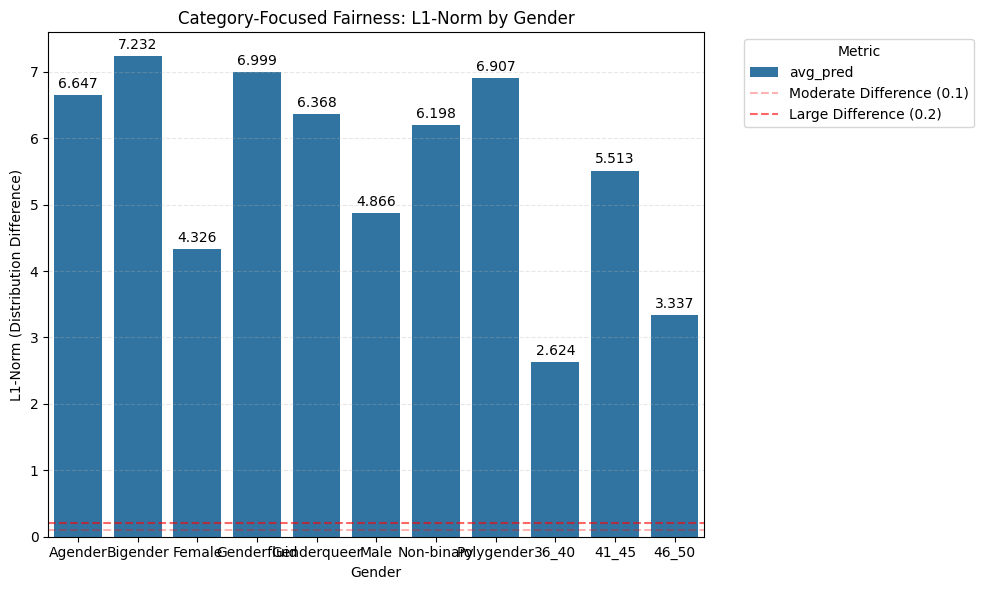

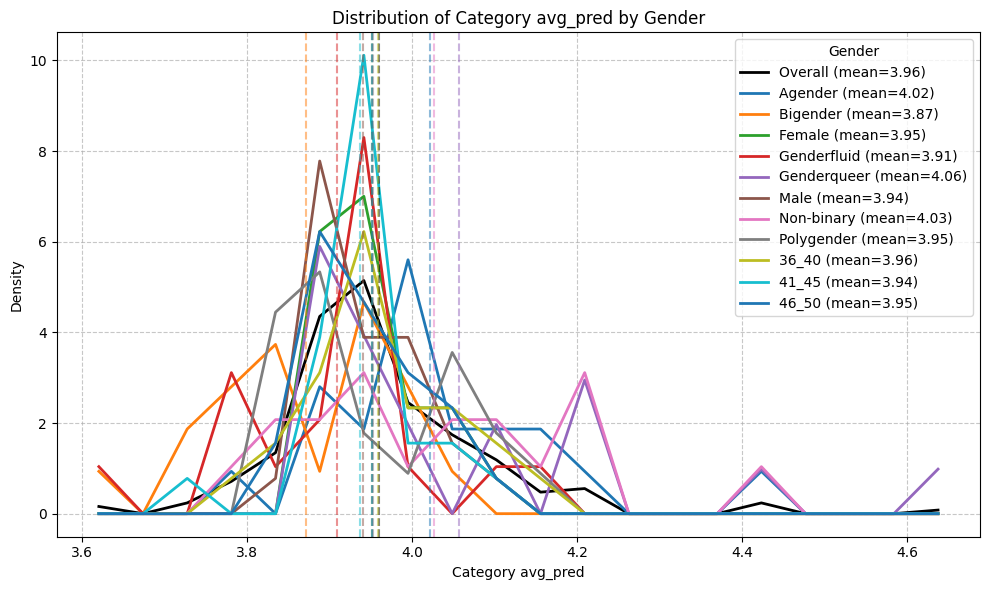

=== L1-Norm Group Fairness Metric (ItemKNN) ===

  avg_pred distribution L1-Norm:
    Agender: 7.0992 (high difference)
      Mean: 3.5737 vs Overall: 3.7498
      Difference: 0.1761 (4.7%)
      Sample size: 7 items
    Female: 2.8114 (high difference)
      Mean: 3.7944 vs Overall: 3.7498
      Difference: 0.0447 (1.2%)
      Sample size: 24 items
    Male: 3.2563 (high difference)
      Mean: 3.7972 vs Overall: 3.7498
      Difference: 0.0474 (1.3%)
      Sample size: 24 items
    36_40: 2.4877 (high difference)
      Mean: 3.7609 vs Overall: 3.7498
      Difference: 0.0111 (0.3%)
      Sample size: 24 items
    41_45: 3.8833 (high difference)
      Mean: 3.7389 vs Overall: 3.7498
      Difference: 0.0108 (0.3%)
      Sample size: 24 items
    46_50: 2.5484 (high difference)
      Mean: 3.7116 vs Overall: 3.7498
      Difference: 0.0381 (1.0%)
      Sample size: 24 items
    Bigender: 4.7328 (high difference)
      Mean: 3.7094 vs Overall: 3.7498
      Difference: 0.0403 (1.1%)
    

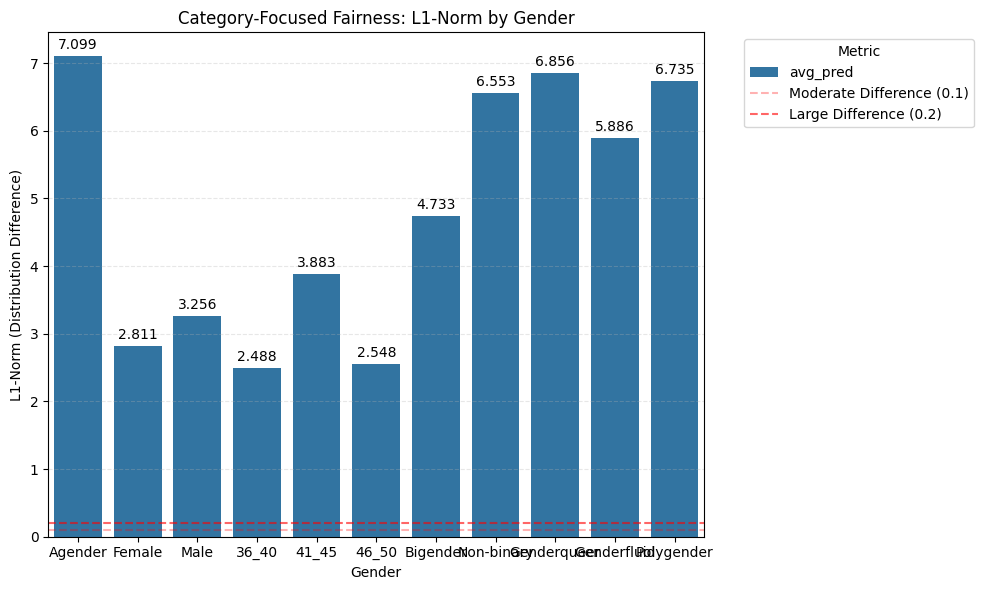

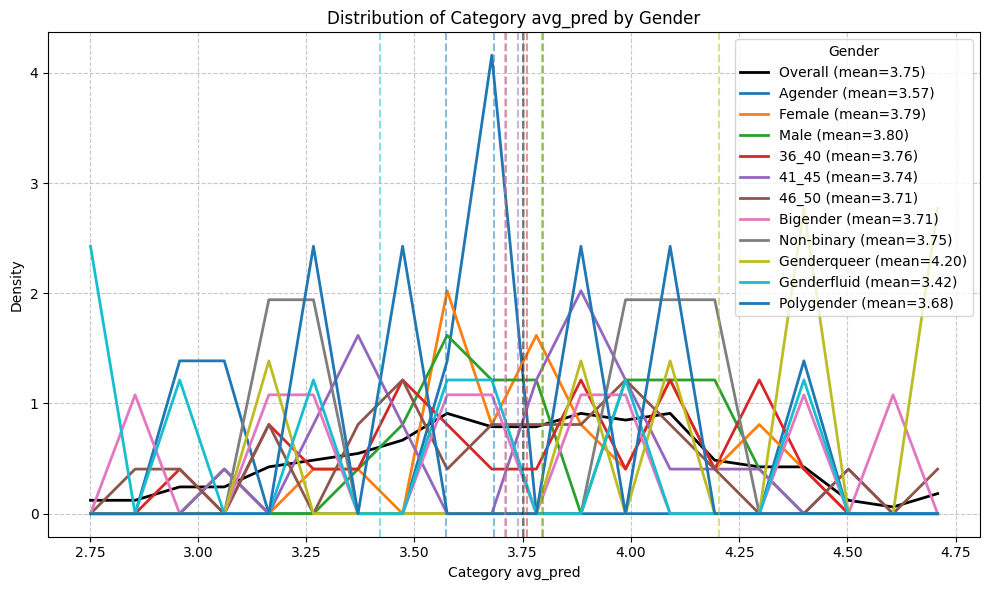

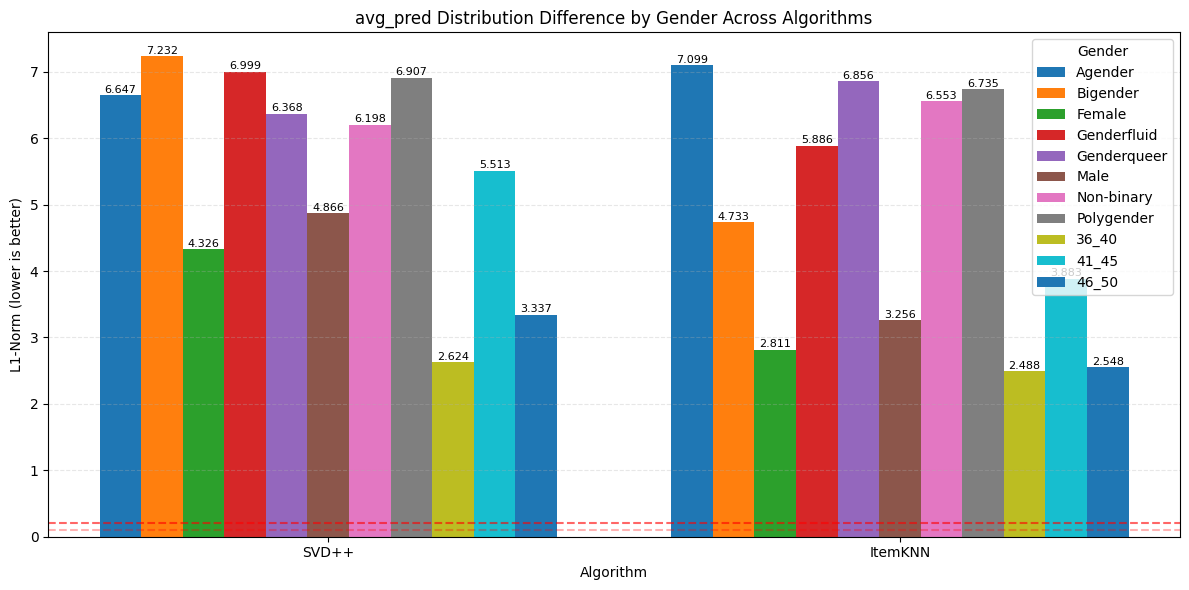

In [65]:
# For SVD++
l1_results_svdpp, item_metrics_svdpp = evaluate_l1_norm_fairness_svdpp(
    svdpp_predictions=svdpp_predictions,
    e_commerce_data=e_commerce,
    metrics=['avg_pred'],
    group_cols=['Gender']
)

# For ItemKNN
l1_results_itemknn, item_metrics_itemknn = evaluate_l1_norm_fairness_itemknn(
    itemknn_predictions=itemknn_predictions,
    e_commerce_data=e_commerce,
    metrics=['avg_pred'],
    group_cols=['Gender']
)

# Compare algorithms
compare_l1_norm_across_algorithms(
    {'SVD++': l1_results_svdpp, 'ItemKNN': l1_results_itemknn},
    metric='avg_pred',
    group_col='Gender'
)

## KL Divergence

In [66]:
def compute_category_metrics(predictions, category_col='user_id', customer_col='item_id', 
                          pred_col='est', true_col='true_rating'):
    """
    Compute category-level metrics from prediction data for e-commerce dataset.
    
    Parameters:
    -----------
    predictions : pd.DataFrame or list
        Either DataFrame containing predictions or list of Surprise prediction objects
    category_col : str, default='user_id'
        Column containing category identifiers
    customer_col : str, default='item_id'
        Column containing customer identifiers
    pred_col : str, default='est'
        Column containing predicted ratings
    true_col : str, default='true_rating'
        Column containing true ratings
        
    Returns:
    --------
    pd.DataFrame
        DataFrame with category-level metrics
    """
    # Convert to DataFrame if needed
    if not isinstance(predictions, pd.DataFrame):
        # Convert Surprise predictions to DataFrame
        pred_data = []
        for uid, iid, true_r, est, _ in predictions:
            pred_data.append({
                category_col: uid,         # Category
                customer_col: iid,         # Customer
                true_col: true_r,
                pred_col: est
            })
        pred_df = pd.DataFrame(pred_data)
    else:
        pred_df = predictions.copy()
    
    # Group by category
    category_metrics = []
    
    for category, group in pred_df.groupby(category_col):
        # Skip if true rating is missing
        if true_col not in group.columns or group[true_col].isna().all():
            continue
            
        # Calculate RMSE
        rmse = np.sqrt(np.mean((group[pred_col] - group[true_col])**2))
        
        # Calculate MAE
        mae = np.mean(np.abs(group[pred_col] - group[true_col]))
        
        # Calculate average predicted rating
        avg_pred = group[pred_col].mean()
        
        # Calculate average true rating
        avg_true = group[true_col].mean()
        
        # Calculate prediction variance
        pred_var = group[pred_col].var() if len(group) > 1 else 0
        
        # Calculate average error
        avg_error = (group[true_col] - group[pred_col]).mean()
        
        # Store metrics
        category_metrics.append({
            category_col: category,
            'RMSE': rmse,
            'MAE': mae,
            'avg_pred': avg_pred,
            'avg_true': avg_true,
            'pred_variance': pred_var,
            'avg_error': avg_error,
            'num_predictions': len(group)
        })
    
    # Create DataFrame
    category_metrics_df = pd.DataFrame(category_metrics)
    
    return category_metrics_df

In [67]:
def compute_kl_divergence(df, column, group_col='Gender', bins=20):
    """
    Compute KL divergence between distributions across demographic groups.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Dataframe with metrics and demographic information
    column : str
        Column to analyze (e.g., 'RMSE', 'avg_pred')
    group_col : str, default='Gender'
        Column name that contains group information
    bins : int, default=20
        Number of bins to use for the distribution
        
    Returns:
    --------
    dict, dict, dict, numpy.ndarray
        KL results, statistics, distributions, bin centers
    """
    # Check if we have enough data
    if len(df) < 10 or column not in df.columns:
        return {}, {}, {}, np.array([])
    
    # Define bins for the metric
    col_min = df[column].min()
    col_max = df[column].max()
    bin_edges = np.linspace(col_min, col_max, bins + 1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    # Calculate overall distribution and statistics
    overall_values = df[column].dropna().values
    if len(overall_values) < 5:  # Skip if not enough data
        return {}, {}, {}, np.array([])
        
    overall_hist, _ = np.histogram(overall_values, bins=bin_edges, density=True)
    overall_mean = np.mean(overall_values)
    overall_median = np.median(overall_values)
    
    # Apply smoothing to avoid zero probabilities
    epsilon = 1e-10
    overall_hist = overall_hist + epsilon
    overall_hist = overall_hist / overall_hist.sum()  # Re-normalize
    
    # Initialize results
    kl_results = {}
    stats = {'overall': {'mean': overall_mean, 'median': overall_median, 'count': len(overall_values)}}
    distributions = {'overall': overall_hist}
    
    # Compute KL divergence for each group
    for group in df[group_col].dropna().unique():
        group_values = df[df[group_col] == group][column].dropna().values
        
        if len(group_values) < 5:  # Skip if not enough data
            continue
            
        # Calculate statistics
        group_mean = np.mean(group_values)
        group_median = np.median(group_values)
        
        stats[group] = {
            'mean': group_mean,
            'median': group_median,
            'count': len(group_values)
        }
        
        # Calculate distribution with smoothing
        group_hist, _ = np.histogram(group_values, bins=bin_edges, density=True)
        group_hist = group_hist + epsilon
        group_hist = group_hist / group_hist.sum()
        distributions[group] = group_hist
        
        # Calculate KL divergence metrics
        kl_div = entropy(group_hist, overall_hist)
        kl_results[group] = kl_div
        
        # Also calculate JS divergence (symmetric)
        m_dist = 0.5 * (group_hist + overall_hist)
        js_div = 0.5 * (entropy(group_hist, m_dist) + entropy(overall_hist, m_dist))
        kl_results[f"{group}_js"] = js_div
    
    return kl_results, stats, distributions, bin_centers

In [68]:
def get_category_demographics(pred_data, e_commerce_data, group_cols):
    """
    Map product categories to their demographic customer information.
    
    Parameters:
    -----------
    pred_data : pd.DataFrame or list
        DataFrame or list of predictions containing category-customer pairs
    e_commerce_data : pd.DataFrame
        E-commerce dataset with demographic information
    group_cols : list
        List of demographic columns to extract
        
    Returns:
    --------
    pd.DataFrame
        DataFrame with demographic information for each category
    """
    # Extract category-customer pairs and create mapping
    if isinstance(pred_data, pd.DataFrame):
        # Check column names to determine structure
        if 'user_id' in pred_data.columns and 'item_id' in pred_data.columns:
            category_customers = defaultdict(list)
            for _, row in pred_data.iterrows():
                category_customers[row['user_id']].append(row['item_id'])
        elif 'purchase_category' in pred_data.columns and 'customer_id' in pred_data.columns:
            # Handle the case for your specific prediction format
            category_customers = defaultdict(list)
            for _, row in pred_data.iterrows():
                category_customers[row['purchase_category']].append(row['customer_id'])
        else:
            # Default case
            print("Warning: Unrecognized DataFrame structure. Using first two columns as category and customer.")
            cols = pred_data.columns[:2]
            category_customers = defaultdict(list)
            for _, row in pred_data.iterrows():
                category_customers[row[cols[0]]].append(row[cols[1]])
    else:
        # Handle Surprise prediction objects
        category_customers = defaultdict(list)
        for uid, iid, _, _, _ in pred_data:
            category_customers[uid].append(iid)
    
    # Analyze demographics for each category
    category_demographics = []
    
    for category, customers in category_customers.items():
        # Find customers in e-commerce data
        category_customer_data = e_commerce_data[e_commerce_data['Customer_ID'].isin(customers)]
        
        if len(category_customer_data) == 0:
            continue
            
        # Calculate demographic information
        demographics = {'category': category}
        
        for group_col in group_cols:
            if group_col in category_customer_data.columns:
                # Get the most common value, skipping NaN
                value_counts = category_customer_data[group_col].value_counts(dropna=True)
                if len(value_counts) > 0:
                    demographics[group_col] = value_counts.index[0]
                    # Add percentage of this demographic in category
                    demographics[f"{group_col}_pct"] = value_counts[0] / len(category_customer_data) * 100
                else:
                    demographics[group_col] = None
                    demographics[f"{group_col}_pct"] = 0
            else:
                demographics[group_col] = None
                demographics[f"{group_col}_pct"] = 0
                
        category_demographics.append(demographics)
    
    return pd.DataFrame(category_demographics)

In [69]:
def plot_kl_divergence_results(kl_results, group_col, metric):
    """
    Plot KL divergence results with appropriate scale.
    
    Parameters:
    -----------
    kl_results : dict
        Dictionary with KL divergence values
    group_col : str
        Demographic group column name
    metric : str
        Metric being analyzed
        
    Returns:
    --------
    matplotlib.figure.Figure
        The created figure
    """
    # Filter out non-standard KL divergence values
    standard_kl = {k: v for k, v in kl_results.items() if not ('_js' in k)}

    if not standard_kl:
        plt.figure(figsize=(10, 6))
        plt.text(0.5, 0.5, "No KL divergence results available", 
                 ha='center', va='center', fontsize=14)
        plt.axis('off')
        return plt.gcf()

    # Create a DataFrame for plotting
    plot_df = pd.DataFrame({
        'Group': list(standard_kl.keys()),
        'KL Divergence': list(standard_kl.values())
    })

    plt.figure(figsize=(10, 6))

    # Use color palette for better distinction
    colors = sns.color_palette("Set2", len(plot_df))
    bars = plt.bar(plot_df['Group'], plot_df['KL Divergence'], color=colors)

    # Add value labels on top of bars
    max_val = plot_df['KL Divergence'].max() if len(plot_df) > 0 else 0.0

    if pd.isna(max_val) or not np.isfinite(max_val) or max_val == 0:
        y_limit = 0.1  # Default fallback
    else:
        y_limit = max_val * 1.3  # Add 30% padding

    for bar in bars:
        height = bar.get_height()
        if np.isfinite(height):
            plt.text(bar.get_x() + bar.get_width()/2., height + (y_limit * 0.02),
                     f'{height:.4f}', ha='center', va='bottom', fontweight='bold')

    plt.xlabel(f'{group_col}')
    plt.ylabel('KL Divergence')
    plt.title(f'Distribution Divergence for {metric} by {group_col}')

    # Set y-axis limit to make bars more visible
    plt.ylim(0, y_limit)

    # Add reference lines
    plt.axhline(y=0.1, color='r', linestyle='--', alpha=0.3, label='Low/Moderate (0.1)')
    if y_limit > 0.5:
        plt.axhline(y=0.5, color='r', linestyle='--', alpha=0.5, label='Moderate/High (0.5)')

    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.tight_layout()

    return plt.gcf()

In [70]:
def plot_distribution_comparison(distributions, bin_centers, stats, group_col, metric):
    """
    Enhanced plot of distribution comparison with highlighting of differences.
    
    Parameters:
    -----------
    distributions : dict
        Dictionary of distributions by group
    bin_centers : numpy.ndarray
        Bin centers for plotting
    stats : dict
        Dictionary of group statistics
    group_col : str
        Name of the demographic column
    metric : str
        Name of the metric being analyzed
        
    Returns:
    --------
    matplotlib.figure.Figure
        The created figure
    """
    if not distributions or 'overall' not in distributions or not bin_centers.any():
        plt.figure(figsize=(10, 6))
        plt.text(0.5, 0.5, "Insufficient data for distribution comparison", 
                ha='center', va='center', fontsize=14)
        plt.axis('off')
        return plt.gcf()
    
    plt.figure(figsize=(12, 7))
    
    # Create a custom color map for the groups
    colors = sns.color_palette("colorblind", len(distributions) - 1)  # -1 for 'overall'
    
    # Plot overall distribution first (black)
    plt.plot(bin_centers, distributions['overall'], 'k-', 
             linewidth=3, label=f'Overall (mean={stats["overall"]["mean"]:.3f})')
    
    # Plot each group distribution
    color_idx = 0
    for group, dist in distributions.items():
        if group == 'overall':
            continue
            
        # Plot the distribution line
        plt.plot(bin_centers, dist, '-', color=colors[color_idx], 
                 linewidth=2.5, label=f'{group} (mean={stats[group]["mean"]:.3f})')
        
        # Calculate and highlight the areas of largest difference
        diff = np.abs(dist - distributions['overall'])
        
        # Highlight areas where the difference exceeds a threshold
        threshold = np.max(diff) * 0.5  # 50% of max difference
        highlight_indices = np.where(diff > threshold)[0]
        
        if len(highlight_indices) > 0:
            # Group consecutive indices
            groups = []
            if len(highlight_indices) > 0:
                current_group = [highlight_indices[0]]
                
                for j in range(1, len(highlight_indices)):
                    if highlight_indices[j] == highlight_indices[j-1] + 1:
                        current_group.append(highlight_indices[j])
                    else:
                        groups.append(current_group)
                        current_group = [highlight_indices[j]]
                
                # Add the last group
                if current_group:
                    groups.append(current_group)
            
            for group_indices in groups:
                if len(group_indices) > 1:  # Only highlight regions, not single points
                    plt.fill_between(
                        bin_centers[group_indices], 
                        distributions['overall'][group_indices],
                        dist[group_indices],
                        color=colors[color_idx], alpha=0.3
                    )
        
        color_idx += 1
    
    # Add vertical lines for means
    plt.axvline(x=stats['overall']['mean'], color='k', linestyle='--', alpha=0.7)
    
    color_idx = 0
    for group in distributions.keys():
        if group == 'overall':
            continue
        plt.axvline(x=stats[group]['mean'], color=colors[color_idx], linestyle='--', alpha=0.7)
        color_idx += 1
    
    # Annotations for mean differences
    y_pos = 0.85
    plt.text(0.02, y_pos, 'Mean Differences:', transform=plt.gca().transAxes, 
             fontweight='bold', fontsize=11)
    y_pos -= 0.05
    
    color_idx = 0
    for group, group_stats in stats.items():
        if group == 'overall':
            continue
        
        diff = group_stats['mean'] - stats['overall']['mean']
        diff_pct = (diff / stats['overall']['mean']) * 100 if stats['overall']['mean'] != 0 else 0
        diff_text = f"{group}: {diff:+.3f} ({diff_pct:+.1f}%)"
        
        plt.text(0.03, y_pos, diff_text, transform=plt.gca().transAxes,
                color=colors[color_idx], fontweight='bold', fontsize=10)
        y_pos -= 0.04
        color_idx += 1
    
    # Enhanced styling
    plt.xlabel(f'Category {metric}', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.title(f'Distribution of Category {metric} by {group_col}', fontsize=14, fontweight='bold')
    plt.legend(title=group_col, title_fontsize=12, fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.5)
    
    # Add KL divergence values
    kl_text = "KL Divergence Values:"
    plt.text(0.70, 0.25, kl_text, transform=plt.gca().transAxes,
             fontweight='bold', fontsize=11)
    
    # Calculate KL divergence values for annotation
    color_idx = 0
    y_pos = 0.20
    for group, dist in distributions.items():
        if group == 'overall':
            continue
            
        # Apply smoothing
        epsilon = 1e-10
        overall_smoothed = distributions['overall'] + epsilon
        group_smoothed = dist + epsilon
        
        # Re-normalize
        overall_smoothed = overall_smoothed / overall_smoothed.sum()
        group_smoothed = group_smoothed / group_smoothed.sum()
        
        # Calculate KL divergence
        kl_div = entropy(group_smoothed, overall_smoothed)
        
        plt.text(0.72, y_pos, f"{group}: {kl_div:.4f}", 
                transform=plt.gca().transAxes, color=colors[color_idx],
                fontweight='bold', fontsize=10)
        y_pos -= 0.04
        color_idx += 1
    
    plt.tight_layout()
    return plt.gcf()

In [71]:
def plot_kl_vs_metric_diff(kl_results, stats, group_col, metric):
    """
    Plot KL divergence vs absolute mean difference percentage.
    
    Parameters:
    -----------
    kl_results : dict
        Dictionary with KL divergence values
    stats : dict
        Dictionary with group statistics
    group_col : str
        Demographic group column name
    metric : str
        Metric being analyzed
        
    Returns:
    --------
    matplotlib.figure.Figure
        The created figure
    """
    # Prepare data
    plot_data = []
    
    if 'overall' not in stats:
        plt.figure(figsize=(10, 6))
        plt.text(0.5, 0.5, "Insufficient data for KL vs Mean Difference plot", 
                ha='center', va='center', fontsize=14)
        plt.axis('off')
        return plt.gcf()
    
    overall_mean = stats['overall']['mean']
    
    for group, group_stats in stats.items():
        if group == 'overall':
            continue
            
        # Calculate absolute difference in means
        mean_diff = abs(group_stats['mean'] - overall_mean)
        mean_diff_pct = (mean_diff / abs(overall_mean)) * 100 if overall_mean != 0 else 0
        
        # Get KL divergence
        kl_div = kl_results.get(group, np.nan)
        
        plot_data.append({
            'Group': group,
            'KL Divergence': kl_div,
            'Mean Difference %': mean_diff_pct,
            'Sample Size': group_stats['count']
        })
    
    plot_df = pd.DataFrame(plot_data)
    
    if len(plot_df) == 0:
        plt.figure(figsize=(10, 6))
        plt.text(0.5, 0.5, "Insufficient data for KL vs Mean Difference plot", 
                ha='center', va='center', fontsize=14)
        plt.axis('off')
        return plt.gcf()
    
    # Create scatter plot
    plt.figure(figsize=(10, 6))
    
    # Use sample size for point size
    sizes = 100 + (plot_df['Sample Size'] / plot_df['Sample Size'].max() * 300) if len(plot_df) > 0 else [100]
    
    scatter = plt.scatter(plot_df['Mean Difference %'], plot_df['KL Divergence'], 
              s=sizes, alpha=0.6, c=range(len(plot_df)), cmap='viridis')
    
    # Add group labels to points
    for i, row in plot_df.iterrows():
        plt.annotate(row['Group'], 
                   (row['Mean Difference %'], row['KL Divergence']),
                   xytext=(5, 5), textcoords='offset points')
    
    # Add gridlines
    plt.grid(True, linestyle='--', alpha=0.3)
    
    # Labels and title
    plt.xlabel(f'Mean {metric} Difference (%)')
    plt.ylabel('KL Divergence')
    plt.title(f'Relationship Between Mean Difference and Distribution Divergence\nfor {metric} by {group_col}')
    
    # Create legend for size
    if len(plot_df) > 0:
        handles, labels = scatter.legend_elements(prop="sizes", alpha=0.6, 
                                                num=3, func=lambda s: (s-100)/300*plot_df['Sample Size'].max() if plot_df['Sample Size'].max() > 0 else 0)
        plt.legend(handles, labels, loc="upper left", title="Sample Size")
    
    plt.tight_layout()
    return plt.gcf()

In [72]:
def evaluate_kl_divergence_fairness_svdpp(svdpp_predictions, e_commerce_data, metrics=None, group_cols=None, bins=20):
    """
    Evaluate KL divergence as a group fairness metric for SVD++ model with e-commerce data.
    
    Parameters:
    -----------
    svdpp_predictions : pd.DataFrame
        DataFrame containing SVD++ predictions with columns:
        - customer_id
        - purchase_category
        - predicted_rating
    e_commerce_data : pd.DataFrame
        E-commerce dataset with demographic information (Gender, Age_Group, etc.)
    metrics : list, optional
        List of metrics to analyze
    group_cols : list, optional
        List of demographic columns to analyze
    bins : int, default=20
        Number of bins for distributions
        
    Returns:
    --------
    dict
        Dictionary with KL divergence results for each demographic group and metric
    pd.DataFrame
        DataFrame with category metrics and demographic information
    """
    if metrics is None:
        metrics = ['avg_pred']
    
    if group_cols is None:
        group_cols = ['Gender', 'Age_Group']
        # Filter to existing columns
        group_cols = [col for col in group_cols if col in e_commerce_data.columns]
    
    # Create a DataFrame for category-level analysis
    # We need to convert the svdpp_predictions format to match what compute_category_metrics expects
    
    # First, map customer_id to Gender
    customer_gender = dict(zip(e_commerce_data['Customer_ID'], e_commerce_data['Gender']))
    
    # Transform svdpp_predictions for analysis
    analysis_data = []
    for _, row in svdpp_predictions.iterrows():
        customer_id = row['customer_id']
        category = row['purchase_category'] 
        rating = row['predicted_rating']
        gender = customer_gender.get(customer_id)
        
        analysis_data.append({
            'user_id': category,           # Category is purchase_category
            'item_id': customer_id,        # Customer is customer_id
            'est': rating,                 # Predicted rating
            'true_rating': rating,         # Using predicted as true for this analysis
            'Gender': gender               # Add gender information
        })
    
    analysis_df = pd.DataFrame(analysis_data)
    
    # Calculate category-level metrics
    category_metrics_df = compute_category_metrics(
        analysis_df,
        category_col='user_id',
        customer_col='item_id',
        pred_col='est',
        true_col='true_rating'
    )
    
    # Add demographic information
    for group_col in group_cols:
        if group_col == 'Gender':
            # Create mapping from category to predominant gender
            category_genders = {}
            for category, group in analysis_df.groupby('user_id'):
                gender_counts = group['Gender'].value_counts(dropna=True)
                if len(gender_counts) > 0:
                    category_genders[category] = gender_counts.index[0]
            
            # Add gender information to category metrics
            category_metrics_df['Gender'] = category_metrics_df['user_id'].map(category_genders)
    
    # Initialize results
    results = {}
    
    print("\n=== KL Divergence Group Fairness Metric (SVD++) ===")
    
    # Analyze for each demographic field
    for group_col in group_cols:
        if group_col not in category_metrics_df.columns:
            print(f"Warning: {group_col} not found in category data")
            continue
            
        print(f"\nAnalyzing {group_col} fairness:")
        
        field_results = {}
        
        # For each metric, compute KL divergence
        for metric in metrics:
            if metric not in category_metrics_df.columns:
                print(f"Warning: {metric} not found in category metrics")
                continue
                
            # Compute KL divergence and related statistics
            kl_results, stats, distributions, bin_centers = compute_kl_divergence(
                category_metrics_df, column=metric, group_col=group_col, bins=bins)
            
            if not kl_results:  # Skip if no results
                print(f"  Not enough data for {metric} by {group_col}")
                continue
                
            # Store results
            field_results[metric] = {
                'kl_results': kl_results,
                'stats': stats,
                'distributions': distributions,
                'bin_centers': bin_centers
            }
            
            # Print results
            print(f"\n  {metric} KL divergence results:")
            for group, kl_value in kl_results.items():
                if '_js' in group:
                    continue
                    
                interpretation = "low" if kl_value < 0.1 else "moderate" if kl_value < 0.5 else "high"
                mean_diff = abs(stats[group]['mean'] - stats['overall']['mean'])
                mean_diff_pct = (mean_diff / abs(stats['overall']['mean'])) * 100 if stats['overall']['mean'] != 0 else 0
                
                print(f"    {group}: {kl_value:.4f} ({interpretation} divergence)")
                print(f"      Mean: {stats[group]['mean']:.4f} vs Overall: {stats['overall']['mean']:.4f}")
                print(f"      Difference: {mean_diff:.4f} ({mean_diff_pct:.1f}%)")
                print(f"      Sample size: {stats[group]['count']} categories")
            
            # Plot KL divergence results
            plot_kl_divergence_results(kl_results, group_col, metric)
            plt.show()
            
            # Plot distribution comparison
            plot_distribution_comparison(distributions, bin_centers, stats, group_col, metric)
            plt.show()
            
            # Plot KL divergence vs mean difference
            plot_kl_vs_metric_diff(kl_results, stats, group_col, metric)
            plt.show()
        
        if field_results:  # Only store if we have results
            results[group_col] = field_results
    
    return results, category_metrics_df

In [73]:
def evaluate_kl_divergence_fairness_itemknn(itemknn_predictions, e_commerce_data, metrics=None, group_cols=None, bins=20):
    """
    Evaluate KL divergence as a group fairness metric for ItemKNN model with e-commerce data.
    
    Parameters:
    -----------
    itemknn_predictions : pd.DataFrame
        DataFrame containing ItemKNN predictions with columns:
        - purchase_category
        - customer_id
        - true_rating
        - predicted_rating
    e_commerce_data : pd.DataFrame
        E-commerce dataset with demographic information (Gender, Age_Group, etc.)
    metrics : list, optional
        List of metrics to analyze
    group_cols : list, optional
        List of demographic columns to analyze
    bins : int, default=20
        Number of bins for distributions
        
    Returns:
    --------
    dict
        Dictionary with KL divergence results for each demographic group and metric
    pd.DataFrame
        DataFrame with category metrics and demographic information
    """
    if metrics is None:
        metrics = ['avg_pred']
    
    if group_cols is None:
        group_cols = ['Gender', 'Age_Group']
        # Filter to existing columns
        group_cols = [col for col in group_cols if col in e_commerce_data.columns]
    
    # Filter out rows with NaN predicted_rating
    valid_predictions = itemknn_predictions.dropna(subset=['predicted_rating']).copy()
    
    # Create a DataFrame for category-level analysis
    # Map customer_id to Gender
    customer_gender = dict(zip(e_commerce_data['Customer_ID'], e_commerce_data['Gender']))
    
    # Transform itemknn_predictions for analysis
    analysis_data = []
    for _, row in valid_predictions.iterrows():
        customer_id = row['customer_id']
        category = row['purchase_category'] 
        pred_rating = row['predicted_rating']
        true_rating = row.get('true_rating', pred_rating)  # Use predicted as true if true_rating is missing
        gender = customer_gender.get(customer_id)
        
        analysis_data.append({
            'user_id': category,           # Category is purchase_category
            'item_id': customer_id,        # Customer is customer_id
            'est': pred_rating,            # Predicted rating
            'true_rating': true_rating,    # True rating if available
            'Gender': gender               # Add gender information
        })
    
    analysis_df = pd.DataFrame(analysis_data)
    
    # Calculate category-level metrics
    category_metrics_df = compute_category_metrics(
        analysis_df,
        category_col='user_id',
        customer_col='item_id',
        pred_col='est',
        true_col='true_rating'
    )
    
    # Add demographic information
    for group_col in group_cols:
        if group_col == 'Gender':
            # Create mapping from category to predominant gender
            category_genders = {}
            for category, group in analysis_df.groupby('user_id'):
                gender_counts = group['Gender'].value_counts(dropna=True)
                if len(gender_counts) > 0:
                    category_genders[category] = gender_counts.index[0]
            
            # Add gender information to category metrics
            category_metrics_df['Gender'] = category_metrics_df['user_id'].map(category_genders)
    
    # Initialize results
    results = {}
    
    print("\n=== KL Divergence Group Fairness Metric (ItemKNN) ===")
    
    # Analyze for each demographic field
    for group_col in group_cols:
        if group_col not in category_metrics_df.columns:
            print(f"Warning: {group_col} not found in category data")
            continue
            
        print(f"\nAnalyzing {group_col} fairness:")
        
        field_results = {}
        
        # For each metric, compute KL divergence
        for metric in metrics:
            if metric not in category_metrics_df.columns:
                print(f"Warning: {metric} not found in category metrics")
                continue
                
            # Compute KL divergence and related statistics
            kl_results, stats, distributions, bin_centers = compute_kl_divergence(
                category_metrics_df, column=metric, group_col=group_col, bins=bins)
            
            if not kl_results:  # Skip if no results
                print(f"  Not enough data for {metric} by {group_col}")
                continue
                
            # Store results
            field_results[metric] = {
                'kl_results': kl_results,
                'stats': stats,
                'distributions': distributions,
                'bin_centers': bin_centers
            }
            
            # Print results
            print(f"\n  {metric} KL divergence results:")
            for group, kl_value in kl_results.items():
                if '_js' in group:
                    continue
                    
                interpretation = "low" if kl_value < 0.1 else "moderate" if kl_value < 0.5 else "high"
                mean_diff = abs(stats[group]['mean'] - stats['overall']['mean'])
                mean_diff_pct = (mean_diff / abs(stats['overall']['mean'])) * 100 if stats['overall']['mean'] != 0 else 0
                
                print(f"    {group}: {kl_value:.4f} ({interpretation} divergence)")
                print(f"      Mean: {stats[group]['mean']:.4f} vs Overall: {stats['overall']['mean']:.4f}")
                print(f"      Difference: {mean_diff:.4f} ({mean_diff_pct:.1f}%)")
                print(f"      Sample size: {stats[group]['count']} categories")
            
            # Plot KL divergence results
            plot_kl_divergence_results(kl_results, group_col, metric)
            plt.show()
            
            # Plot distribution comparison
            plot_distribution_comparison(distributions, bin_centers, stats, group_col, metric)
            plt.show()
            
            # Plot KL divergence vs mean difference
            plot_kl_vs_metric_diff(kl_results, stats, group_col, metric)
            plt.show()
        
        if field_results:  # Only store if we have results
            results[group_col] = field_results
    
    return results, category_metrics_df

In [74]:
def compare_kl_divergence_across_algorithms(metrics_dict, metric='avg_pred', group_col='Gender', figsize=(12, 6)):
    """
    Compare KL divergence fairness metrics across different recommendation algorithms.
    
    Parameters:
    -----------
    metrics_dict : dict
        Dictionary mapping algorithm names to their KL results
    metric : str, default='avg_pred'
        Metric to compare
    group_col : str, default='Gender'
        Demographic group to compare
    figsize : tuple, default=(12, 6)
        Figure size (width, height) in inches
    
    Returns:
    --------
    matplotlib.figure.Figure
        The created figure
    """
    # Extract data for plotting
    data = []
    
    for algo, results in metrics_dict.items():
        if group_col in results and metric in results[group_col]:
            kl_results = results[group_col][metric]['kl_results']
            for group, value in kl_results.items():
                if '_js' not in group:  # Skip JS divergence
                    data.append({
                        'Algorithm': algo,
                        'Group': group,
                        'KL Divergence': value
                    })
    
    df = pd.DataFrame(data)
    
    if len(df) == 0:
        plt.figure(figsize=figsize)
        plt.text(0.5, 0.5, f"No data available for {metric} by {group_col}", 
                ha='center', va='center', fontsize=14)
        plt.axis('off')
        return plt.gcf()
    
    # Plot
    plt.figure(figsize=figsize)
    
    # Create grouped bar chart
    groups = df['Group'].unique()
    algorithms = df['Algorithm'].unique()
    x = np.arange(len(algorithms))
    width = 0.8 / len(groups)
    
    for i, group in enumerate(groups):
        group_data = df[df['Group'] == group]
        offsets = [-0.4 + (i+0.5)*width for _ in range(len(algorithms))]
        
        bars = plt.bar(x + np.array(offsets), group_data['KL Divergence'], width, label=group)
        
        # Add value labels
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=8)
    
    plt.xlabel('Algorithm')
    plt.ylabel('KL Divergence (lower is better)')
    plt.title(f'{metric} Distribution Divergence by {group_col} Across Algorithms')
    plt.xticks(x, algorithms)
    plt.legend(title=group_col)
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    
    # Add reference lines
    plt.axhline(y=0.1, color='r', linestyle='--', alpha=0.3, label='Low/Moderate (0.1)')
    plt.axhline(y=0.5, color='r', linestyle='--', alpha=0.5, label='Moderate/High (0.5)')
    
    plt.tight_layout()
    return plt.gcf()


=== KL Divergence Group Fairness Metric (SVD++) ===

Analyzing Gender fairness:

  avg_pred KL divergence results:
    Male: 0.2668 (moderate divergence)
      Mean: 3.9495 vs Overall: 3.9484
      Difference: 0.0011 (0.0%)
      Sample size: 12 categories
    Female: 0.2178 (moderate divergence)
      Mean: 3.9473 vs Overall: 3.9484
      Difference: 0.0011 (0.0%)
      Sample size: 12 categories


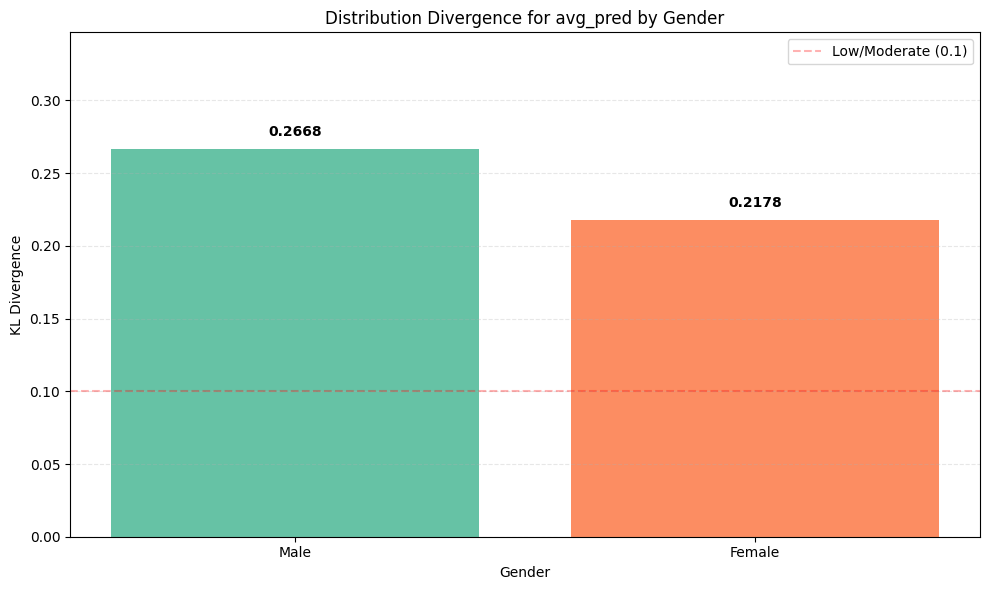

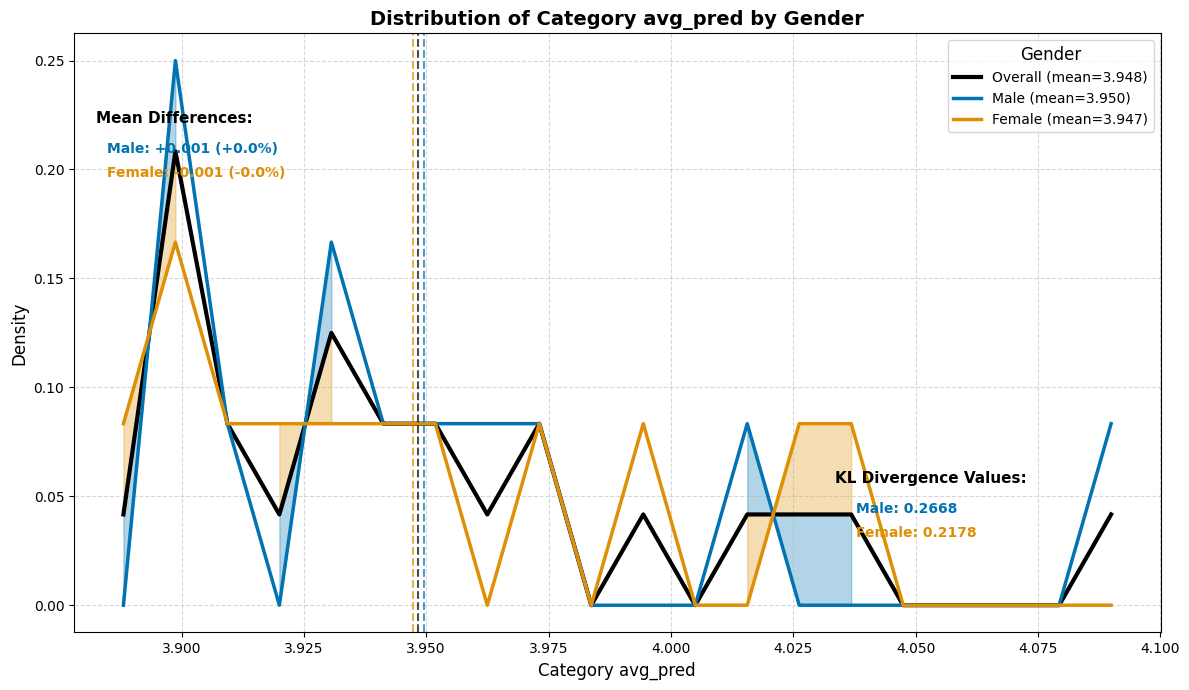

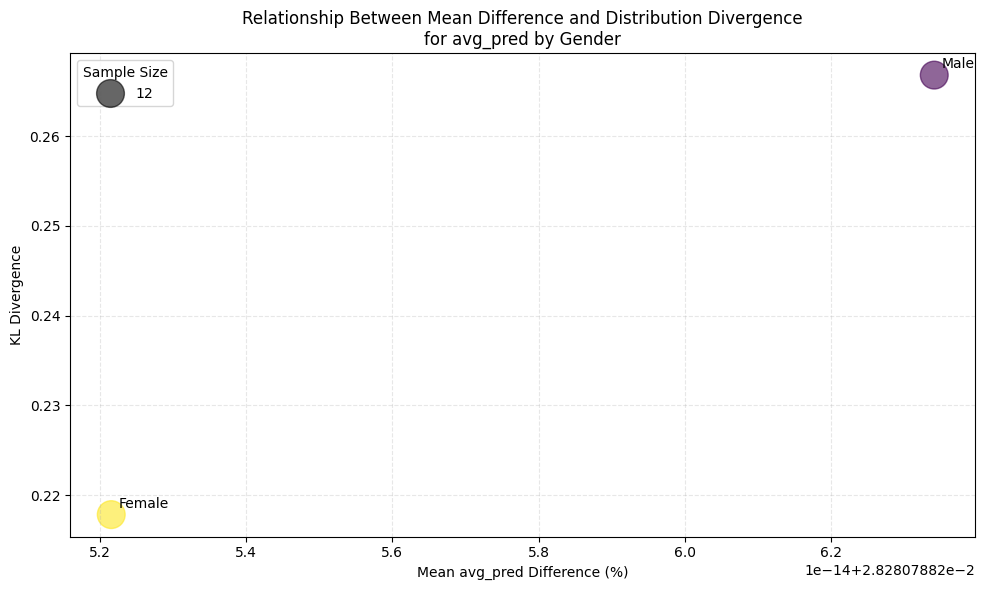


  RMSE KL divergence results:
    Male: nan (high divergence)
      Mean: 0.0000 vs Overall: 0.0000
      Difference: 0.0000 (0.0%)
      Sample size: 12 categories
    Female: nan (high divergence)
      Mean: 0.0000 vs Overall: 0.0000
      Difference: 0.0000 (0.0%)
      Sample size: 12 categories


c:\Users\MelvanderMeij\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\histograms.py:885: RuntimeWarning: divide by zero encountered in divide
  return n/db/n.sum(), bin_edges
c:\Users\MelvanderMeij\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


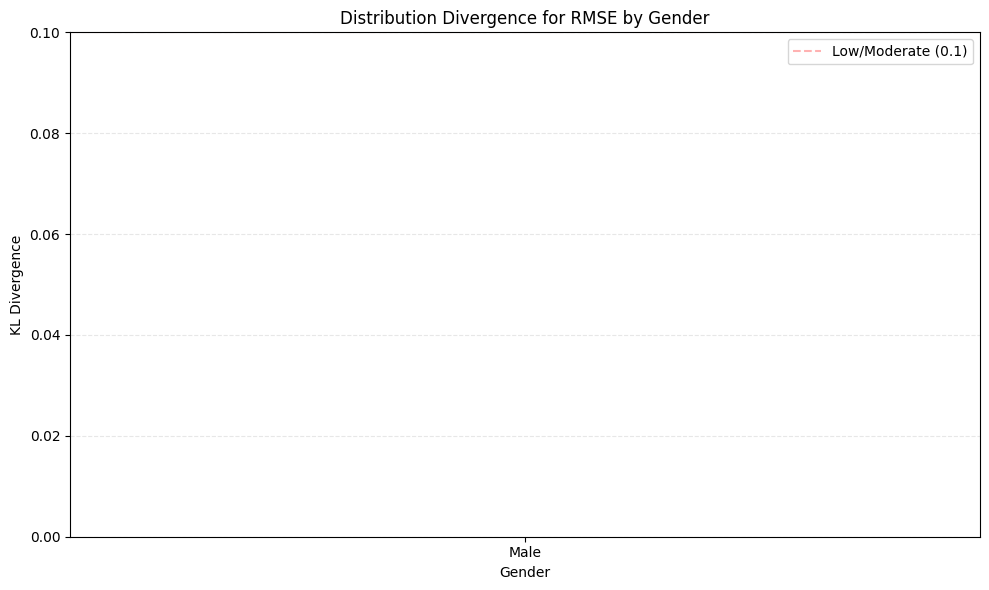

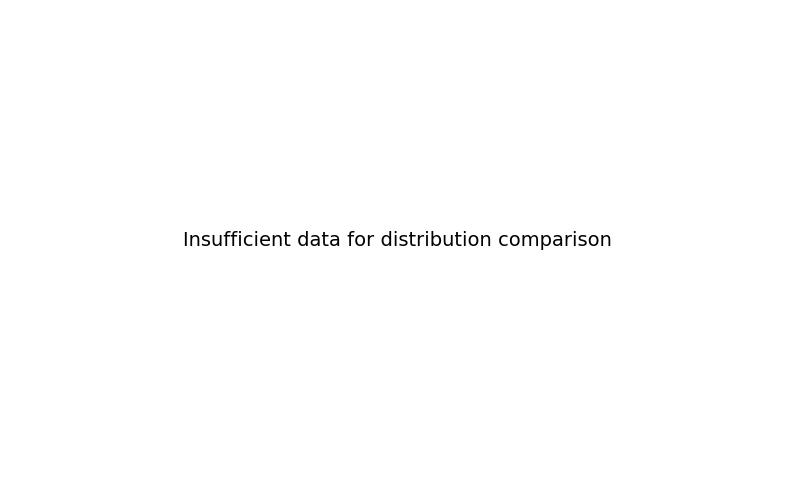

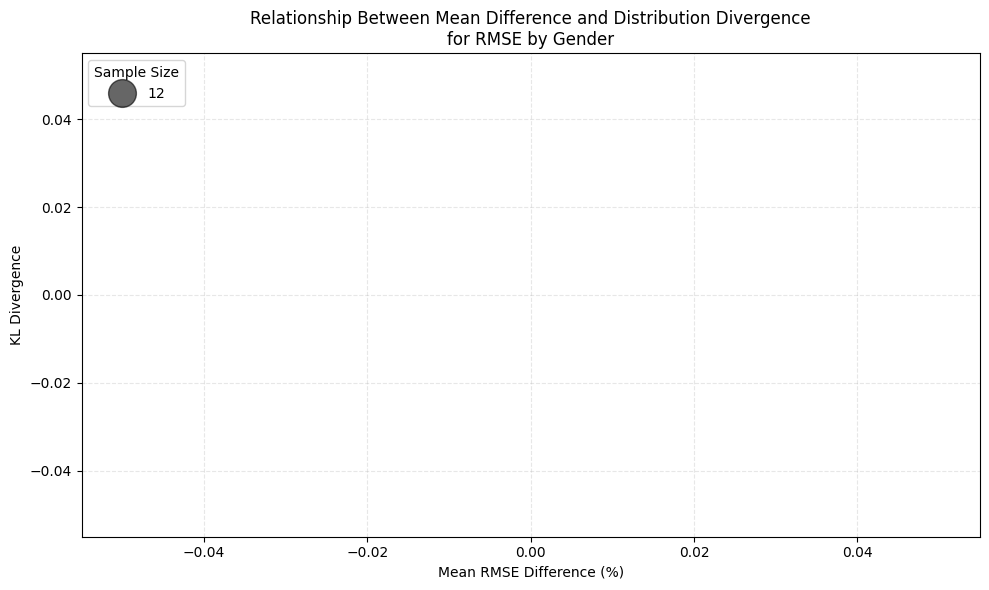


  MAE KL divergence results:
    Male: nan (high divergence)
      Mean: 0.0000 vs Overall: 0.0000
      Difference: 0.0000 (0.0%)
      Sample size: 12 categories
    Female: nan (high divergence)
      Mean: 0.0000 vs Overall: 0.0000
      Difference: 0.0000 (0.0%)
      Sample size: 12 categories


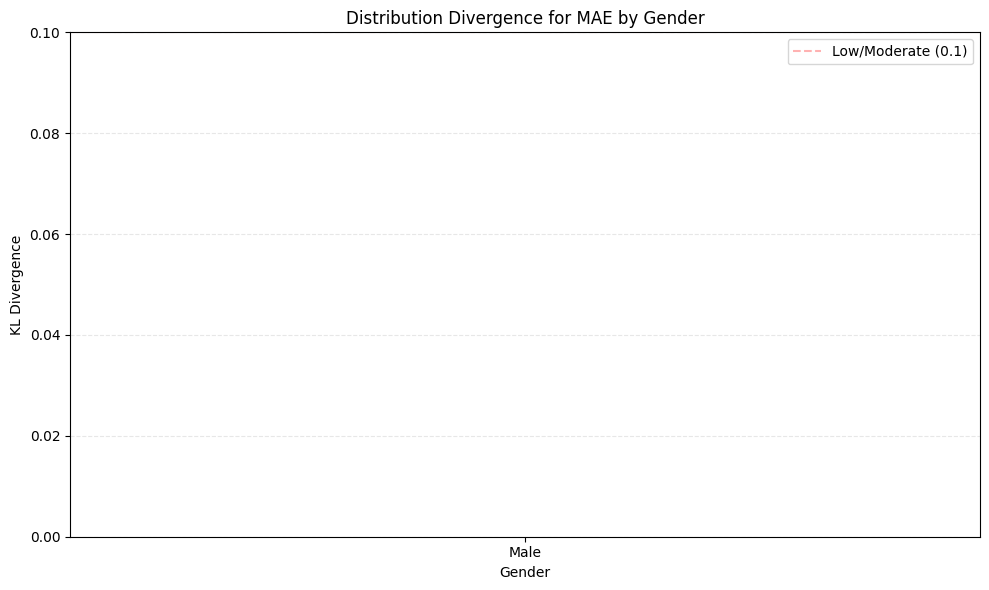

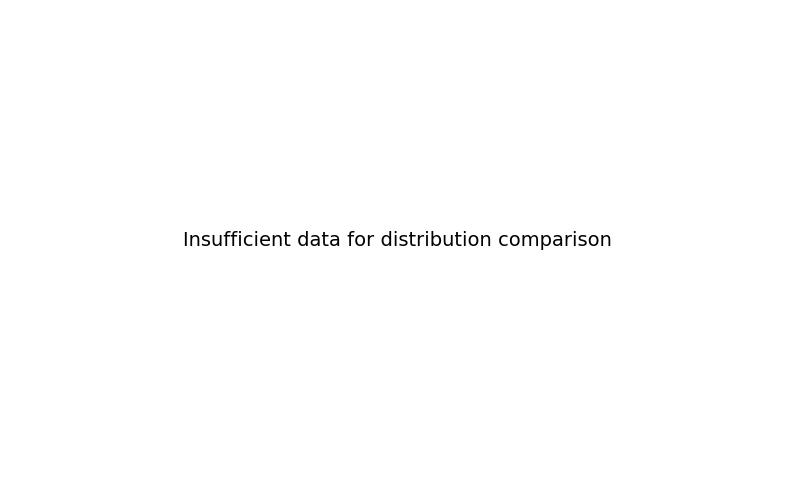

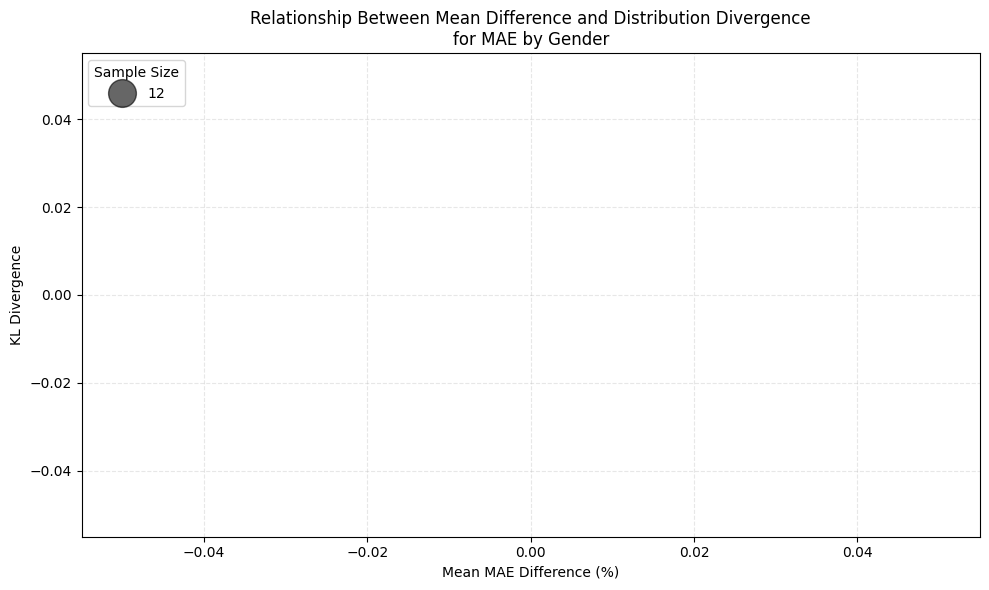


=== KL Divergence Group Fairness Metric (ItemKNN) ===

Analyzing Gender fairness:

  avg_pred KL divergence results:
    Male: 0.4596 (moderate divergence)
      Mean: 3.7627 vs Overall: 3.7964
      Difference: 0.0337 (0.9%)
      Sample size: 10 categories
    Female: 0.2793 (moderate divergence)
      Mean: 3.8204 vs Overall: 3.7964
      Difference: 0.0240 (0.6%)
      Sample size: 14 categories


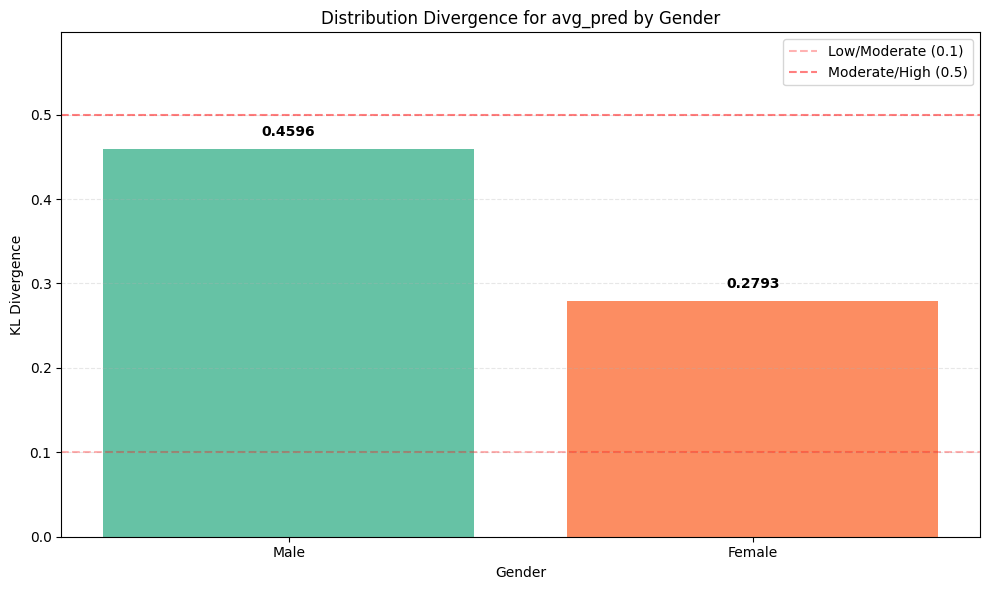

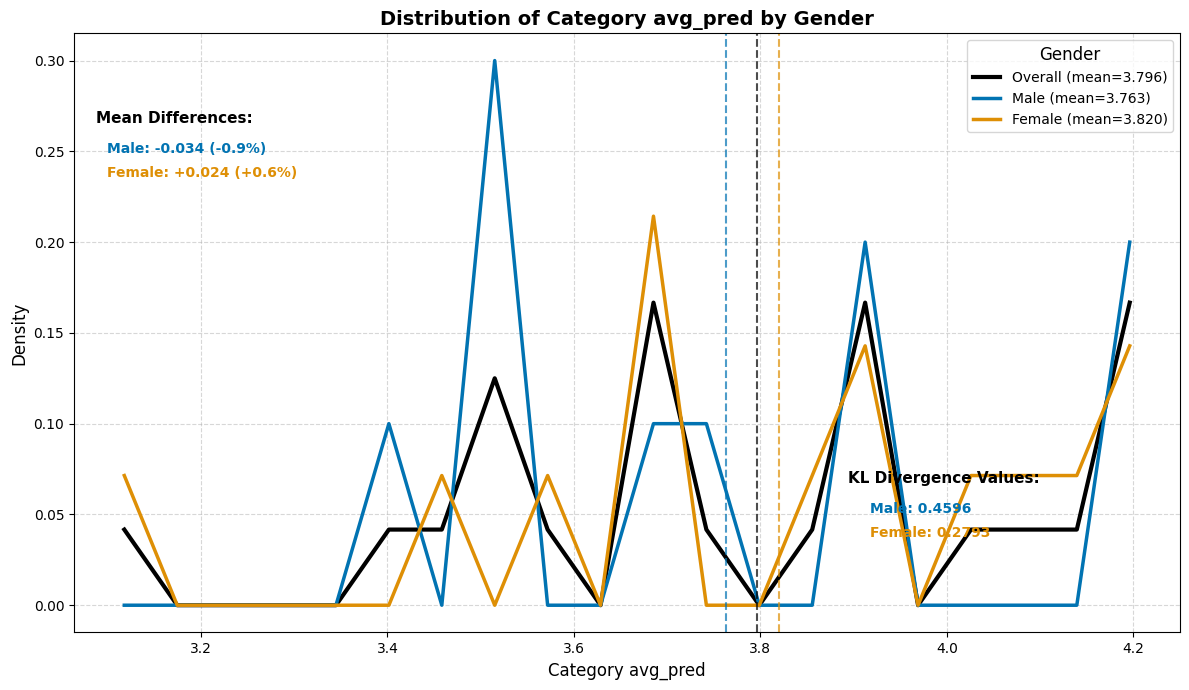

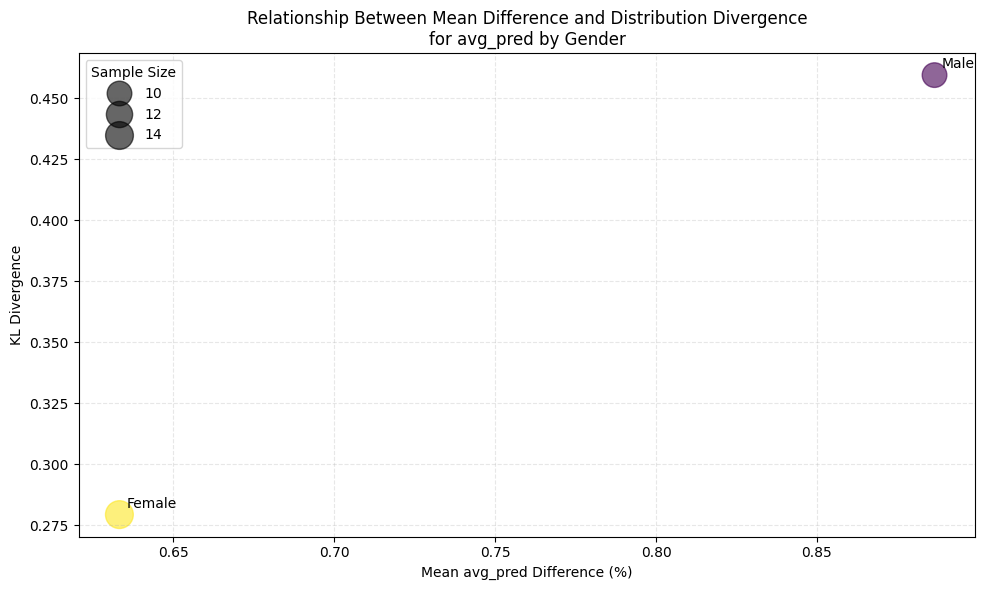


  RMSE KL divergence results:
    Male: 0.2163 (moderate divergence)
      Mean: 2.8250 vs Overall: 2.8436
      Difference: 0.0185 (0.7%)
      Sample size: 10 categories
    Female: 0.0682 (low divergence)
      Mean: 2.8568 vs Overall: 2.8436
      Difference: 0.0132 (0.5%)
      Sample size: 14 categories


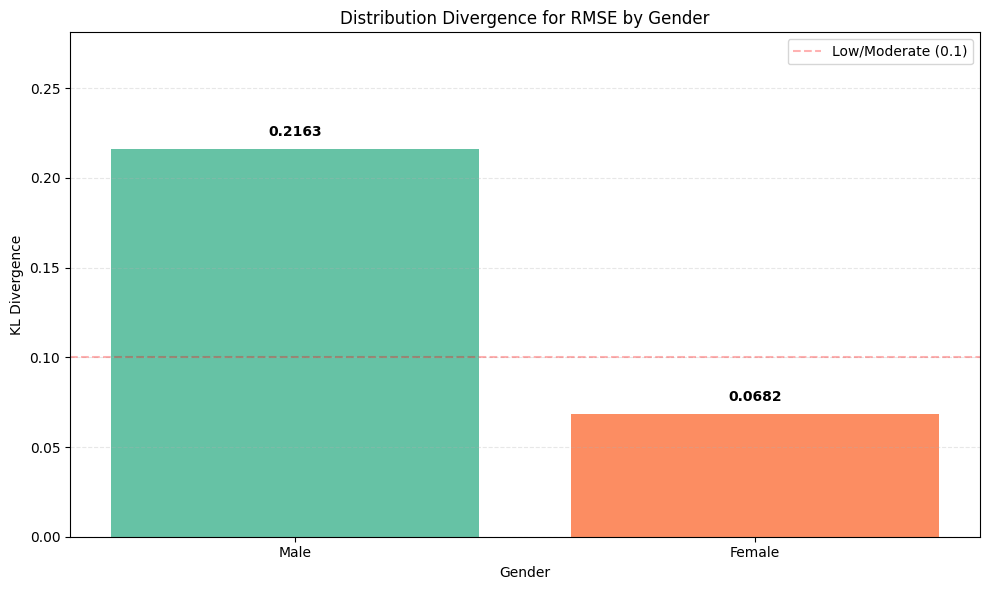

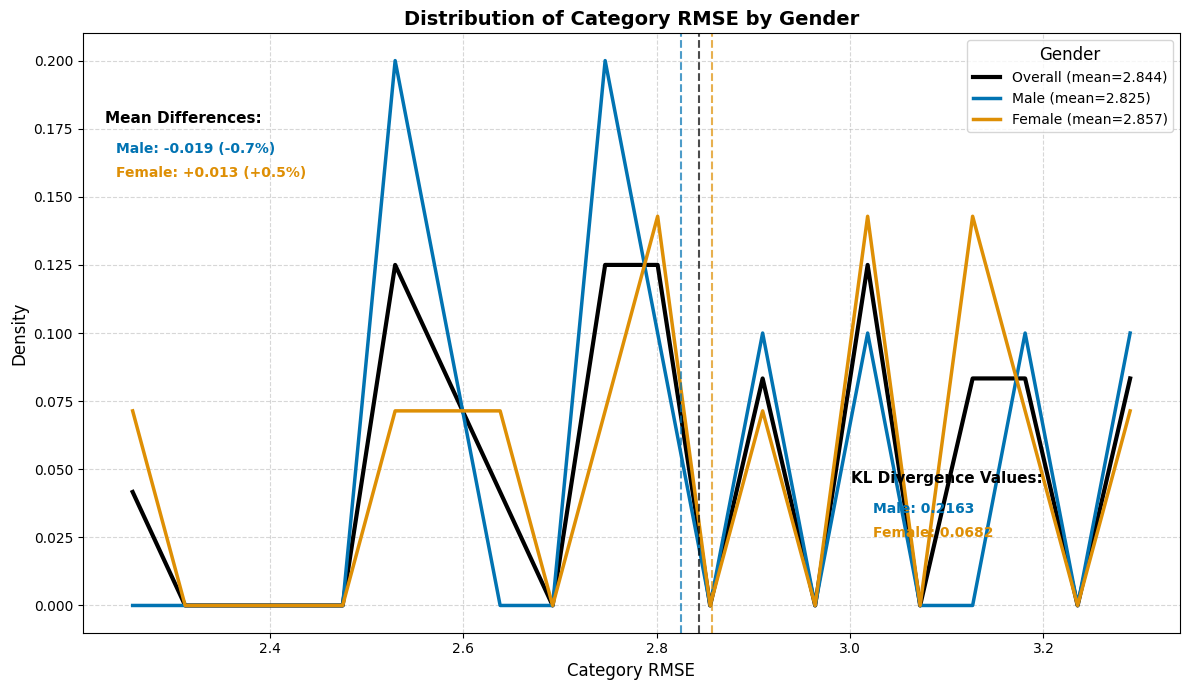

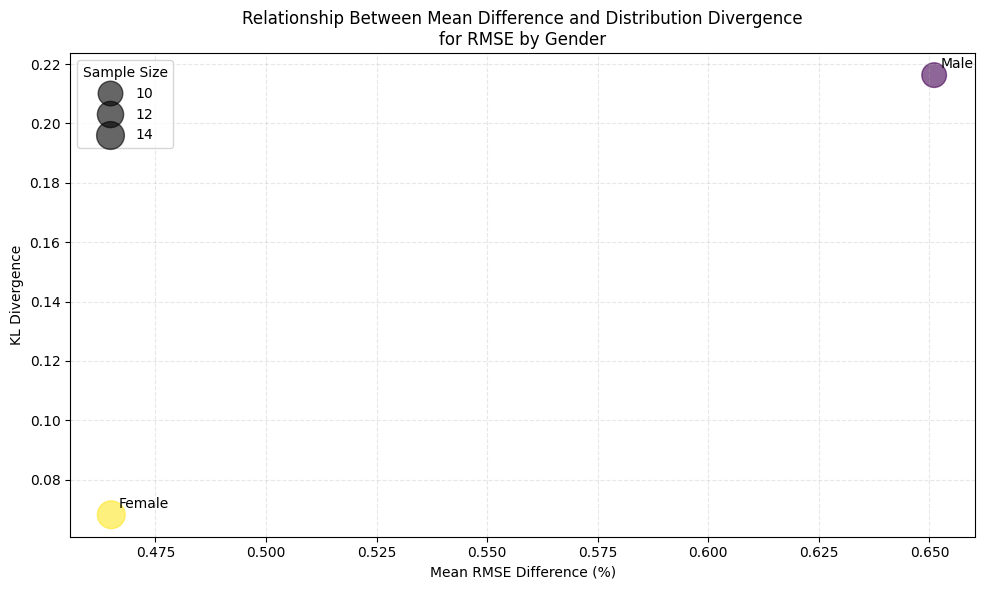


  MAE KL divergence results:
    Male: 0.3210 (moderate divergence)
      Mean: 2.2612 vs Overall: 2.2849
      Difference: 0.0237 (1.0%)
      Sample size: 10 categories
    Female: 0.1429 (moderate divergence)
      Mean: 2.3019 vs Overall: 2.2849
      Difference: 0.0169 (0.7%)
      Sample size: 14 categories


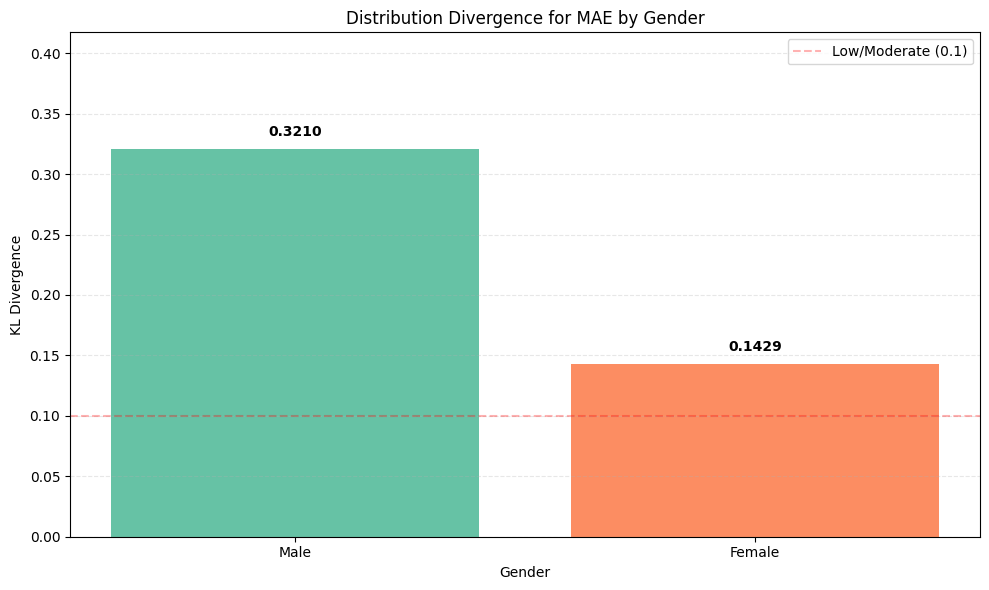

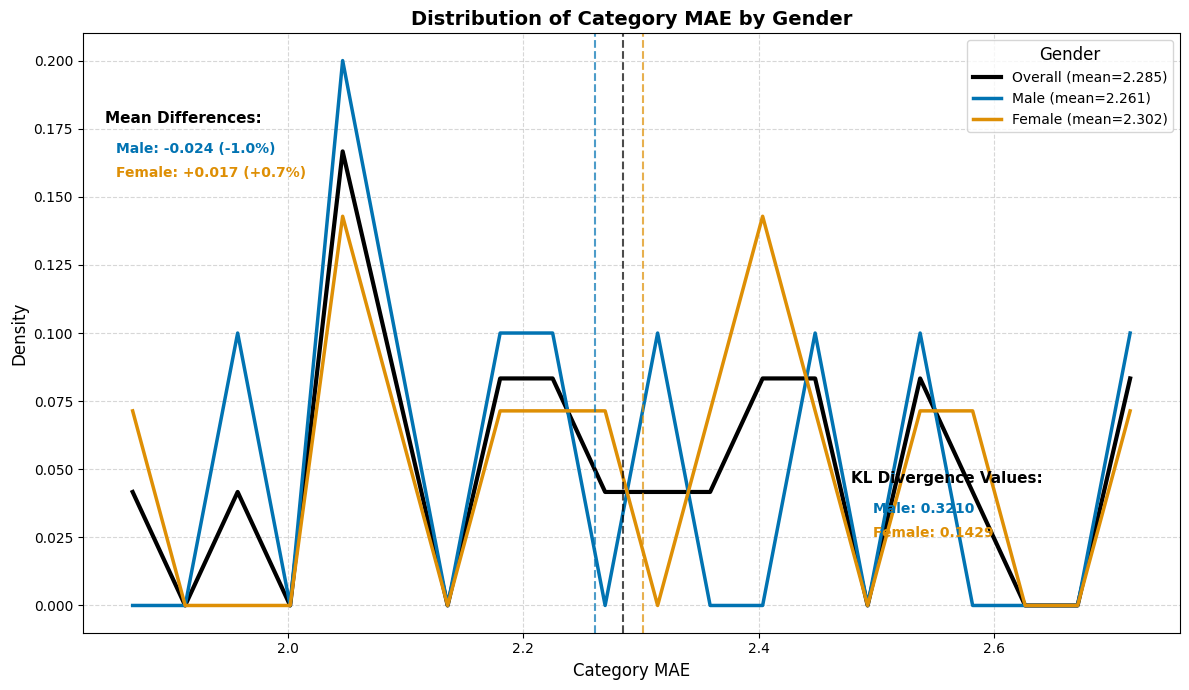

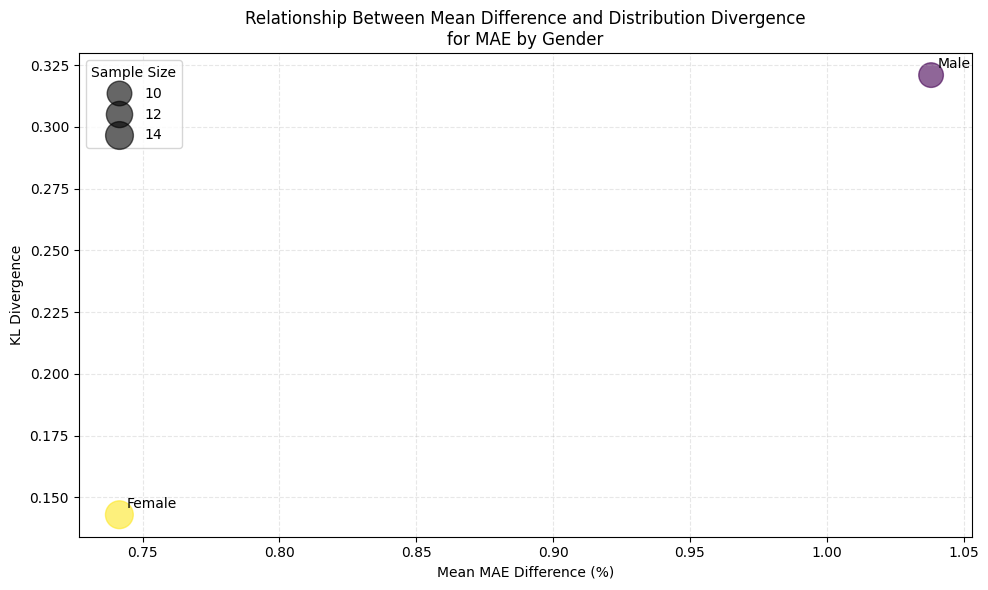

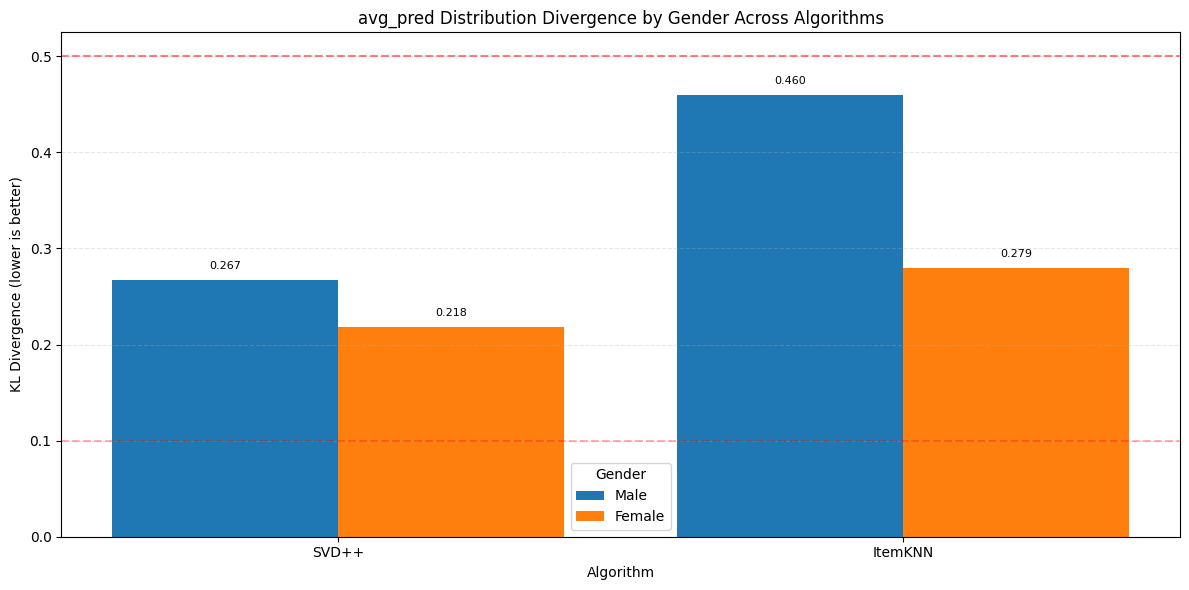

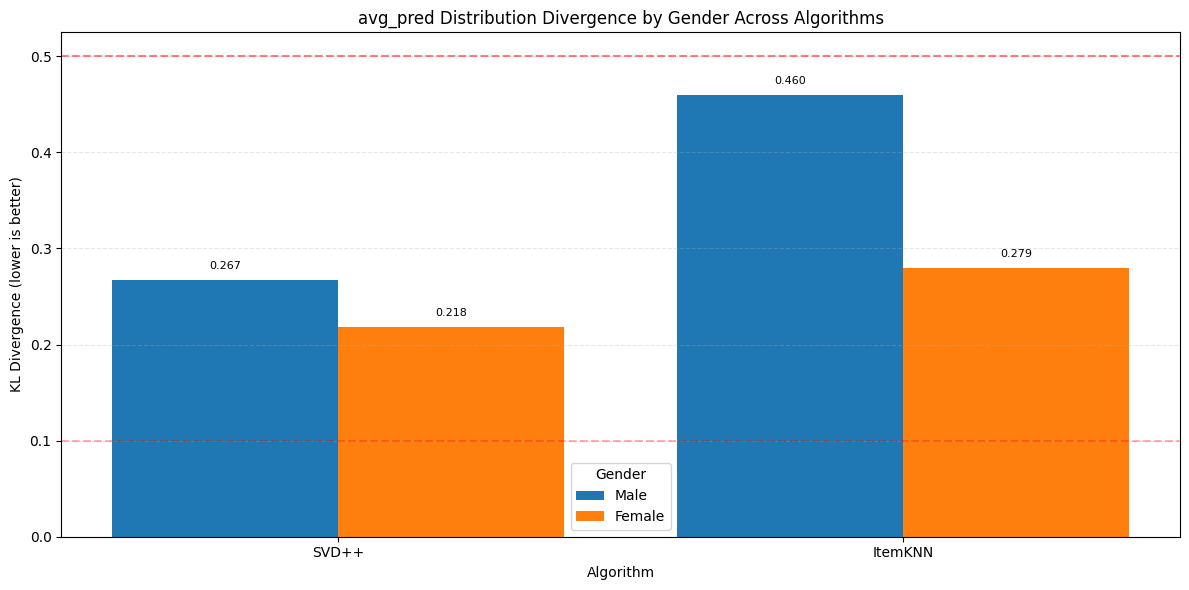

In [75]:
# For SVD++
kl_results_svdpp, category_metrics_svdpp = evaluate_kl_divergence_fairness_svdpp(
    svdpp_predictions=svdpp_predictions,
    e_commerce_data=e_commerce,
    metrics=['avg_pred', 'RMSE', 'MAE'],
    group_cols=['Gender']
)

# For ItemKNN
kl_results_itemknn, category_metrics_itemknn = evaluate_kl_divergence_fairness_itemknn(
    itemknn_predictions=itemknn_predictions,
    e_commerce_data=e_commerce,
    metrics=['avg_pred', 'RMSE', 'MAE'], 
    group_cols=['Gender']
)

# Compare algorithms
compare_kl_divergence_across_algorithms(
    {'SVD++': kl_results_svdpp, 'ItemKNN': kl_results_itemknn},
    metric='avg_pred',
    group_col='Gender'
)

---

Conclusion:
---
Across all fairness dimensions, the SVD++ model consistently outperforms the Item-KNN model, especially in terms of individual fairness (lower variance and mean average envy per user) and group fairness (more consistent treatment within demographic groups). SVD++ shows more stable and equitable recommendations regardless of users’ gender, age, income, or other attributes, ensuring similar quality across peers.

In contrast, Item-KNN, while achieving higher raw satisfaction scores, displays significant disparities within and across groups—indicating potential issues like intra-group favoritism or bias. This model tends to treat users more unequally, especially visible in higher group-level envy and variance scores, and large gaps in gender-based treatment.